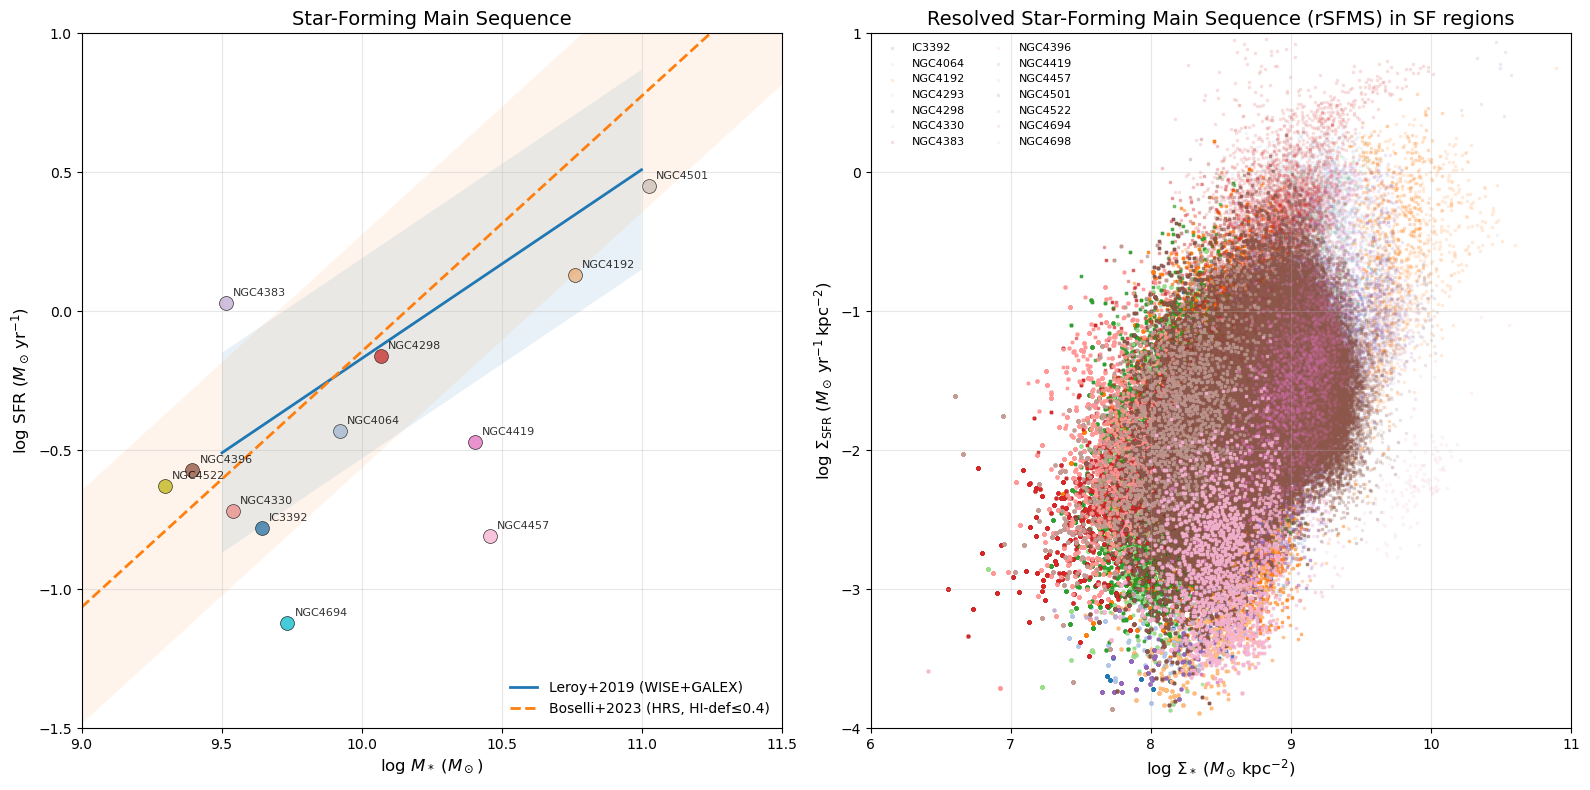

Subplot 1: Plotted 14 galaxies with valid total mass and SFR data
Subplot 2: Plotted spatially-resolved data for 14 galaxies


In [1]:
# ------------------------------------------------------------------
# Combined Plot: Total SFMS + Spatially-resolved Star Formation
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import itertools
from scipy.stats import linregress
from astropy.io import fits

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ------------------------------------------------------------------
# SUBPLOT 1: Total Stellar Mass vs Total SFR from log files
# ------------------------------------------------------------------

# Extraction functions for log files
def extract_total_stellar_mass(galaxy_name):
    """Extract total stellar mass from mass log file. Returns log10(M☉) value or None if not found."""
    log_file = Path(f'mass_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total stellar mass \(R\)\s*:\s*([\d.-]+)\s*log10\(M☉\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading mass log for {galaxy_name}: {e}")
        return None

def extract_total_sfr(galaxy_name):
    """Extract total SFR from SFR log file. Returns log10(M☉/yr) value or None if not found."""
    log_file = Path(f'sfr_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total Halpha SFR from SF region:.*?in log10 scale:\s*([\d.-]+)\s*log\(M☉/yr\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading SFR log for {galaxy_name}: {e}")
        return None

def sfms_leroy2019(logM, scatter=0.36, valid=(9.5, 11.0)):
    """Leroy+2019 eq.19 converted to log SFR: logSFR = 0.68*logM - 6.97."""
    y = 0.68 * np.asarray(logM) - 6.97
    # mask outside their stated mass range
    y = np.where((logM < valid[0]) | (logM > valid[1]), np.nan, y)
    return y

def sfms_boselli2023(logM, slope=0.92, intercept=-1.57, x_pivot=8.451, scatter=0.42):
    """
    Boselli+2023 (HRS, HI-def ≤ 0.4): fit with pivot x_pivot.
    y = slope * (logM - x_pivot) + intercept
    """
    logM = np.asarray(logM)
    y = slope * (logM - x_pivot) + intercept
    return y

# Discover galaxies
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]

# Extract total masses and SFRs
log_masses = []
log_sfrs = []
galaxy_names = []

for gal in galaxies:
    mass = extract_total_stellar_mass(gal)
    sfr = extract_total_sfr(gal)
    
    if mass is not None and sfr is not None:
        log_masses.append(mass)
        log_sfrs.append(sfr)
        galaxy_names.append(gal)

# Convert to numpy arrays
log_masses = np.array(log_masses)
log_sfrs = np.array(log_sfrs)

# Color-code each galaxy
colors_total = plt.cm.tab20(np.linspace(0, 1, len(galaxy_names)))

# Plot points and add galaxy names as annotations
for i, (mass, sfr, gal) in enumerate(zip(log_masses, log_sfrs, galaxy_names)):
    # Plot the point
    ax1.scatter(mass, sfr, s=100, c=[colors_total[i]], alpha=0.8, 
               edgecolors='black', linewidth=0.5)
    
    # Add galaxy name as annotation with slight offset
    ax1.annotate(gal, (mass, sfr), xytext=(5, 5), textcoords='offset points', 
                fontsize=8, alpha=0.8)

# Add labels and formatting for subplot 1
ax1.set_xlabel(r'$\log\,M_* \; (M_\odot)$', fontsize=12)
ax1.set_ylabel(r'$\log\,\mathrm{SFR} \; (M_\odot\,\mathrm{yr}^{-1})$', fontsize=12)
ax1.set_title('Star-Forming Main Sequence', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(9, 11.5)
ax1.set_ylim(-1.5, 1)

# Add SFMS relations
x_line = np.linspace(*ax1.get_xlim(), 400)

# Leroy+2019 line + ±0.36 dex band
y_l19 = sfms_leroy2019(x_line)
ax1.plot(x_line, y_l19, lw=2, ls='-', label='Leroy+2019 (WISE+GALEX)')
ax1.fill_between(x_line, y_l19 - 0.36, y_l19 + 0.36, alpha=0.10, linewidth=0)

# Boselli+2023 line + intrinsic-scatter band
y_b23 = sfms_boselli2023(x_line)
ax1.plot(x_line, y_b23, lw=2, ls='--', label='Boselli+2023 (HRS, HI-def≤0.4)')
ax1.fill_between(x_line, y_b23 - 0.42, y_b23 + 0.42, alpha=0.08, linewidth=0)

# Add legend for SFMS relations
ax1.legend(frameon=False, fontsize=10, loc='lower right')

# ------------------------------------------------------------------
# SUBPLOT 2: Spatially-resolved Σ* vs ΣSFR
# ------------------------------------------------------------------

# Colour cycle for spatially-resolved plot
colors_spatial = itertools.cycle(plt.get_cmap('tab20').colors)

# Collect all data points for global fit
all_x = []
all_y = []

for gal, colour in zip(galaxies, colors_spatial):
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Read FITS extensions
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            logSigmaSFR = hdul['LOGSFR_SURFACE_DENSITY_SF'].data  # Σ_SFR

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(logSigmaSFR)

        # Scatter plot
        ax2.scatter(
            logSigmaM[good],
            logSigmaSFR[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=colour,
            label=gal
        )
        
        # Collect points for global fit
        all_x.extend(logSigmaM[good])
        all_y.extend(logSigmaSFR[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Final cosmetics for subplot 2
ax2.set_xlabel(r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax2.set_ylabel(r'$\log\,\Sigma_{\mathrm{SFR}}\; (M_\odot\,\mathrm{yr}^{-1}\,\mathrm{kpc}^{-2})$', fontsize=12)
ax2.set_title(r'Resolved Star-Forming Main Sequence (rSFMS) in SF regions', fontsize=14)
ax2.set_xlim(6, 11)
ax2.set_ylim(-4, 1)
ax2.grid(True, alpha=0.3)
ax2.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

print(f"Subplot 1: Plotted {len(galaxy_names)} galaxies with valid total mass and SFR data")
print(f"Subplot 2: Plotted spatially-resolved data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")

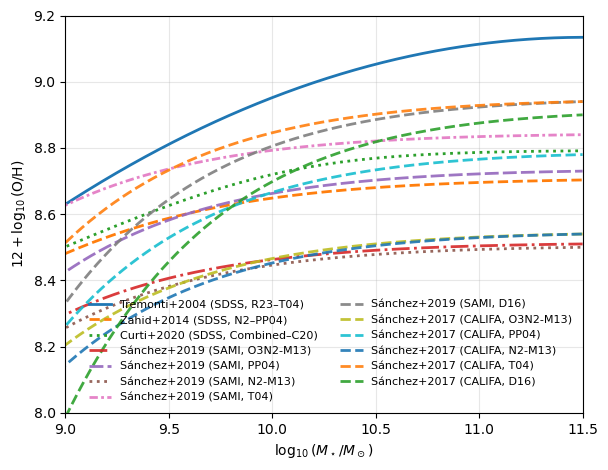

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def mzr_tremonti2004(logM):
    logM = np.asarray(logM, dtype=float)
    oh12 = -1.492 + 1.847*logM - 0.08026*(logM**2)
    oh12[(logM < 8.5) | (logM > 11.5)] = np.nan
    return oh12

def mzr_zahid2014(logM, Z0=8.710, logM0=8.76, gamma=0.66):
    logM = np.asarray(logM, dtype=float)
    term = 1.0 + 10.0**(-gamma * (logM - logM0))
    return Z0 - np.log10(term)

def mzr_curti2020(logM, Z0=8.793, logM0=10.02, gamma=0.28, beta=1.2):
    logM = np.asarray(logM, dtype=float)
    term = 1.0 + 10.0**(-beta * (logM - logM0))
    return Z0 - (gamma / beta) * np.log10(term)

def mzr_sanchez2019(logM, a, b, c=3.5):
    logM = np.asarray(logM, dtype=float)
    x = logM - 8.0
    t = x - c
    return a + b * t * np.exp(-t)

S19_PARAMS = {
    "O3N2-M13": dict(a=8.51, b=0.007),
    "PP04"    : dict(a=8.73, b=0.010),
    "N2-M13"  : dict(a=8.50, b=0.008),
    "T04"     : dict(a=8.84, b=0.007),
    "D16"     : dict(a=8.94, b=0.020),  # table’s DOP16 = D16
}

S19_STYLES = {
    "O3N2-M13": "-.",
    "PP04"    : (0, (5, 1.5)),
    "N2-M13"  : ":",
    "T04"     : (0, (3, 1.2, 1, 1.2)),
    "D16"     : "--",
}

# --- NEW: Sánchez+2017 (same functional form as 2019) ---
def mzr_sanchez2017(logM, a, b, c=3.5):
    logM = np.asarray(logM, dtype=float)
    x = logM - 8.0
    t = x - c
    return a + b * t * np.exp(-t)

# --- NEW: Sánchez+2017 (CALIFA) parameters for 5 requested calibrations ---
# CALIFA table labels DOP16; we keep the external key as "D16" for consistency.
S17_PARAMS = {
    "O3N2-M13": dict(a=8.54, b=0.011),
    "PP04"    : dict(a=8.78, b=0.017),
    "N2-M13"  : dict(a=8.54, b=0.013),
    "T04"     : dict(a=8.94, b=0.014),
    "D16"     : dict(a=8.90, b=0.030),  # CALIFA "DOP16"
}

def plot_previous_MZR(ax=None,
                      mass_range=(8.5, 11.5),
                      zahid_params=dict(Z0=8.710, logM0=8.76, gamma=0.66),
                      curti_params=dict(Z0=8.793, logM0=10.02, gamma=0.28, beta=1.2),
                      include=('T04','Z14','C20'),
                      sanchez_calibs=("O3N2-M13", "PP04", "N2-M13", "T04", "D16"),
                      # NEW: off by default to preserve behavior
                      sanchez2017_calibs=(),
                      show_legend=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6.2, 4.8))

    logM = np.linspace(mass_range[0], mass_range[1], 800)

    # === Literature curves ===
    if 'T04' in include:
        ax.plot(logM, mzr_tremonti2004(logM), lw=2,
                label='Tremonti+2004 (SDSS, R23–T04)')
    if 'Z14' in include:
        z = mzr_zahid2014(logM, **zahid_params)
        ax.plot(logM, z, lw=2, ls='--',
                label='Zahid+2014 (SDSS, N2–PP04)')
    if 'C20' in include:
        c = mzr_curti2020(logM, **curti_params)
        ax.plot(logM, c, lw=2, ls=':',
                label='Curti+2020 (SDSS, Combined–C20)')

    # Sánchez+2019 (SAMI)
    for calib in sanchez_calibs:
        if calib not in S19_PARAMS:
            continue
        pars = S19_PARAMS[calib]
        y = mzr_sanchez2019(logM, **pars)
        ls = S19_STYLES.get(calib, "-.")
        ax.plot(logM, y, lw=2, ls=ls, alpha=0.9,
                label=f"Sánchez+2019 (SAMI, {calib})")

    # --- NEW: Sánchez+2017 (CALIFA) optional overlay ---
    for calib in sanchez2017_calibs:
        if calib not in S17_PARAMS:
            continue
        pars = S17_PARAMS[calib]
        y = mzr_sanchez2017(logM, **pars)
        ax.plot(logM, y, lw=2, ls='--', alpha=0.9,
                label=f"Sánchez+2017 (CALIFA, {calib})")

    ax.set_xlim(mass_range)
    ax.set_xlabel(r'$\log_{10}(M_\star/M_\odot)$')
    ax.set_ylabel(r'$12+\log_{10}(\mathrm{O/H})$')
    ax.set_xlim(9, 11.5)
    ax.set_ylim(8.0, 9.2)
    ax.grid(True, alpha=0.3)
    if show_legend:
        ax.legend(frameon=False, ncol=2, fontsize=8)
    plt.tight_layout()
    return ax

# Example
if __name__ == "__main__":
    plot_previous_MZR(
        sanchez2017_calibs=("O3N2-M13","PP04","N2-M13","T04","D16")
    )
    plt.show()


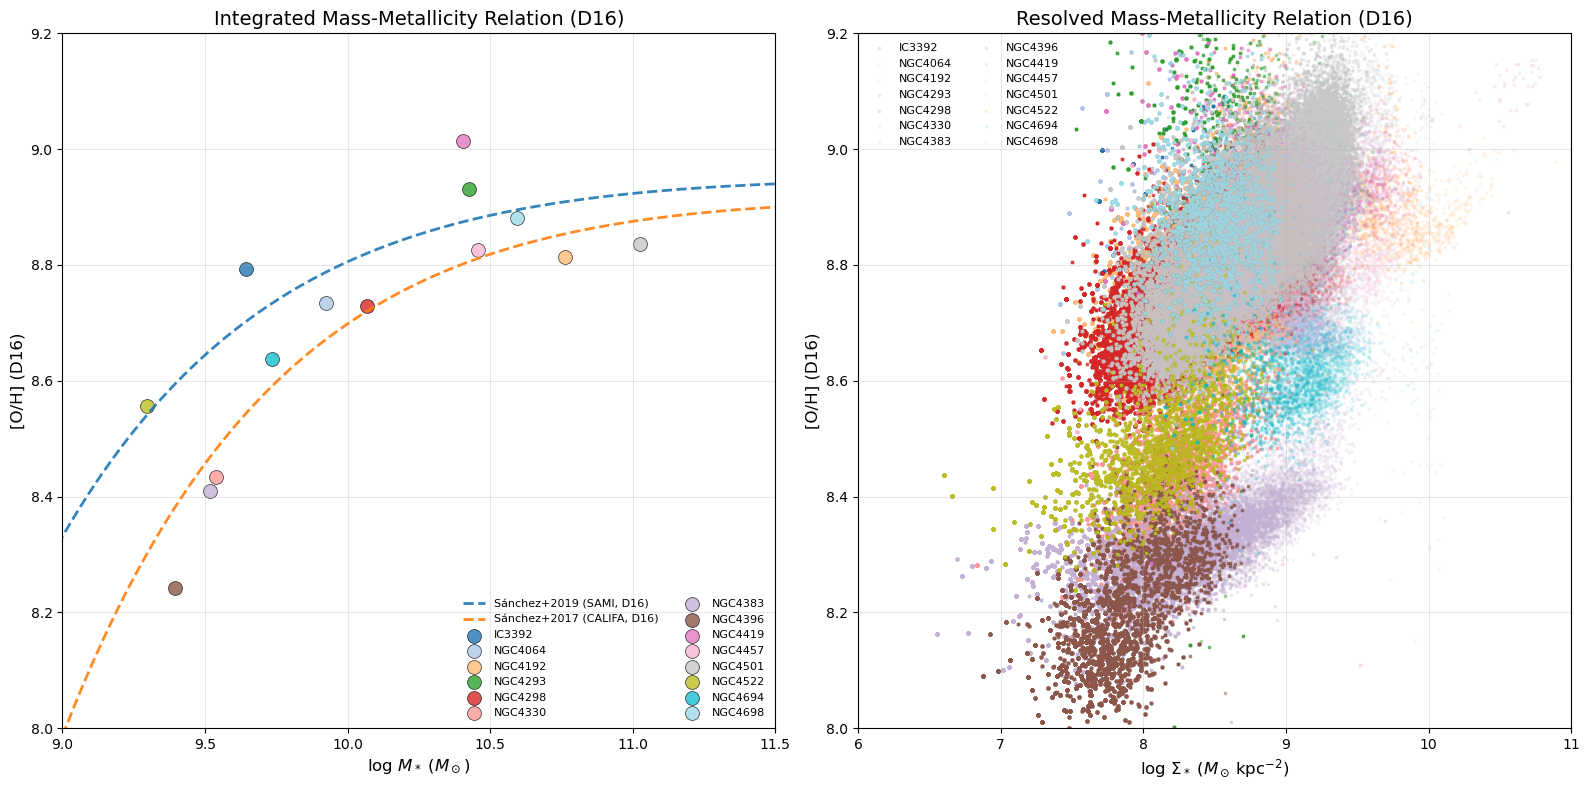

Subplot 1: Plotted 14 galaxies with valid total mass and D16 metallicity data
Subplot 2: Plotted spatially-resolved D16 MZR data for 14 galaxies


In [3]:
# ------------------------------------------------------------------
# Combined Plot: Integrated MZR (D16) + Resolved MZR (D16)
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import itertools
from scipy.stats import linregress
from astropy.io import fits

def mzr_tremonti2004(logM):
    logM = np.asarray(logM, dtype=float)
    oh12 = -1.492 + 1.847*logM - 0.08026*(logM**2)
    oh12[(logM < 8.5) | (logM > 11.5)] = np.nan
    return oh12

def mzr_zahid2014(logM, Z0=8.710, logM0=8.76, gamma=0.66):
    logM = np.asarray(logM, dtype=float)
    term = 1.0 + 10.0**(-gamma * (logM - logM0))
    return Z0 - np.log10(term)

def mzr_curti2020(logM, Z0=8.793, logM0=10.02, gamma=0.28, beta=1.2):
    logM = np.asarray(logM, dtype=float)
    term = 1.0 + 10.0**(-beta * (logM - logM0))
    return Z0 - (gamma / beta) * np.log10(term)

def mzr_sanchez2019(logM, a, b, c=3.5):
    logM = np.asarray(logM, dtype=float)
    x = logM - 8.0
    t = x - c
    return a + b * t * np.exp(-t)

S19_PARAMS = {
    "O3N2-M13": dict(a=8.51, b=0.007),
    "PP04"    : dict(a=8.73, b=0.010),
    "N2-M13"  : dict(a=8.50, b=0.008),
    "T04"     : dict(a=8.84, b=0.007),
    "D16"     : dict(a=8.94, b=0.020),  # table’s DOP16 = D16
}

S19_STYLES = {
    "O3N2-M13": "-.",
    "PP04"    : (0, (5, 1.5)),
    "N2-M13"  : ":",
    "T04"     : (0, (3, 1.2, 1, 1.2)),
    "D16"     : "--",
}

# --- NEW: Sánchez+2017 (same functional form as 2019) ---
def mzr_sanchez2017(logM, a, b, c=3.5):
    logM = np.asarray(logM, dtype=float)
    x = logM - 8.0
    t = x - c
    return a + b * t * np.exp(-t)

# --- NEW: Sánchez+2017 (CALIFA) parameters for 5 requested calibrations ---
# CALIFA table labels DOP16; we keep the external key as "D16" for consistency.
S17_PARAMS = {
    "O3N2-M13": dict(a=8.54, b=0.011),
    "PP04"    : dict(a=8.78, b=0.017),
    "N2-M13"  : dict(a=8.54, b=0.013),
    "T04"     : dict(a=8.94, b=0.014),
    "D16"     : dict(a=8.90, b=0.030),  # CALIFA "DOP16"
}

def plot_previous_MZR(ax=None,
                      mass_range=(8.5, 11.5),
                      zahid_params=dict(Z0=8.710, logM0=8.76, gamma=0.66),
                      curti_params=dict(Z0=8.793, logM0=10.02, gamma=0.28, beta=1.2),
                      include=('T04','Z14','C20'),
                      sanchez_calibs=("O3N2-M13", "PP04", "N2-M13", "T04", "D16"),
                      # NEW: off by default to preserve behavior
                      sanchez2017_calibs=(),
                      show_legend=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6.2, 4.8))

    logM = np.linspace(mass_range[0], mass_range[1], 800)

    # === Literature curves ===
    if 'T04' in include:
        ax.plot(logM, mzr_tremonti2004(logM), lw=2,
                label='Tremonti+2004 (SDSS, R23–T04)')
    if 'Z14' in include:
        z = mzr_zahid2014(logM, **zahid_params)
        ax.plot(logM, z, lw=2, ls='--',
                label='Zahid+2014 (SDSS, N2–PP04)')
    if 'C20' in include:
        c = mzr_curti2020(logM, **curti_params)
        ax.plot(logM, c, lw=2, ls=':',
                label='Curti+2020 (SDSS, Combined–C20)')

    # Sánchez+2019 (SAMI)
    for calib in sanchez_calibs:
        if calib not in S19_PARAMS:
            continue
        pars = S19_PARAMS[calib]
        y = mzr_sanchez2019(logM, **pars)
        ls = S19_STYLES.get(calib, "-.")
        ax.plot(logM, y, lw=2, ls=ls, alpha=0.9,
                label=f"Sánchez+2019 (SAMI, {calib})")

    # --- NEW: Sánchez+2017 (CALIFA) optional overlay ---
    for calib in sanchez2017_calibs:
        if calib not in S17_PARAMS:
            continue
        pars = S17_PARAMS[calib]
        y = mzr_sanchez2017(logM, **pars)
        ax.plot(logM, y, lw=2, ls='--', alpha=0.9,
                label=f"Sánchez+2017 (CALIFA, {calib})")

    ax.set_xlim(mass_range)
    ax.set_xlabel(r'$\log_{10}(M_\star/M_\odot)$')
    ax.set_ylabel(r'$12+\log_{10}(\mathrm{O/H})$')
    ax.set_xlim(9, 11.5)
    ax.set_ylim(8.0, 9.2)
    ax.grid(True, alpha=0.3)
    if show_legend:
        ax.legend(frameon=False, ncol=2)
    plt.tight_layout()
    return ax

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ------------------------------------------------------------------
# SUBPLOT 1: Total Stellar Mass vs Total D16 Metallicity from log files
# ------------------------------------------------------------------

# Extraction functions for log files
def extract_total_stellar_mass(galaxy_name):
    """Extract total stellar mass from mass log file. Returns log10(M☉) value or None if not found."""
    log_file = Path(f'mass_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total stellar mass \(R\)\s*:\s*([\d.-]+)\s*log10\(M☉\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading mass log for {galaxy_name}: {e}")
        return None

def extract_total_d16_metallicity(galaxy_name):
    """Extract total D16 metallicity from log file. Returns [O/H] D16 value or None if not found."""
    log_file = Path(f'sfr_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'\[O/H\] D16 SF: Total metallicity in SF region:\s*([\d.-]+)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading D16 metallicity log for {galaxy_name}: {e}")
        return None

# Discover galaxies
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]

# Create galaxy color mapping (consistent for both subplots)
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, len(galaxies)))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

# Extract total masses and D16 metallicities
log_masses = []
d16_metallicities = []
galaxy_names = []

for gal in galaxies:
    mass = extract_total_stellar_mass(gal)
    metallicity = extract_total_d16_metallicity(gal)
    
    if mass is not None and metallicity is not None:
        log_masses.append(mass)
        d16_metallicities.append(metallicity)
        galaxy_names.append(gal)

# Convert to numpy arrays
log_masses = np.array(log_masses)
d16_metallicities = np.array(d16_metallicities)

# Plot reference MZR relations from literature (D16-relevant only)
plot_previous_MZR(ax=ax1, show_legend=False, include=(), sanchez_calibs=("D16",), sanchez2017_calibs=("D16",))

# Plot subplot 1 using consistent colors
for i, (mass, metallicity, gal) in enumerate(zip(log_masses, d16_metallicities, galaxy_names)):
    ax1.scatter(mass, metallicity, s=100, c=[galaxy_color_dict[gal]], label=gal, alpha=0.8, 
               edgecolors='black', linewidth=0.5)

# Add labels and formatting for subplot 1
ax1.set_xlabel(r'$\log\,M_* \; (M_\odot)$', fontsize=12)
ax1.set_ylabel(r'[O/H] (D16)', fontsize=12)
ax1.set_title('Integrated Mass-Metallicity Relation (D16)', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='lower right', fontsize=8, ncol=2, frameon=False)
ax1.set_xlim(9, 11.5)
ax1.set_ylim(8.0, 9.2)

# ------------------------------------------------------------------
# SUBPLOT 2: Spatially-resolved Σ* vs [O/H] D16
# ------------------------------------------------------------------

# Collect all data points for global fit
all_x = []
all_y = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Read FITS extensions
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_d16 = hdul['O_H_D16_SF'].data  # [O/H] D16

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_d16)

        # Scatter plot using consistent galaxy colors
        ax2.scatter(
            logSigmaM[good],
            oh_d16[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x.extend(logSigmaM[good])
        all_y.extend(oh_d16[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Final cosmetics for subplot 2
ax2.set_xlabel(r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax2.set_ylabel(r'[O/H] (D16)', fontsize=12)
ax2.set_title(r'Resolved Mass-Metallicity Relation (D16)', fontsize=14)
ax2.set_xlim(6, 11)
ax2.set_ylim(8.0, 9.2)
ax2.grid(True, alpha=0.3)
ax2.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

print(f"Subplot 1: Plotted {len(galaxy_names)} galaxies with valid total mass and D16 metallicity data")
print(f"Subplot 2: Plotted spatially-resolved D16 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")

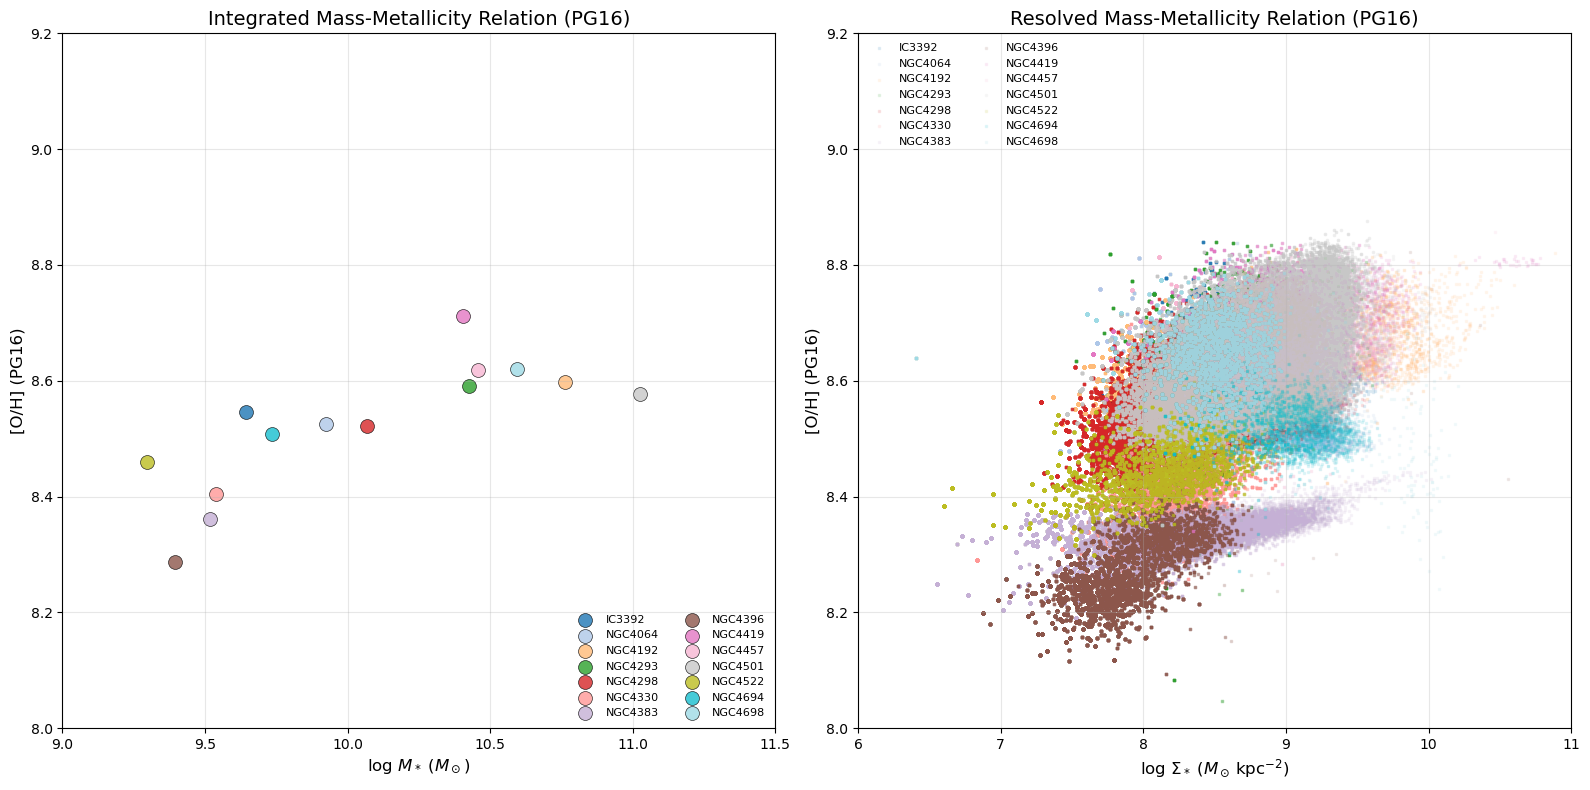

Subplot 1: Plotted 14 galaxies with valid total mass and PG16 metallicity data
Subplot 2: Plotted spatially-resolved PG16 MZR data for 14 galaxies


In [4]:
# ------------------------------------------------------------------
# Combined Plot: Integrated MZR (PG16) + Resolved MZR (PG16)
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import itertools
from scipy.stats import linregress
from astropy.io import fits

def mzr_tremonti2004(logM):
    logM = np.asarray(logM, dtype=float)
    oh12 = -1.492 + 1.847*logM - 0.08026*(logM**2)
    oh12[(logM < 8.5) | (logM > 11.5)] = np.nan
    return oh12

def mzr_zahid2014(logM, Z0=8.710, logM0=8.76, gamma=0.66):
    logM = np.asarray(logM, dtype=float)
    term = 1.0 + 10.0**(-gamma * (logM - logM0))
    return Z0 - np.log10(term)

def mzr_curti2020(logM, Z0=8.793, logM0=10.02, gamma=0.28, beta=1.2):
    logM = np.asarray(logM, dtype=float)
    term = 1.0 + 10.0**(-beta * (logM - logM0))
    return Z0 - (gamma / beta) * np.log10(term)

def mzr_sanchez2019(logM, a, b, c=3.5):
    logM = np.asarray(logM, dtype=float)
    x = logM - 8.0
    t = x - c
    return a + b * t * np.exp(-t)

S19_PARAMS = {
    "O3N2-M13": dict(a=8.51, b=0.007),
    "PP04"    : dict(a=8.73, b=0.010),
    "N2-M13"  : dict(a=8.50, b=0.008),
    "T04"     : dict(a=8.84, b=0.007),
    "D16"     : dict(a=8.94, b=0.020),  # table’s DOP16 = D16
}

S19_STYLES = {
    "O3N2-M13": "-.",
    "PP04"    : (0, (5, 1.5)),
    "N2-M13"  : ":",
    "T04"     : (0, (3, 1.2, 1, 1.2)),
    "D16"     : "--",
}

# --- NEW: Sánchez+2017 (same functional form as 2019) ---
def mzr_sanchez2017(logM, a, b, c=3.5):
    logM = np.asarray(logM, dtype=float)
    x = logM - 8.0
    t = x - c
    return a + b * t * np.exp(-t)

# --- NEW: Sánchez+2017 (CALIFA) parameters for 5 requested calibrations ---
# CALIFA table labels DOP16; we keep the external key as "D16" for consistency.
S17_PARAMS = {
    "O3N2-M13": dict(a=8.54, b=0.011),
    "PP04"    : dict(a=8.78, b=0.017),
    "N2-M13"  : dict(a=8.54, b=0.013),
    "T04"     : dict(a=8.94, b=0.014),
    "D16"     : dict(a=8.90, b=0.030),  # CALIFA "DOP16"
}

def plot_previous_MZR(ax=None,
                      mass_range=(8.5, 11.5),
                      zahid_params=dict(Z0=8.710, logM0=8.76, gamma=0.66),
                      curti_params=dict(Z0=8.793, logM0=10.02, gamma=0.28, beta=1.2),
                      include=('T04','Z14','C20'),
                      sanchez_calibs=("O3N2-M13", "PP04", "N2-M13", "T04", "D16"),
                      # NEW: off by default to preserve behavior
                      sanchez2017_calibs=(),
                      show_legend=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6.2, 4.8))

    logM = np.linspace(mass_range[0], mass_range[1], 800)

    # === Literature curves ===
    if 'T04' in include:
        ax.plot(logM, mzr_tremonti2004(logM), lw=2,
                label='Tremonti+2004 (SDSS, R23–T04)')
    if 'Z14' in include:
        z = mzr_zahid2014(logM, **zahid_params)
        ax.plot(logM, z, lw=2, ls='--',
                label='Zahid+2014 (SDSS, N2–PP04)')
    if 'C20' in include:
        c = mzr_curti2020(logM, **curti_params)
        ax.plot(logM, c, lw=2, ls=':',
                label='Curti+2020 (SDSS, Combined–C20)')

    # Sánchez+2019 (SAMI)
    for calib in sanchez_calibs:
        if calib not in S19_PARAMS:
            continue
        pars = S19_PARAMS[calib]
        y = mzr_sanchez2019(logM, **pars)
        ls = S19_STYLES.get(calib, "-.")
        ax.plot(logM, y, lw=2, ls=ls, alpha=0.9,
                label=f"Sánchez+2019 (SAMI, {calib})")

    # --- NEW: Sánchez+2017 (CALIFA) optional overlay ---
    for calib in sanchez2017_calibs:
        if calib not in S17_PARAMS:
            continue
        pars = S17_PARAMS[calib]
        y = mzr_sanchez2017(logM, **pars)
        ax.plot(logM, y, lw=2, ls='--', alpha=0.9,
                label=f"Sánchez+2017 (CALIFA, {calib})")

    ax.set_xlim(mass_range)
    ax.set_xlabel(r'$\log_{10}(M_\star/M_\odot)$')
    ax.set_ylabel(r'$12+\log_{10}(\mathrm{O/H})$')
    ax.set_xlim(9, 11.5)
    ax.set_ylim(8.0, 9.2)
    ax.grid(True, alpha=0.3)
    if show_legend:
        ax.legend(frameon=False, ncol=2)
    plt.tight_layout()
    return ax

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ------------------------------------------------------------------
# SUBPLOT 1: Total Stellar Mass vs Total PG16 Metallicity from log files
# ------------------------------------------------------------------

# Extraction functions for log files
def extract_total_stellar_mass(galaxy_name):
    """Extract total stellar mass from mass log file. Returns log10(M☉) value or None if not found."""
    log_file = Path(f'mass_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total stellar mass \(R\)\s*:\s*([\d.-]+)\s*log10\(M☉\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading mass log for {galaxy_name}: {e}")
        return None

def extract_total_pg16_metallicity(galaxy_name):
    """Extract total PG16 metallicity from log file. Returns [O/H] PG16 value or None if not found."""
    log_file = Path(f'sfr_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'\[O/H\] PG16 SF: Total metallicity in SF region:\s*([\d.-]+)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading PG16 metallicity log for {galaxy_name}: {e}")
        return None

# Discover galaxies
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]

# Create galaxy color mapping (consistent for both subplots)
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, len(galaxies)))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

# Extract total masses and PG16 metallicities
log_masses = []
pg16_metallicities = []
galaxy_names = []

for gal in galaxies:
    mass = extract_total_stellar_mass(gal)
    metallicity = extract_total_pg16_metallicity(gal)
    
    if mass is not None and metallicity is not None:
        log_masses.append(mass)
        pg16_metallicities.append(metallicity)
        galaxy_names.append(gal)

# Convert to numpy arrays
log_masses = np.array(log_masses)
pg16_metallicities = np.array(pg16_metallicities)

# Plot reference MZR relations from literature (PG16/PP04-relevant only)
# plot_previous_MZR(ax=ax1, show_legend=False, include=('Z14',), sanchez_calibs=("PP04",))

# Plot subplot 1 using consistent colors
for i, (mass, metallicity, gal) in enumerate(zip(log_masses, pg16_metallicities, galaxy_names)):
    ax1.scatter(mass, metallicity, s=100, c=[galaxy_color_dict[gal]], label=gal, alpha=0.8, 
               edgecolors='black', linewidth=0.5)

# Add labels and formatting for subplot 1
ax1.set_xlabel(r'$\log\,M_* \; (M_\odot)$', fontsize=12)
ax1.set_ylabel(r'[O/H] (PG16)', fontsize=12)
ax1.set_title('Integrated Mass-Metallicity Relation (PG16)', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='lower right', fontsize=8, ncol=2, frameon=False)
ax1.set_xlim(9, 11.5)
ax1.set_ylim(8.0, 9.2)

# ------------------------------------------------------------------
# SUBPLOT 2: Spatially-resolved Σ* vs [O/H] PG16
# ------------------------------------------------------------------

# Collect all data points for global fit
all_x = []
all_y = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Read FITS extensions
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_pg16 = hdul['O_H_PG16_SF'].data  # [O/H] PG16

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_pg16)

        # Scatter plot using consistent galaxy colors
        ax2.scatter(
            logSigmaM[good],
            oh_pg16[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x.extend(logSigmaM[good])
        all_y.extend(oh_pg16[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Final cosmetics for subplot 2
ax2.set_xlabel(r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax2.set_ylabel(r'[O/H] (PG16)', fontsize=12)
ax2.set_title(r'Resolved Mass-Metallicity Relation (PG16)', fontsize=14)
ax2.set_xlim(6, 11)
ax2.set_ylim(8.0, 9.2)
ax2.grid(True, alpha=0.3)
ax2.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

print(f"Subplot 1: Plotted {len(galaxy_names)} galaxies with valid total mass and PG16 metallicity data")
print(f"Subplot 2: Plotted spatially-resolved PG16 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")

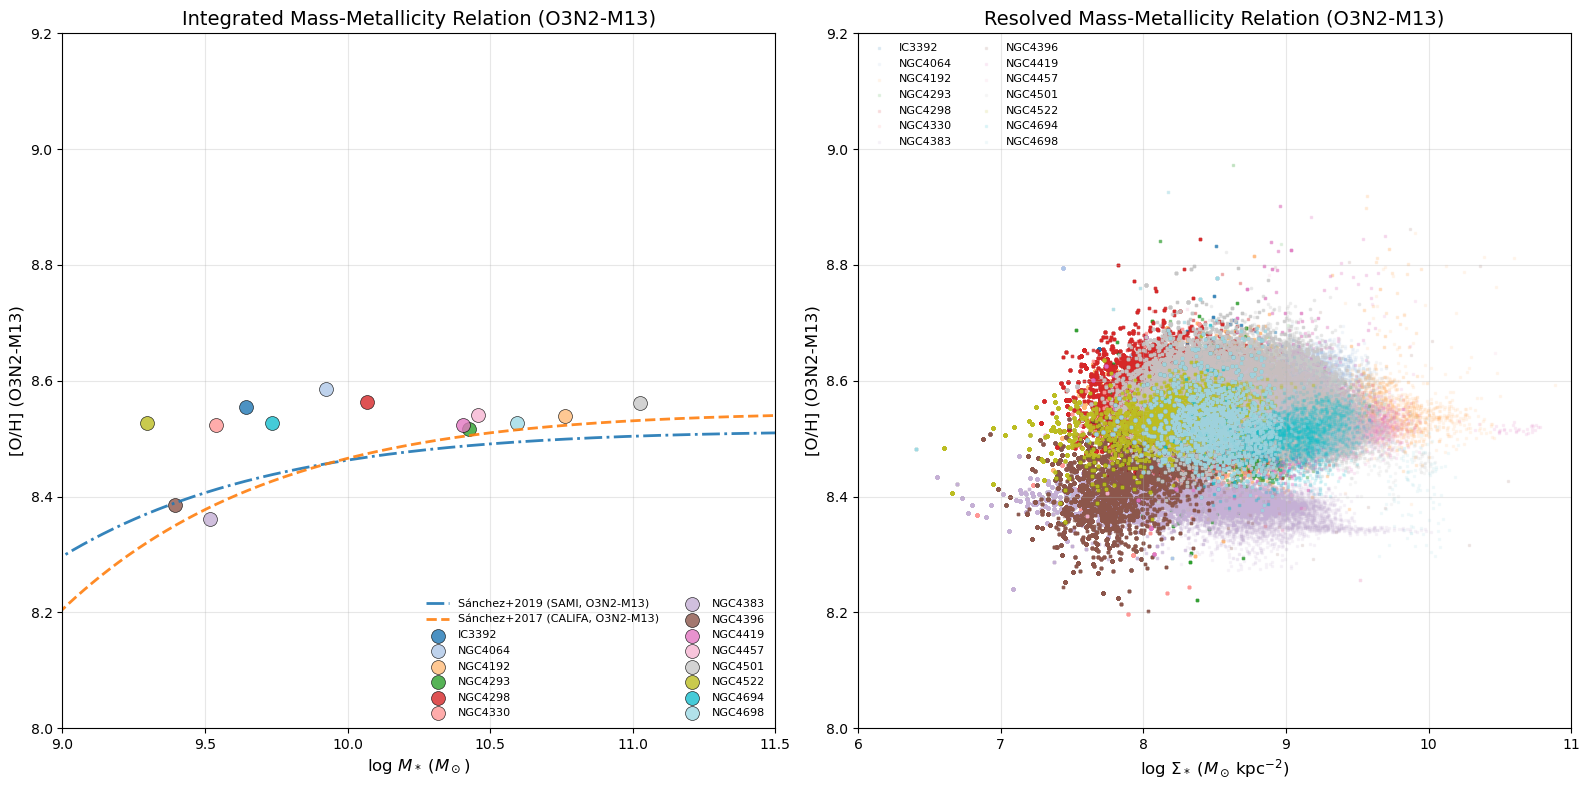

Subplot 1: Plotted 14 galaxies with valid total mass and O3N2-M13 metallicity data
Subplot 2: Plotted spatially-resolved O3N2-M13 MZR data for 14 galaxies


In [5]:
# ------------------------------------------------------------------
# Combined Plot: Integrated MZR (O3N2-M13) + Resolved MZR (O3N2-M13)
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import itertools
from scipy.stats import linregress
from astropy.io import fits

def mzr_tremonti2004(logM):
    logM = np.asarray(logM, dtype=float)
    oh12 = -1.492 + 1.847*logM - 0.08026*(logM**2)
    oh12[(logM < 8.5) | (logM > 11.5)] = np.nan
    return oh12

def mzr_zahid2014(logM, Z0=8.710, logM0=8.76, gamma=0.66):
    logM = np.asarray(logM, dtype=float)
    term = 1.0 + 10.0**(-gamma * (logM - logM0))
    return Z0 - np.log10(term)

def mzr_curti2020(logM, Z0=8.793, logM0=10.02, gamma=0.28, beta=1.2):
    logM = np.asarray(logM, dtype=float)
    term = 1.0 + 10.0**(-beta * (logM - logM0))
    return Z0 - (gamma / beta) * np.log10(term)

def mzr_sanchez2019(logM, a, b, c=3.5):
    logM = np.asarray(logM, dtype=float)
    x = logM - 8.0
    t = x - c
    return a + b * t * np.exp(-t)

S19_PARAMS = {
    "O3N2-M13": dict(a=8.51, b=0.007),
    "PP04"    : dict(a=8.73, b=0.010),
    "N2-M13"  : dict(a=8.50, b=0.008),
    "T04"     : dict(a=8.84, b=0.007),
    "D16"     : dict(a=8.94, b=0.020),  # table’s DOP16 = D16
}

S19_STYLES = {
    "O3N2-M13": "-.",
    "PP04"    : (0, (5, 1.5)),
    "N2-M13"  : ":",
    "T04"     : (0, (3, 1.2, 1, 1.2)),
    "D16"     : "--",
}

# --- NEW: Sánchez+2017 (same functional form as 2019) ---
def mzr_sanchez2017(logM, a, b, c=3.5):
    logM = np.asarray(logM, dtype=float)
    x = logM - 8.0
    t = x - c
    return a + b * t * np.exp(-t)

# --- NEW: Sánchez+2017 (CALIFA) parameters for 5 requested calibrations ---
# CALIFA table labels DOP16; we keep the external key as "D16" for consistency.
S17_PARAMS = {
    "O3N2-M13": dict(a=8.54, b=0.011),
    "PP04"    : dict(a=8.78, b=0.017),
    "N2-M13"  : dict(a=8.54, b=0.013),
    "T04"     : dict(a=8.94, b=0.014),
    "D16"     : dict(a=8.90, b=0.030),  # CALIFA "DOP16"
}

def plot_previous_MZR(ax=None,
                      mass_range=(8.5, 11.5),
                      zahid_params=dict(Z0=8.710, logM0=8.76, gamma=0.66),
                      curti_params=dict(Z0=8.793, logM0=10.02, gamma=0.28, beta=1.2),
                      include=('T04','Z14','C20'),
                      sanchez_calibs=("O3N2-M13", "PP04", "N2-M13", "T04", "D16"),
                      # NEW: off by default to preserve behavior
                      sanchez2017_calibs=(),
                      show_legend=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6.2, 4.8))

    logM = np.linspace(mass_range[0], mass_range[1], 800)

    # === Literature curves ===
    if 'T04' in include:
        ax.plot(logM, mzr_tremonti2004(logM), lw=2,
                label='Tremonti+2004 (SDSS, R23–T04)')
    if 'Z14' in include:
        z = mzr_zahid2014(logM, **zahid_params)
        ax.plot(logM, z, lw=2, ls='--',
                label='Zahid+2014 (SDSS, N2–PP04)')
    if 'C20' in include:
        c = mzr_curti2020(logM, **curti_params)
        ax.plot(logM, c, lw=2, ls=':',
                label='Curti+2020 (SDSS, Combined–C20)')

    # Sánchez+2019 (SAMI)
    for calib in sanchez_calibs:
        if calib not in S19_PARAMS:
            continue
        pars = S19_PARAMS[calib]
        y = mzr_sanchez2019(logM, **pars)
        ls = S19_STYLES.get(calib, "-.")
        ax.plot(logM, y, lw=2, ls=ls, alpha=0.9,
                label=f"Sánchez+2019 (SAMI, {calib})")

    # --- NEW: Sánchez+2017 (CALIFA) optional overlay ---
    for calib in sanchez2017_calibs:
        if calib not in S17_PARAMS:
            continue
        pars = S17_PARAMS[calib]
        y = mzr_sanchez2017(logM, **pars)
        ax.plot(logM, y, lw=2, ls='--', alpha=0.9,
                label=f"Sánchez+2017 (CALIFA, {calib})")

    ax.set_xlim(mass_range)
    ax.set_xlabel(r'$\log_{10}(M_\star/M_\odot)$')
    ax.set_ylabel(r'$12+\log_{10}(\mathrm{O/H})$')
    ax.set_xlim(9, 11.5)
    ax.set_ylim(8.0, 9.2)
    ax.grid(True, alpha=0.3)
    if show_legend:
        ax.legend(frameon=False, ncol=2)
    plt.tight_layout()
    return ax

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ------------------------------------------------------------------
# SUBPLOT 1: Total Stellar Mass vs Total O3N2-M13 Metallicity from log files
# ------------------------------------------------------------------

# Extraction functions for log files
def extract_total_stellar_mass(galaxy_name):
    """Extract total stellar mass from mass log file. Returns log10(M☉) value or None if not found."""
    log_file = Path(f'mass_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total stellar mass \(R\)\s*:\s*([\d.-]+)\s*log10\(M☉\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading mass log for {galaxy_name}: {e}")
        return None

def extract_total_o3n2_m13_metallicity(galaxy_name):
    """Extract total O3N2-M13 metallicity from log file. Returns [O/H] O3N2-M13 value or None if not found."""
    log_file = Path(f'sfr_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'\[O/H\] O3N2-M13 SF: Total metallicity in SF region:\s*([\d.-]+)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading O3N2-M13 metallicity log for {galaxy_name}: {e}")
        return None

# Discover galaxies
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]

# Create galaxy color mapping (consistent for both subplots)
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, len(galaxies)))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

# Extract total masses and O3N2-M13 metallicities
log_masses = []
o3n2_m13_metallicities = []
galaxy_names = []

for gal in galaxies:
    mass = extract_total_stellar_mass(gal)
    metallicity = extract_total_o3n2_m13_metallicity(gal)
    
    if mass is not None and metallicity is not None:
        log_masses.append(mass)
        o3n2_m13_metallicities.append(metallicity)
        galaxy_names.append(gal)

# Convert to numpy arrays
log_masses = np.array(log_masses)
o3n2_m13_metallicities = np.array(o3n2_m13_metallicities)

# Plot reference MZR relations from literature (O3N2-M13-relevant only)
plot_previous_MZR(ax=ax1, show_legend=False, include=(), sanchez_calibs=("O3N2-M13",), sanchez2017_calibs=("O3N2-M13",))

# Plot subplot 1 using consistent colors
for i, (mass, metallicity, gal) in enumerate(zip(log_masses, o3n2_m13_metallicities, galaxy_names)):
    ax1.scatter(mass, metallicity, s=100, c=[galaxy_color_dict[gal]], label=gal, alpha=0.8, 
               edgecolors='black', linewidth=0.5)

# Add labels and formatting for subplot 1
ax1.set_xlabel(r'$\log\,M_* \; (M_\odot)$', fontsize=12)
ax1.set_ylabel(r'[O/H] (O3N2-M13)', fontsize=12)
ax1.set_title('Integrated Mass-Metallicity Relation (O3N2-M13)', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='lower right', fontsize=8, ncol=2, frameon=False)
ax1.set_xlim(9, 11.5)
ax1.set_ylim(8.0, 9.2)

# ------------------------------------------------------------------
# SUBPLOT 2: Spatially-resolved Σ* vs [O/H] O3N2-M13
# ------------------------------------------------------------------

# Collect all data points for global fit
all_x = []
all_y = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Read FITS extensions
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_o3n2_m13 = hdul['O_H_O3N2_M13_SF'].data  # [O/H] O3N2-M13

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_o3n2_m13)

        # Scatter plot using consistent galaxy colors
        ax2.scatter(
            logSigmaM[good],
            oh_o3n2_m13[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x.extend(logSigmaM[good])
        all_y.extend(oh_o3n2_m13[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Final cosmetics for subplot 2
ax2.set_xlabel(r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax2.set_ylabel(r'[O/H] (O3N2-M13)', fontsize=12)
ax2.set_title(r'Resolved Mass-Metallicity Relation (O3N2-M13)', fontsize=14)
ax2.set_xlim(6, 11)
ax2.set_ylim(8.0, 9.2)
ax2.grid(True, alpha=0.3)
ax2.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

print(f"Subplot 1: Plotted {len(galaxy_names)} galaxies with valid total mass and O3N2-M13 metallicity data")
print(f"Subplot 2: Plotted spatially-resolved O3N2-M13 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")

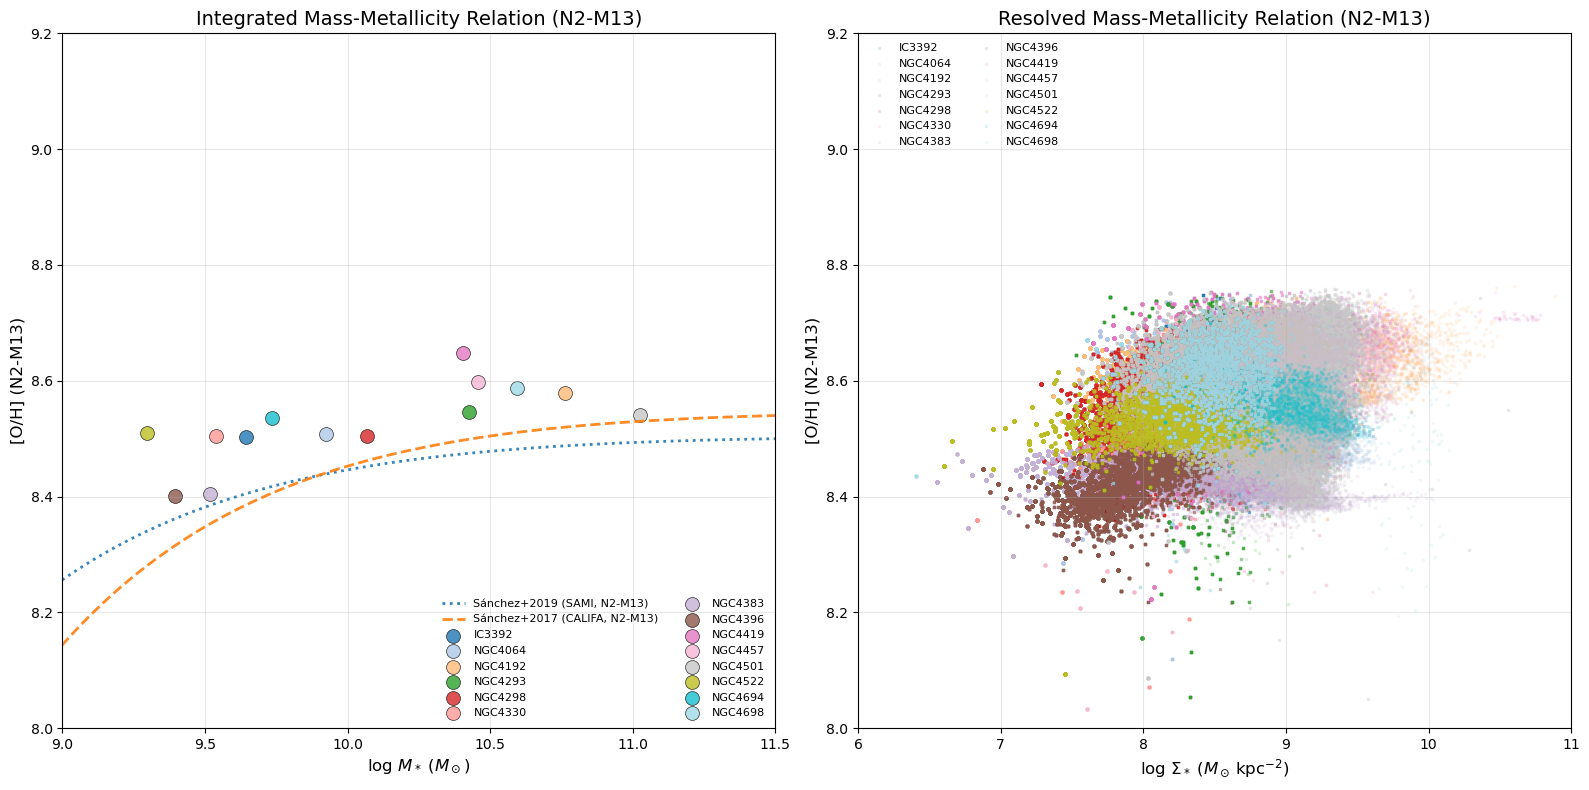

Subplot 1: Plotted 14 galaxies with valid total mass and N2-M13 metallicity data
Subplot 2: Plotted spatially-resolved N2-M13 MZR data for 14 galaxies


In [6]:
# ------------------------------------------------------------------
# Combined Plot: Integrated MZR (N2-M13) + Resolved MZR (N2-M13)
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import itertools
from scipy.stats import linregress
from astropy.io import fits

def mzr_tremonti2004(logM):
    logM = np.asarray(logM, dtype=float)
    oh12 = -1.492 + 1.847*logM - 0.08026*(logM**2)
    oh12[(logM < 8.5) | (logM > 11.5)] = np.nan
    return oh12

def mzr_zahid2014(logM, Z0=8.710, logM0=8.76, gamma=0.66):
    logM = np.asarray(logM, dtype=float)
    term = 1.0 + 10.0**(-gamma * (logM - logM0))
    return Z0 - np.log10(term)

def mzr_curti2020(logM, Z0=8.793, logM0=10.02, gamma=0.28, beta=1.2):
    logM = np.asarray(logM, dtype=float)
    term = 1.0 + 10.0**(-beta * (logM - logM0))
    return Z0 - (gamma / beta) * np.log10(term)

def mzr_sanchez2019(logM, a, b, c=3.5):
    logM = np.asarray(logM, dtype=float)
    x = logM - 8.0
    t = x - c
    return a + b * t * np.exp(-t)

S19_PARAMS = {
    "O3N2-M13": dict(a=8.51, b=0.007),
    "PP04"    : dict(a=8.73, b=0.010),
    "N2-M13"  : dict(a=8.50, b=0.008),
    "T04"     : dict(a=8.84, b=0.007),
    "D16"     : dict(a=8.94, b=0.020),  # table’s DOP16 = D16
}

S19_STYLES = {
    "O3N2-M13": "-.",
    "PP04"    : (0, (5, 1.5)),
    "N2-M13"  : ":",
    "T04"     : (0, (3, 1.2, 1, 1.2)),
    "D16"     : "--",
}

# --- NEW: Sánchez+2017 (same functional form as 2019) ---
def mzr_sanchez2017(logM, a, b, c=3.5):
    logM = np.asarray(logM, dtype=float)
    x = logM - 8.0
    t = x - c
    return a + b * t * np.exp(-t)

# --- NEW: Sánchez+2017 (CALIFA) parameters for 5 requested calibrations ---
# CALIFA table labels DOP16; we keep the external key as "D16" for consistency.
S17_PARAMS = {
    "O3N2-M13": dict(a=8.54, b=0.011),
    "PP04"    : dict(a=8.78, b=0.017),
    "N2-M13"  : dict(a=8.54, b=0.013),
    "T04"     : dict(a=8.94, b=0.014),
    "D16"     : dict(a=8.90, b=0.030),  # CALIFA "DOP16"
}

def plot_previous_MZR(ax=None,
                      mass_range=(8.5, 11.5),
                      zahid_params=dict(Z0=8.710, logM0=8.76, gamma=0.66),
                      curti_params=dict(Z0=8.793, logM0=10.02, gamma=0.28, beta=1.2),
                      include=('T04','Z14','C20'),
                      sanchez_calibs=("O3N2-M13", "PP04", "N2-M13", "T04", "D16"),
                      # NEW: off by default to preserve behavior
                      sanchez2017_calibs=(),
                      show_legend=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6.2, 4.8))

    logM = np.linspace(mass_range[0], mass_range[1], 800)

    # === Literature curves ===
    if 'T04' in include:
        ax.plot(logM, mzr_tremonti2004(logM), lw=2,
                label='Tremonti+2004 (SDSS, R23–T04)')
    if 'Z14' in include:
        z = mzr_zahid2014(logM, **zahid_params)
        ax.plot(logM, z, lw=2, ls='--',
                label='Zahid+2014 (SDSS, N2–PP04)')
    if 'C20' in include:
        c = mzr_curti2020(logM, **curti_params)
        ax.plot(logM, c, lw=2, ls=':',
                label='Curti+2020 (SDSS, Combined–C20)')

    # Sánchez+2019 (SAMI)
    for calib in sanchez_calibs:
        if calib not in S19_PARAMS:
            continue
        pars = S19_PARAMS[calib]
        y = mzr_sanchez2019(logM, **pars)
        ls = S19_STYLES.get(calib, "-.")
        ax.plot(logM, y, lw=2, ls=ls, alpha=0.9,
                label=f"Sánchez+2019 (SAMI, {calib})")

    # --- NEW: Sánchez+2017 (CALIFA) optional overlay ---
    for calib in sanchez2017_calibs:
        if calib not in S17_PARAMS:
            continue
        pars = S17_PARAMS[calib]
        y = mzr_sanchez2017(logM, **pars)
        ax.plot(logM, y, lw=2, ls='--', alpha=0.9,
                label=f"Sánchez+2017 (CALIFA, {calib})")

    ax.set_xlim(mass_range)
    ax.set_xlabel(r'$\log_{10}(M_\star/M_\odot)$')
    ax.set_ylabel(r'$12+\log_{10}(\mathrm{O/H})$')
    ax.set_xlim(9, 11.5)
    ax.set_ylim(8.0, 9.2)
    ax.grid(True, alpha=0.3)
    if show_legend:
        ax.legend(frameon=False, ncol=2)
    plt.tight_layout()
    return ax

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ------------------------------------------------------------------
# SUBPLOT 1: Total Stellar Mass vs Total N2-M13 Metallicity from log files
# ------------------------------------------------------------------

# Extraction functions for log files
def extract_total_stellar_mass(galaxy_name):
    """Extract total stellar mass from mass log file. Returns log10(M☉) value or None if not found."""
    log_file = Path(f'mass_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total stellar mass \(R\)\s*:\s*([\d.-]+)\s*log10\(M☉\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading mass log for {galaxy_name}: {e}")
        return None

def extract_total_n2_m13_metallicity(galaxy_name):
    """Extract total N2-M13 metallicity from log file. Returns [O/H] N2-M13 value or None if not found."""
    log_file = Path(f'sfr_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'\[O/H\] N2-M13 SF: Total metallicity in SF region:\s*([\d.-]+)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading N2-M13 metallicity log for {galaxy_name}: {e}")
        return None

# Discover galaxies
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]

# Create galaxy color mapping (consistent for both subplots)
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, len(galaxies)))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

# Extract total masses and N2-M13 metallicities
log_masses = []
n2_m13_metallicities = []
galaxy_names = []

for gal in galaxies:
    mass = extract_total_stellar_mass(gal)
    metallicity = extract_total_n2_m13_metallicity(gal)
    
    if mass is not None and metallicity is not None:
        log_masses.append(mass)
        n2_m13_metallicities.append(metallicity)
        galaxy_names.append(gal)

# Convert to numpy arrays
log_masses = np.array(log_masses)
n2_m13_metallicities = np.array(n2_m13_metallicities)

# Plot reference MZR relations from literature (N2-M13-relevant only)
plot_previous_MZR(ax=ax1, show_legend=False, include=(), sanchez_calibs=("N2-M13",), sanchez2017_calibs=("N2-M13",))

# Plot subplot 1 using consistent colors
for i, (mass, metallicity, gal) in enumerate(zip(log_masses, n2_m13_metallicities, galaxy_names)):
    ax1.scatter(mass, metallicity, s=100, c=[galaxy_color_dict[gal]], label=gal, alpha=0.8, 
               edgecolors='black', linewidth=0.5)

# Add labels and formatting for subplot 1
ax1.set_xlabel(r'$\log\,M_* \; (M_\odot)$', fontsize=12)
ax1.set_ylabel(r'[O/H] (N2-M13)', fontsize=12)
ax1.set_title('Integrated Mass-Metallicity Relation (N2-M13)', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='lower right', fontsize=8, ncol=2, frameon=False)
ax1.set_xlim(9, 11.5)
ax1.set_ylim(8.0, 9.2)

# ------------------------------------------------------------------
# SUBPLOT 2: Spatially-resolved Σ* vs [O/H] N2-M13
# ------------------------------------------------------------------

# Collect all data points for global fit
all_x = []
all_y = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Read FITS extensions
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_n2_m13 = hdul['O_H_N2_M13_SF'].data  # [O/H] N2-M13

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_n2_m13)

        # Scatter plot using consistent galaxy colors
        ax2.scatter(
            logSigmaM[good],
            oh_n2_m13[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x.extend(logSigmaM[good])
        all_y.extend(oh_n2_m13[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Final cosmetics for subplot 2
ax2.set_xlabel(r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax2.set_ylabel(r'[O/H] (N2-M13)', fontsize=12)
ax2.set_title(r'Resolved Mass-Metallicity Relation (N2-M13)', fontsize=14)
ax2.set_xlim(6, 11)
ax2.set_ylim(8.0, 9.2)
ax2.grid(True, alpha=0.3)
ax2.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

print(f"Subplot 1: Plotted {len(galaxy_names)} galaxies with valid total mass and N2-M13 metallicity data")
print(f"Subplot 2: Plotted spatially-resolved N2-M13 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")

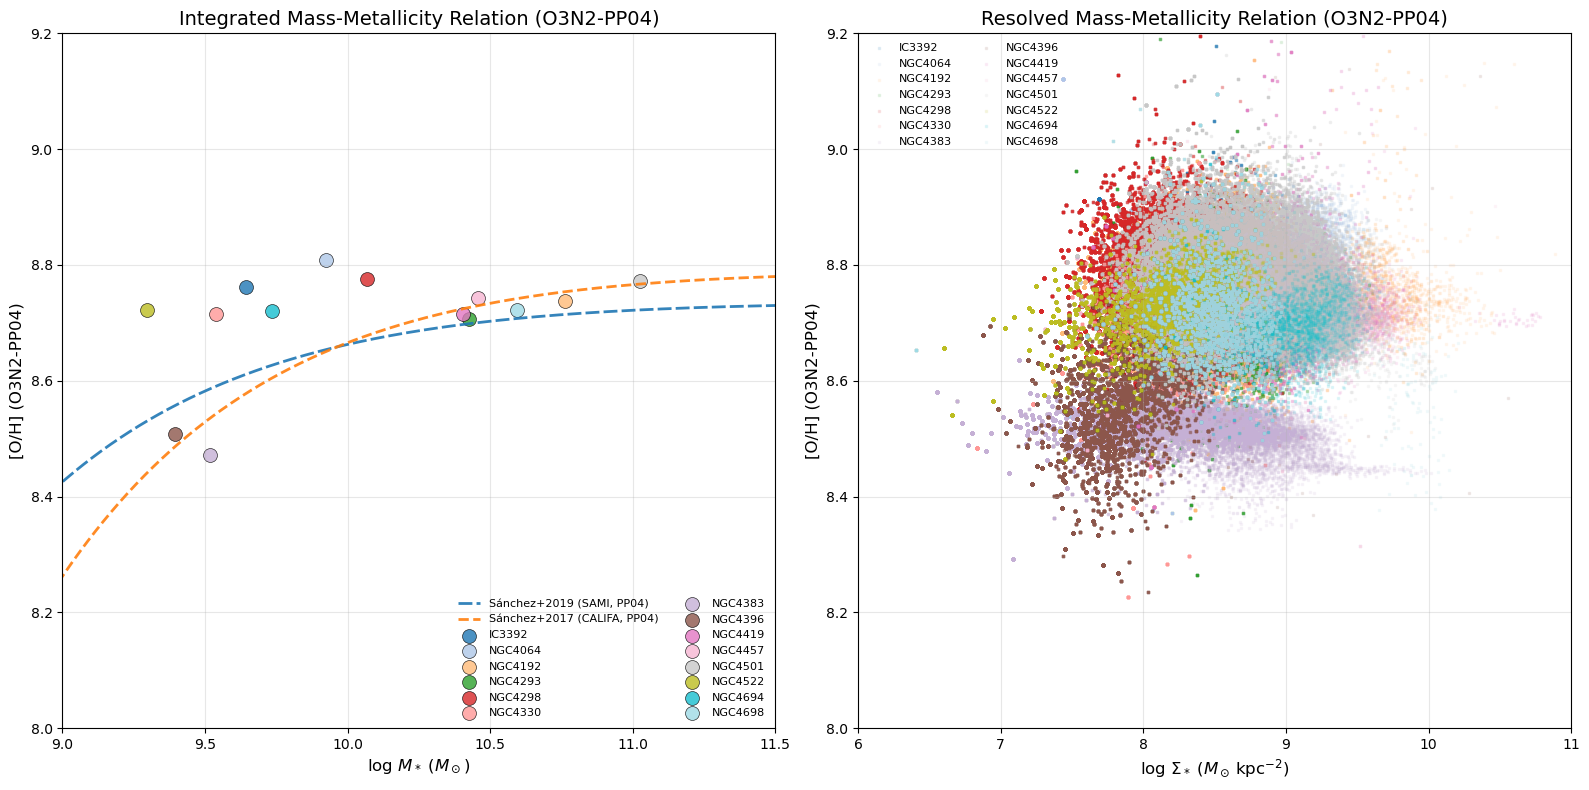

Subplot 1: Plotted 14 galaxies with valid total mass and O3N2-PP04 metallicity data
Subplot 2: Plotted spatially-resolved O3N2-PP04 MZR data for 14 galaxies


In [7]:
# ------------------------------------------------------------------
# Combined Plot: Integrated MZR (O3N2-PP04) + Resolved MZR (O3N2-PP04)
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import itertools
from scipy.stats import linregress
from astropy.io import fits

def mzr_tremonti2004(logM):
    logM = np.asarray(logM, dtype=float)
    oh12 = -1.492 + 1.847*logM - 0.08026*(logM**2)
    oh12[(logM < 8.5) | (logM > 11.5)] = np.nan
    return oh12

def mzr_zahid2014(logM, Z0=8.710, logM0=8.76, gamma=0.66):
    logM = np.asarray(logM, dtype=float)
    term = 1.0 + 10.0**(-gamma * (logM - logM0))
    return Z0 - np.log10(term)

def mzr_curti2020(logM, Z0=8.793, logM0=10.02, gamma=0.28, beta=1.2):
    logM = np.asarray(logM, dtype=float)
    term = 1.0 + 10.0**(-beta * (logM - logM0))
    return Z0 - (gamma / beta) * np.log10(term)

def mzr_sanchez2019(logM, a, b, c=3.5):
    logM = np.asarray(logM, dtype=float)
    x = logM - 8.0
    t = x - c
    return a + b * t * np.exp(-t)

S19_PARAMS = {
    "O3N2-M13": dict(a=8.51, b=0.007),
    "PP04"    : dict(a=8.73, b=0.010),
    "N2-M13"  : dict(a=8.50, b=0.008),
    "T04"     : dict(a=8.84, b=0.007),
    "D16"     : dict(a=8.94, b=0.020),  # table’s DOP16 = D16
}

S19_STYLES = {
    "O3N2-M13": "-.",
    "PP04"    : (0, (5, 1.5)),
    "N2-M13"  : ":",
    "T04"     : (0, (3, 1.2, 1, 1.2)),
    "D16"     : "--",
}

# --- NEW: Sánchez+2017 (same functional form as 2019) ---
def mzr_sanchez2017(logM, a, b, c=3.5):
    logM = np.asarray(logM, dtype=float)
    x = logM - 8.0
    t = x - c
    return a + b * t * np.exp(-t)

# --- NEW: Sánchez+2017 (CALIFA) parameters for 5 requested calibrations ---
# CALIFA table labels DOP16; we keep the external key as "D16" for consistency.
S17_PARAMS = {
    "O3N2-M13": dict(a=8.54, b=0.011),
    "PP04"    : dict(a=8.78, b=0.017),
    "N2-M13"  : dict(a=8.54, b=0.013),
    "T04"     : dict(a=8.94, b=0.014),
    "D16"     : dict(a=8.90, b=0.030),  # CALIFA "DOP16"
}

def plot_previous_MZR(ax=None,
                      mass_range=(8.5, 11.5),
                      zahid_params=dict(Z0=8.710, logM0=8.76, gamma=0.66),
                      curti_params=dict(Z0=8.793, logM0=10.02, gamma=0.28, beta=1.2),
                      include=('T04','Z14','C20'),
                      sanchez_calibs=("O3N2-M13", "PP04", "N2-M13", "T04", "D16"),
                      # NEW: off by default to preserve behavior
                      sanchez2017_calibs=(),
                      show_legend=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6.2, 4.8))

    logM = np.linspace(mass_range[0], mass_range[1], 800)

    # === Literature curves ===
    if 'T04' in include:
        ax.plot(logM, mzr_tremonti2004(logM), lw=2,
                label='Tremonti+2004 (SDSS, R23–T04)')
    if 'Z14' in include:
        z = mzr_zahid2014(logM, **zahid_params)
        ax.plot(logM, z, lw=2, ls='--',
                label='Zahid+2014 (SDSS, N2–PP04)')
    if 'C20' in include:
        c = mzr_curti2020(logM, **curti_params)
        ax.plot(logM, c, lw=2, ls=':',
                label='Curti+2020 (SDSS, Combined–C20)')

    # Sánchez+2019 (SAMI)
    for calib in sanchez_calibs:
        if calib not in S19_PARAMS:
            continue
        pars = S19_PARAMS[calib]
        y = mzr_sanchez2019(logM, **pars)
        ls = S19_STYLES.get(calib, "-.")
        ax.plot(logM, y, lw=2, ls=ls, alpha=0.9,
                label=f"Sánchez+2019 (SAMI, {calib})")

    # --- NEW: Sánchez+2017 (CALIFA) optional overlay ---
    for calib in sanchez2017_calibs:
        if calib not in S17_PARAMS:
            continue
        pars = S17_PARAMS[calib]
        y = mzr_sanchez2017(logM, **pars)
        ax.plot(logM, y, lw=2, ls='--', alpha=0.9,
                label=f"Sánchez+2017 (CALIFA, {calib})")

    ax.set_xlim(mass_range)
    ax.set_xlabel(r'$\log_{10}(M_\star/M_\odot)$')
    ax.set_ylabel(r'$12+\log_{10}(\mathrm{O/H})$')
    ax.set_xlim(9, 11.5)
    ax.set_ylim(8.0, 9.2)
    ax.grid(True, alpha=0.3)
    if show_legend:
        ax.legend(frameon=False, ncol=2)
    plt.tight_layout()
    return ax

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ------------------------------------------------------------------
# SUBPLOT 1: Total Stellar Mass vs Total O3N2-PP04 Metallicity from log files
# ------------------------------------------------------------------

# Extraction functions for log files
def extract_total_stellar_mass(galaxy_name):
    """Extract total stellar mass from mass log file. Returns log10(M☉) value or None if not found."""
    log_file = Path(f'mass_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total stellar mass \(R\)\s*:\s*([\d.-]+)\s*log10\(M☉\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading mass log for {galaxy_name}: {e}")
        return None

def extract_total_o3n2_pp04_metallicity(galaxy_name):
    """Extract total O3N2-PP04 metallicity from log file. Returns [O/H] O3N2-PP04 value or None if not found."""
    log_file = Path(f'sfr_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'\[O/H\] O3N2-PP04 SF: Total metallicity in SF region:\s*([\d.-]+)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading O3N2-PP04 metallicity log for {galaxy_name}: {e}")
        return None

# Discover galaxies
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]

# Create galaxy color mapping (consistent for both subplots)
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, len(galaxies)))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

# Extract total masses and O3N2-PP04 metallicities
log_masses = []
o3n2_pp04_metallicities = []
galaxy_names = []

for gal in galaxies:
    mass = extract_total_stellar_mass(gal)
    metallicity = extract_total_o3n2_pp04_metallicity(gal)
    
    if mass is not None and metallicity is not None:
        log_masses.append(mass)
        o3n2_pp04_metallicities.append(metallicity)
        galaxy_names.append(gal)

# Convert to numpy arrays
log_masses = np.array(log_masses)
o3n2_pp04_metallicities = np.array(o3n2_pp04_metallicities)

# Plot reference MZR relations from literature (O3N2-PP04-relevant only)
plot_previous_MZR(ax=ax1, show_legend=False, include=(), sanchez_calibs=("PP04",), sanchez2017_calibs=("PP04",))

# Plot subplot 1 using consistent colors
for i, (mass, metallicity, gal) in enumerate(zip(log_masses, o3n2_pp04_metallicities, galaxy_names)):
    ax1.scatter(mass, metallicity, s=100, c=[galaxy_color_dict[gal]], label=gal, alpha=0.8, 
               edgecolors='black', linewidth=0.5)

# Add labels and formatting for subplot 1
ax1.set_xlabel(r'$\log\,M_* \; (M_\odot)$', fontsize=12)
ax1.set_ylabel(r'[O/H] (O3N2-PP04)', fontsize=12)
ax1.set_title('Integrated Mass-Metallicity Relation (O3N2-PP04)', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='lower right', fontsize=8, ncol=2, frameon=False)
ax1.set_xlim(9, 11.5)
ax1.set_ylim(8.0, 9.2)

# ------------------------------------------------------------------
# SUBPLOT 2: Spatially-resolved Σ* vs [O/H] O3N2-PP04
# ------------------------------------------------------------------

# Collect all data points for global fit
all_x = []
all_y = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Read FITS extensions
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_o3n2_pp04 = hdul['O_H_O3N2_PP04_SF'].data  # [O/H] O3N2-PP04

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_o3n2_pp04)

        # Scatter plot using consistent galaxy colors
        ax2.scatter(
            logSigmaM[good],
            oh_o3n2_pp04[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x.extend(logSigmaM[good])
        all_y.extend(oh_o3n2_pp04[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Final cosmetics for subplot 2
ax2.set_xlabel(r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax2.set_ylabel(r'[O/H] (O3N2-PP04)', fontsize=12)
ax2.set_title(r'Resolved Mass-Metallicity Relation (O3N2-PP04)', fontsize=14)
ax2.set_xlim(6, 11)
ax2.set_ylim(8.0, 9.2)
ax2.grid(True, alpha=0.3)
ax2.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

print(f"Subplot 1: Plotted {len(galaxy_names)} galaxies with valid total mass and O3N2-PP04 metallicity data")
print(f"Subplot 2: Plotted spatially-resolved O3N2-PP04 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")

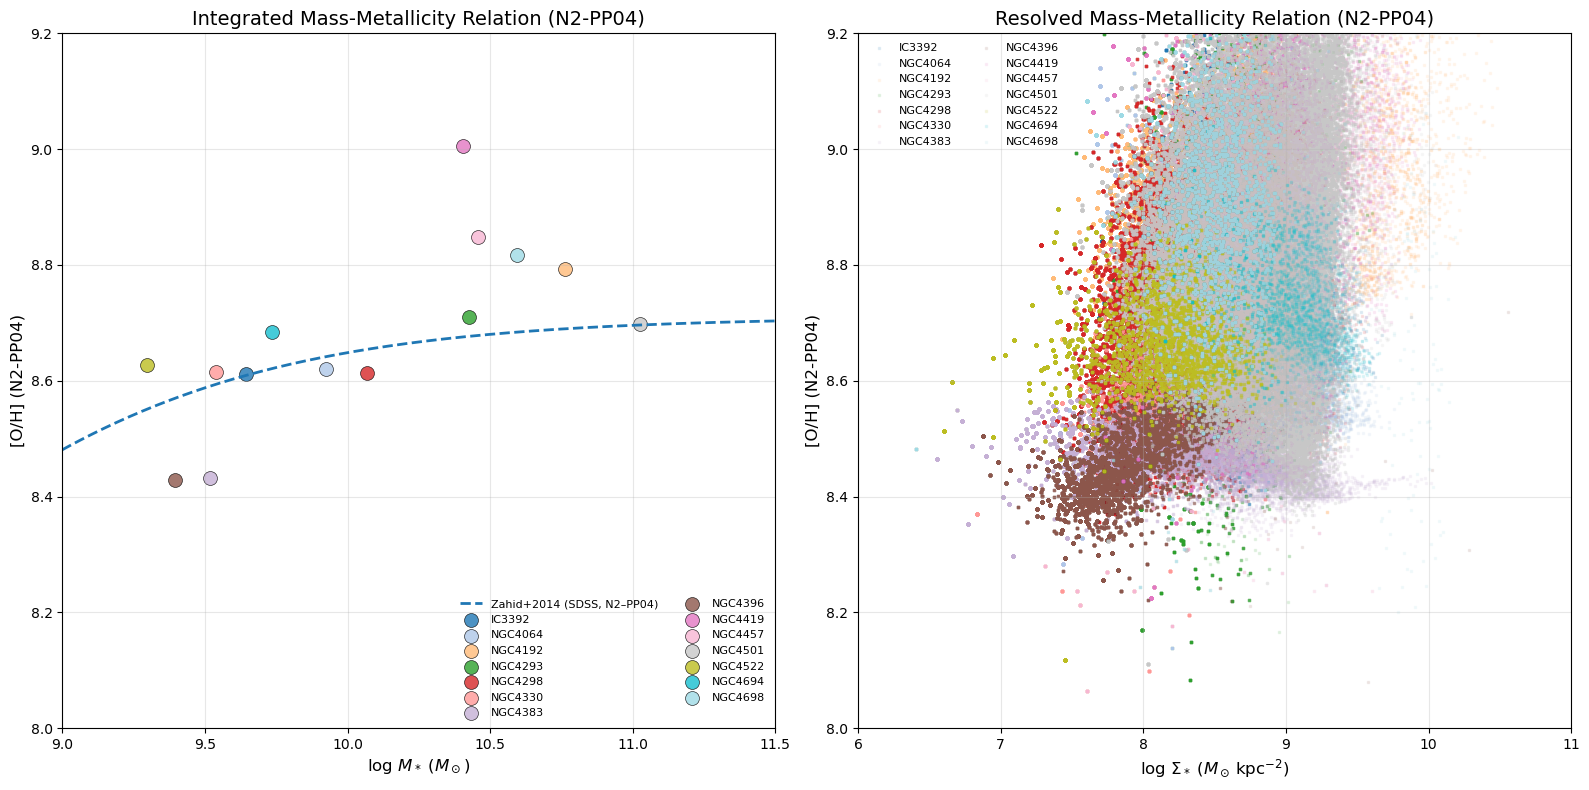

Subplot 1: Plotted 14 galaxies with valid total mass and N2-PP04 metallicity data
Subplot 2: Plotted spatially-resolved N2-PP04 MZR data for 14 galaxies


In [8]:
# ------------------------------------------------------------------
# Combined Plot: Integrated MZR (N2-PP04) + Resolved MZR (N2-PP04)
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import itertools
from scipy.stats import linregress
from astropy.io import fits

def mzr_tremonti2004(logM):
    logM = np.asarray(logM, dtype=float)
    oh12 = -1.492 + 1.847*logM - 0.08026*(logM**2)
    oh12[(logM < 8.5) | (logM > 11.5)] = np.nan
    return oh12

def mzr_zahid2014(logM, Z0=8.710, logM0=8.76, gamma=0.66):
    logM = np.asarray(logM, dtype=float)
    term = 1.0 + 10.0**(-gamma * (logM - logM0))
    return Z0 - np.log10(term)

def mzr_curti2020(logM, Z0=8.793, logM0=10.02, gamma=0.28, beta=1.2):
    logM = np.asarray(logM, dtype=float)
    term = 1.0 + 10.0**(-beta * (logM - logM0))
    return Z0 - (gamma / beta) * np.log10(term)

def mzr_sanchez2019(logM, a, b, c=3.5):
    logM = np.asarray(logM, dtype=float)
    x = logM - 8.0
    t = x - c
    return a + b * t * np.exp(-t)

S19_PARAMS = {
    "O3N2-M13": dict(a=8.51, b=0.007),
    "PP04"    : dict(a=8.73, b=0.010),
    "N2-M13"  : dict(a=8.50, b=0.008),
    "T04"     : dict(a=8.84, b=0.007),
    "D16"     : dict(a=8.94, b=0.020),  # table’s DOP16 = D16
}

S19_STYLES = {
    "O3N2-M13": "-.",
    "PP04"    : (0, (5, 1.5)),
    "N2-M13"  : ":",
    "T04"     : (0, (3, 1.2, 1, 1.2)),
    "D16"     : "--",
}

# --- NEW: Sánchez+2017 (same functional form as 2019) ---
def mzr_sanchez2017(logM, a, b, c=3.5):
    logM = np.asarray(logM, dtype=float)
    x = logM - 8.0
    t = x - c
    return a + b * t * np.exp(-t)

# --- NEW: Sánchez+2017 (CALIFA) parameters for 5 requested calibrations ---
# CALIFA table labels DOP16; we keep the external key as "D16" for consistency.
S17_PARAMS = {
    "O3N2-M13": dict(a=8.54, b=0.011),
    "PP04"    : dict(a=8.78, b=0.017),
    "N2-M13"  : dict(a=8.54, b=0.013),
    "T04"     : dict(a=8.94, b=0.014),
    "D16"     : dict(a=8.90, b=0.030),  # CALIFA "DOP16"
}

def plot_previous_MZR(ax=None,
                      mass_range=(8.5, 11.5),
                      zahid_params=dict(Z0=8.710, logM0=8.76, gamma=0.66),
                      curti_params=dict(Z0=8.793, logM0=10.02, gamma=0.28, beta=1.2),
                      include=('T04','Z14','C20'),
                      sanchez_calibs=("O3N2-M13", "PP04", "N2-M13", "T04", "D16"),
                      # NEW: off by default to preserve behavior
                      sanchez2017_calibs=(),
                      show_legend=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6.2, 4.8))

    logM = np.linspace(mass_range[0], mass_range[1], 800)

    # === Literature curves ===
    if 'T04' in include:
        ax.plot(logM, mzr_tremonti2004(logM), lw=2,
                label='Tremonti+2004 (SDSS, R23–T04)')
    if 'Z14' in include:
        z = mzr_zahid2014(logM, **zahid_params)
        ax.plot(logM, z, lw=2, ls='--',
                label='Zahid+2014 (SDSS, N2–PP04)')
    if 'C20' in include:
        c = mzr_curti2020(logM, **curti_params)
        ax.plot(logM, c, lw=2, ls=':',
                label='Curti+2020 (SDSS, Combined–C20)')

    # Sánchez+2019 (SAMI)
    for calib in sanchez_calibs:
        if calib not in S19_PARAMS:
            continue
        pars = S19_PARAMS[calib]
        y = mzr_sanchez2019(logM, **pars)
        ls = S19_STYLES.get(calib, "-.")
        ax.plot(logM, y, lw=2, ls=ls, alpha=0.9,
                label=f"Sánchez+2019 (SAMI, {calib})")

    # --- NEW: Sánchez+2017 (CALIFA) optional overlay ---
    for calib in sanchez2017_calibs:
        if calib not in S17_PARAMS:
            continue
        pars = S17_PARAMS[calib]
        y = mzr_sanchez2017(logM, **pars)
        ax.plot(logM, y, lw=2, ls='--', alpha=0.9,
                label=f"Sánchez+2017 (CALIFA, {calib})")

    ax.set_xlim(mass_range)
    ax.set_xlabel(r'$\log_{10}(M_\star/M_\odot)$')
    ax.set_ylabel(r'$12+\log_{10}(\mathrm{O/H})$')
    ax.set_xlim(9, 11.5)
    ax.set_ylim(8.0, 9.2)
    ax.grid(True, alpha=0.3)
    if show_legend:
        ax.legend(frameon=False, ncol=2)
    plt.tight_layout()
    return ax

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ------------------------------------------------------------------
# SUBPLOT 1: Total Stellar Mass vs Total N2-PP04 Metallicity from log files
# ------------------------------------------------------------------

# Extraction functions for log files
def extract_total_stellar_mass(galaxy_name):
    """Extract total stellar mass from mass log file. Returns log10(M☉) value or None if not found."""
    log_file = Path(f'mass_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total stellar mass \(R\)\s*:\s*([\d.-]+)\s*log10\(M☉\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading mass log for {galaxy_name}: {e}")
        return None

def extract_total_n2_pp04_metallicity(galaxy_name):
    """Extract total N2-PP04 metallicity from log file. Returns [O/H] N2-PP04 value or None if not found."""
    log_file = Path(f'sfr_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'\[O/H\] N2-PP04 SF: Total metallicity in SF region:\s*([\d.-]+)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading N2-PP04 metallicity log for {galaxy_name}: {e}")
        return None

# Discover galaxies
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]

# Create galaxy color mapping (consistent for both subplots)
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, len(galaxies)))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

# Extract total masses and N2-PP04 metallicities
log_masses = []
n2_pp04_metallicities = []
galaxy_names = []

for gal in galaxies:
    mass = extract_total_stellar_mass(gal)
    metallicity = extract_total_n2_pp04_metallicity(gal)
    
    if mass is not None and metallicity is not None:
        log_masses.append(mass)
        n2_pp04_metallicities.append(metallicity)
        galaxy_names.append(gal)

# Convert to numpy arrays
log_masses = np.array(log_masses)
n2_pp04_metallicities = np.array(n2_pp04_metallicities)

# Plot reference MZR relations from literature (N2-PP04-relevant only)
plot_previous_MZR(ax=ax1, show_legend=False, include=('Z14',), sanchez_calibs=(), sanchez2017_calibs=())

# Plot subplot 1 using consistent colors
for i, (mass, metallicity, gal) in enumerate(zip(log_masses, n2_pp04_metallicities, galaxy_names)):
    ax1.scatter(mass, metallicity, s=100, c=[galaxy_color_dict[gal]], label=gal, alpha=0.8, 
               edgecolors='black', linewidth=0.5)

# Add labels and formatting for subplot 1
ax1.set_xlabel(r'$\log\,M_* \; (M_\odot)$', fontsize=12)
ax1.set_ylabel(r'[O/H] (N2-PP04)', fontsize=12)
ax1.set_title('Integrated Mass-Metallicity Relation (N2-PP04)', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='lower right', fontsize=8, ncol=2, frameon=False)
ax1.set_xlim(9, 11.5)
ax1.set_ylim(8.0, 9.2)

# ------------------------------------------------------------------
# SUBPLOT 2: Spatially-resolved Σ* vs [O/H] N2-PP04
# ------------------------------------------------------------------

# Collect all data points for global fit
all_x = []
all_y = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Read FITS extensions
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_n2_pp04 = hdul['O_H_N2_PP04_SF'].data  # [O/H] N2-PP04

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_n2_pp04)

        # Scatter plot using consistent galaxy colors
        ax2.scatter(
            logSigmaM[good],
            oh_n2_pp04[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x.extend(logSigmaM[good])
        all_y.extend(oh_n2_pp04[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Final cosmetics for subplot 2
ax2.set_xlabel(r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax2.set_ylabel(r'[O/H] (N2-PP04)', fontsize=12)
ax2.set_title(r'Resolved Mass-Metallicity Relation (N2-PP04)', fontsize=14)
ax2.set_xlim(6, 11)
ax2.set_ylim(8.0, 9.2)
ax2.grid(True, alpha=0.3)
ax2.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

print(f"Subplot 1: Plotted {len(galaxy_names)} galaxies with valid total mass and N2-PP04 metallicity data")
print(f"Subplot 2: Plotted spatially-resolved N2-PP04 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")

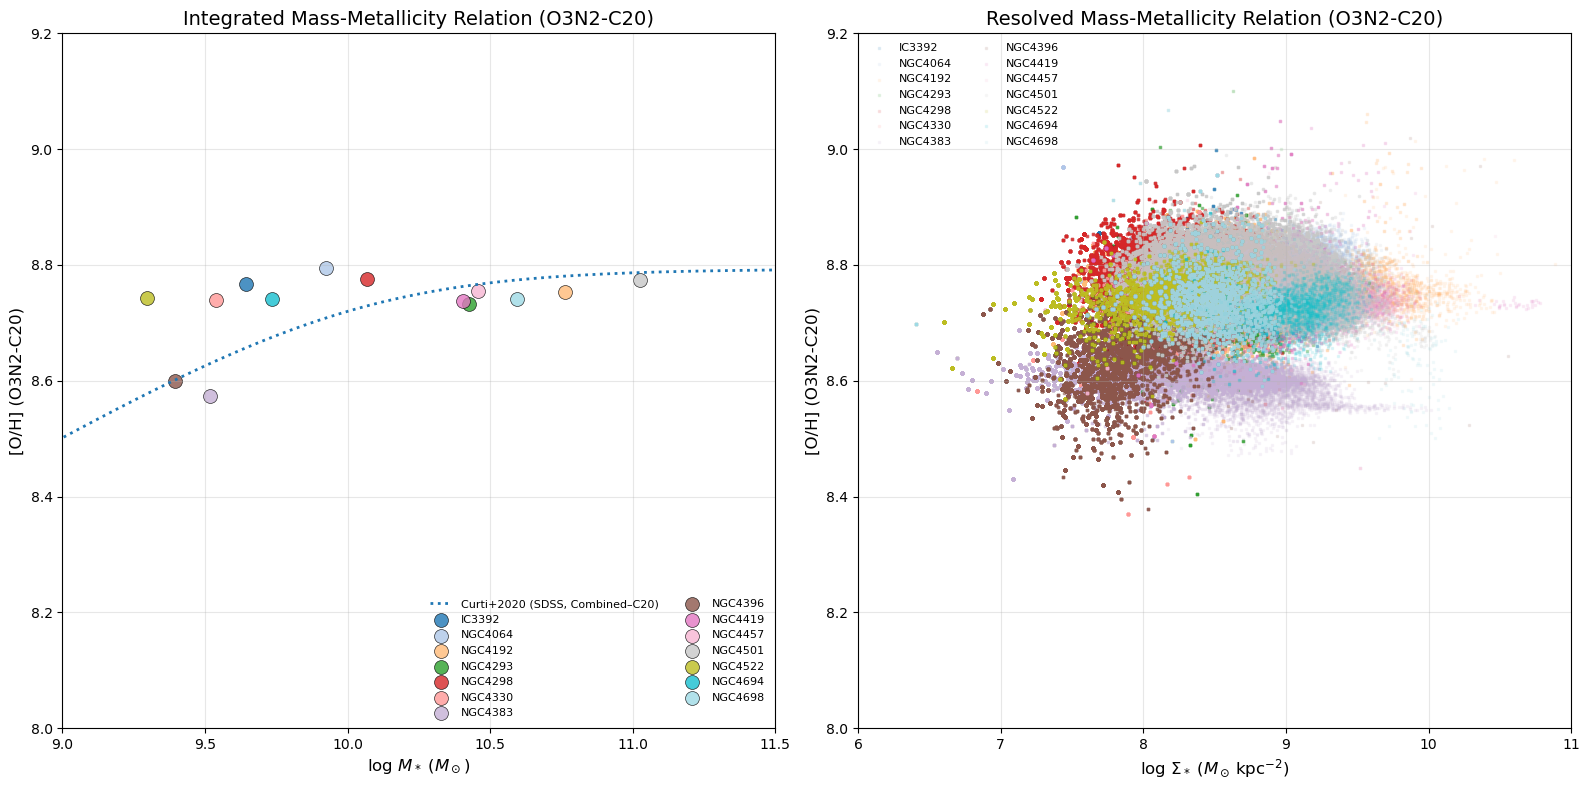

Subplot 1: Plotted 14 galaxies with valid total mass and O3N2-C20 metallicity data
Subplot 2: Plotted spatially-resolved O3N2-C20 MZR data for 14 galaxies


In [9]:
# ------------------------------------------------------------------
# Combined Plot: Integrated MZR (O3N2-C20) + Resolved MZR (O3N2-C20)
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import itertools
from scipy.stats import linregress
from astropy.io import fits

# Define MZR functions from literature
def mzr_tremonti2004(logM):
    logM = np.asarray(logM, dtype=float)
    oh12 = -1.492 + 1.847*logM - 0.08026*(logM**2)
    oh12[(logM < 8.5) | (logM > 11.5)] = np.nan
    return oh12

def mzr_zahid2014(logM, Z0=8.710, logM0=8.76, gamma=0.66):
    logM = np.asarray(logM, dtype=float)
    term = 1.0 + 10.0**(-gamma * (logM - logM0))
    return Z0 - np.log10(term)

def mzr_curti2020(logM, Z0=8.793, logM0=10.02, gamma=0.28, beta=1.2):
    logM = np.asarray(logM, dtype=float)
    term = 1.0 + 10.0**(-beta * (logM - logM0))
    return Z0 - (gamma / beta) * np.log10(term)

def mzr_sanchez2019(logM, a, b, c=3.5):
    logM = np.asarray(logM, dtype=float)
    x = logM - 8.0
    t = x - c
    return a + b * t * np.exp(-t)

S19_PARAMS = {
    "O3N2-M13": dict(a=8.51, b=0.007),
    "PP04"    : dict(a=8.73, b=0.010),
    "N2-M13"  : dict(a=8.50, b=0.008),
    "T04"     : dict(a=8.84, b=0.007),
    "D16"     : dict(a=8.53, b=0.012),
}

S19_STYLES = {
    "O3N2-M13": "-.",
    "PP04": "--", 
    "N2-M13": ":",
    "T04": "-",
    "D16": "-",
}

def plot_previous_MZR(ax=None,
                      mass_range=(8.5, 11.5),
                      zahid_params=dict(Z0=8.710, logM0=8.76, gamma=0.66),
                      curti_params=dict(Z0=8.793, logM0=10.02, gamma=0.28, beta=1.2),
                      include=('T04','Z14','C20'),
                      sanchez_calibs=("O3N2-M13", "PP04", "N2-M13", "T04", "D16"),
                      show_legend=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6.2, 4.8))

    logM = np.linspace(mass_range[0], mass_range[1], 800)

    if 'T04' in include:
        ax.plot(logM, mzr_tremonti2004(logM), lw=2,
                label='Tremonti+2004 (SDSS, R23–T04)')
    if 'Z14' in include:
        z = mzr_zahid2014(logM, **zahid_params)
        ax.plot(logM, z, lw=2, ls='--',
                label='Zahid+2014 (SDSS, N2–PP04)')
    if 'C20' in include:
        c = mzr_curti2020(logM, **curti_params)
        ax.plot(logM, c, lw=2, ls=':',
                label='Curti+2020 (SDSS, Combined–C20)')

    for calib in sanchez_calibs:
        if calib not in S19_PARAMS:
            continue
        pars = S19_PARAMS[calib]
        y = mzr_sanchez2019(logM, **pars)
        ls = S19_STYLES.get(calib, "-.")
        ax.plot(logM, y, lw=2, ls=ls, alpha=0.9,
                label=f"Sánchez+2019 (SAMI, {calib})")

    if show_legend:
        ax.legend(frameon=False, ncol=2)
    return ax

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ------------------------------------------------------------------
# SUBPLOT 1: Total Stellar Mass vs Total O3N2-C20 Metallicity from log files
# ------------------------------------------------------------------

# Extraction functions for log files
def extract_total_stellar_mass(galaxy_name):
    """Extract total stellar mass from mass log file. Returns log10(M☉) value or None if not found."""
    log_file = Path(f'mass_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total stellar mass \(R\)\s*:\s*([\d.-]+)\s*log10\(M☉\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading mass log for {galaxy_name}: {e}")
        return None

def extract_total_o3n2_c20_metallicity(galaxy_name):
    """Extract total O3N2-C20 metallicity from log file. Returns [O/H] O3N2-C20 value or None if not found."""
    log_file = Path(f'sfr_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'\[O/H\] O3N2-C20 SF: Total metallicity in SF region:\s*([\d.-]+)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading O3N2-C20 metallicity log for {galaxy_name}: {e}")
        return None

# Discover galaxies
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]

# Create galaxy color mapping (consistent for both subplots)
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, len(galaxies)))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

# Extract total masses and O3N2-C20 metallicities
log_masses = []
o3n2_c20_metallicities = []
galaxy_names = []

for gal in galaxies:
    mass = extract_total_stellar_mass(gal)
    metallicity = extract_total_o3n2_c20_metallicity(gal)
    
    if mass is not None and metallicity is not None:
        log_masses.append(mass)
        o3n2_c20_metallicities.append(metallicity)
        galaxy_names.append(gal)

# Convert to numpy arrays
log_masses = np.array(log_masses)
o3n2_c20_metallicities = np.array(o3n2_c20_metallicities)

# Plot reference MZR relations from literature (O3N2-C20-relevant only)
plot_previous_MZR(ax=ax1, show_legend=False, include=('C20',), sanchez_calibs=())

# Plot subplot 1 using consistent colors
for i, (mass, metallicity, gal) in enumerate(zip(log_masses, o3n2_c20_metallicities, galaxy_names)):
    ax1.scatter(mass, metallicity, s=100, c=[galaxy_color_dict[gal]], label=gal, alpha=0.8, 
               edgecolors='black', linewidth=0.5)

# Add labels and formatting for subplot 1
ax1.set_xlabel(r'$\log\,M_* \; (M_\odot)$', fontsize=12)
ax1.set_ylabel(r'[O/H] (O3N2-C20)', fontsize=12)
ax1.set_title('Integrated Mass-Metallicity Relation (O3N2-C20)', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='lower right', fontsize=8, ncol=2, frameon=False)
ax1.set_xlim(9, 11.5)
ax1.set_ylim(8.0, 9.2)

# ------------------------------------------------------------------
# SUBPLOT 2: Spatially-resolved Σ* vs [O/H] O3N2-C20
# ------------------------------------------------------------------

# Collect all data points for global fit
all_x = []
all_y = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Read FITS extensions
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_o3n2_c20 = hdul['O_H_O3N2_C20_SF'].data  # [O/H] O3N2-C20

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_o3n2_c20)

        # Scatter plot using consistent galaxy colors
        ax2.scatter(
            logSigmaM[good],
            oh_o3n2_c20[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x.extend(logSigmaM[good])
        all_y.extend(oh_o3n2_c20[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Final cosmetics for subplot 2
ax2.set_xlabel(r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax2.set_ylabel(r'[O/H] (O3N2-C20)', fontsize=12)
ax2.set_title(r'Resolved Mass-Metallicity Relation (O3N2-C20)', fontsize=14)
ax2.set_xlim(6, 11)
ax2.set_ylim(8.0, 9.2)
ax2.grid(True, alpha=0.3)
ax2.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

print(f"Subplot 1: Plotted {len(galaxy_names)} galaxies with valid total mass and O3N2-C20 metallicity data")
print(f"Subplot 2: Plotted spatially-resolved O3N2-C20 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")

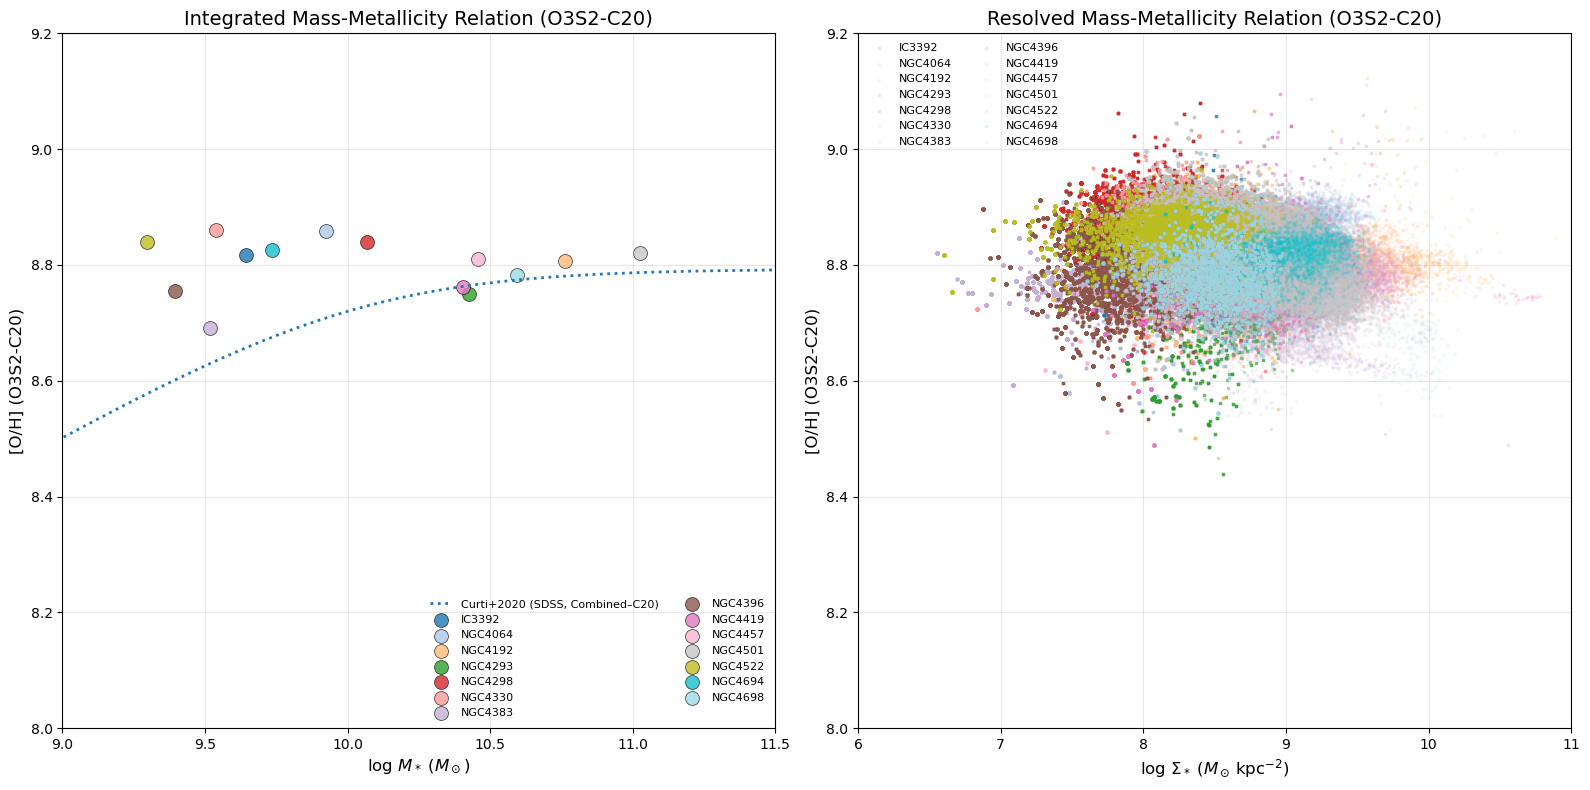

Subplot 1: Plotted 14 galaxies with valid total mass and O3S2-C20 metallicity data
Subplot 2: Plotted spatially-resolved O3S2-C20 MZR data for 14 galaxies


In [10]:
# ------------------------------------------------------------------
# Combined Plot: Integrated MZR (O3S2-C20) + Resolved MZR (O3S2-C20)
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import itertools
from scipy.stats import linregress
from astropy.io import fits

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ------------------------------------------------------------------
# SUBPLOT 1: Total Stellar Mass vs Total O3S2-C20 Metallicity from log files
# ------------------------------------------------------------------

# Extraction functions for log files
def extract_total_stellar_mass(galaxy_name):
    """Extract total stellar mass from mass log file. Returns log10(M☉) value or None if not found."""
    log_file = Path(f'mass_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total stellar mass \(R\)\s*:\s*([\d.-]+)\s*log10\(M☉\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading mass log for {galaxy_name}: {e}")
        return None

def extract_total_o3s2_c20_metallicity(galaxy_name):
    """Extract total O3S2-C20 metallicity from log file. Returns [O/H] O3S2-C20 value or None if not found."""
    log_file = Path(f'sfr_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'\[O/H\] O3S2-C20 SF: Total metallicity in SF region:\s*([\d.-]+)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading O3S2-C20 metallicity log for {galaxy_name}: {e}")
        return None

# Discover galaxies
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]

# Create galaxy color mapping (consistent for both subplots)
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, len(galaxies)))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

# Extract total masses and O3S2-C20 metallicities
log_masses = []
o3s2_c20_metallicities = []
galaxy_names = []

for gal in galaxies:
    mass = extract_total_stellar_mass(gal)
    metallicity = extract_total_o3s2_c20_metallicity(gal)
    
    if mass is not None and metallicity is not None:
        log_masses.append(mass)
        o3s2_c20_metallicities.append(metallicity)
        galaxy_names.append(gal)

# Convert to numpy arrays
log_masses = np.array(log_masses)
o3s2_c20_metallicities = np.array(o3s2_c20_metallicities)

# Plot reference MZR relations from literature (O3S2-C20-relevant only)
plot_previous_MZR(ax=ax1, show_legend=False, include=('C20',), sanchez_calibs=())

# Plot subplot 1 using consistent colors
for i, (mass, metallicity, gal) in enumerate(zip(log_masses, o3s2_c20_metallicities, galaxy_names)):
    ax1.scatter(mass, metallicity, s=100, c=[galaxy_color_dict[gal]], label=gal, alpha=0.8, 
               edgecolors='black', linewidth=0.5)

# Add labels and formatting for subplot 1
ax1.set_xlabel(r'$\log\,M_* \; (M_\odot)$', fontsize=12)
ax1.set_ylabel(r'[O/H] (O3S2-C20)', fontsize=12)
ax1.set_title('Integrated Mass-Metallicity Relation (O3S2-C20)', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='lower right', fontsize=8, ncol=2, frameon=False)
ax1.set_xlim(9, 11.5)
ax1.set_ylim(8.0, 9.2)

# ------------------------------------------------------------------
# SUBPLOT 2: Spatially-resolved Σ* vs [O/H] O3S2-C20
# ------------------------------------------------------------------

# Collect all data points for global fit
all_x = []
all_y = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Read FITS extensions
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_o3s2_c20 = hdul['O_H_O3S2_C20_SF'].data  # [O/H] O3S2-C20

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_o3s2_c20)

        # Scatter plot using consistent galaxy colors
        ax2.scatter(
            logSigmaM[good],
            oh_o3s2_c20[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x.extend(logSigmaM[good])
        all_y.extend(oh_o3s2_c20[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Final cosmetics for subplot 2
ax2.set_xlabel(r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax2.set_ylabel(r'[O/H] (O3S2-C20)', fontsize=12)
ax2.set_title(r'Resolved Mass-Metallicity Relation (O3S2-C20)', fontsize=14)
ax2.set_xlim(6, 11)
ax2.set_ylim(8.0, 9.2)
ax2.grid(True, alpha=0.3)
ax2.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

print(f"Subplot 1: Plotted {len(galaxy_names)} galaxies with valid total mass and O3S2-C20 metallicity data")
print(f"Subplot 2: Plotted spatially-resolved O3S2-C20 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")

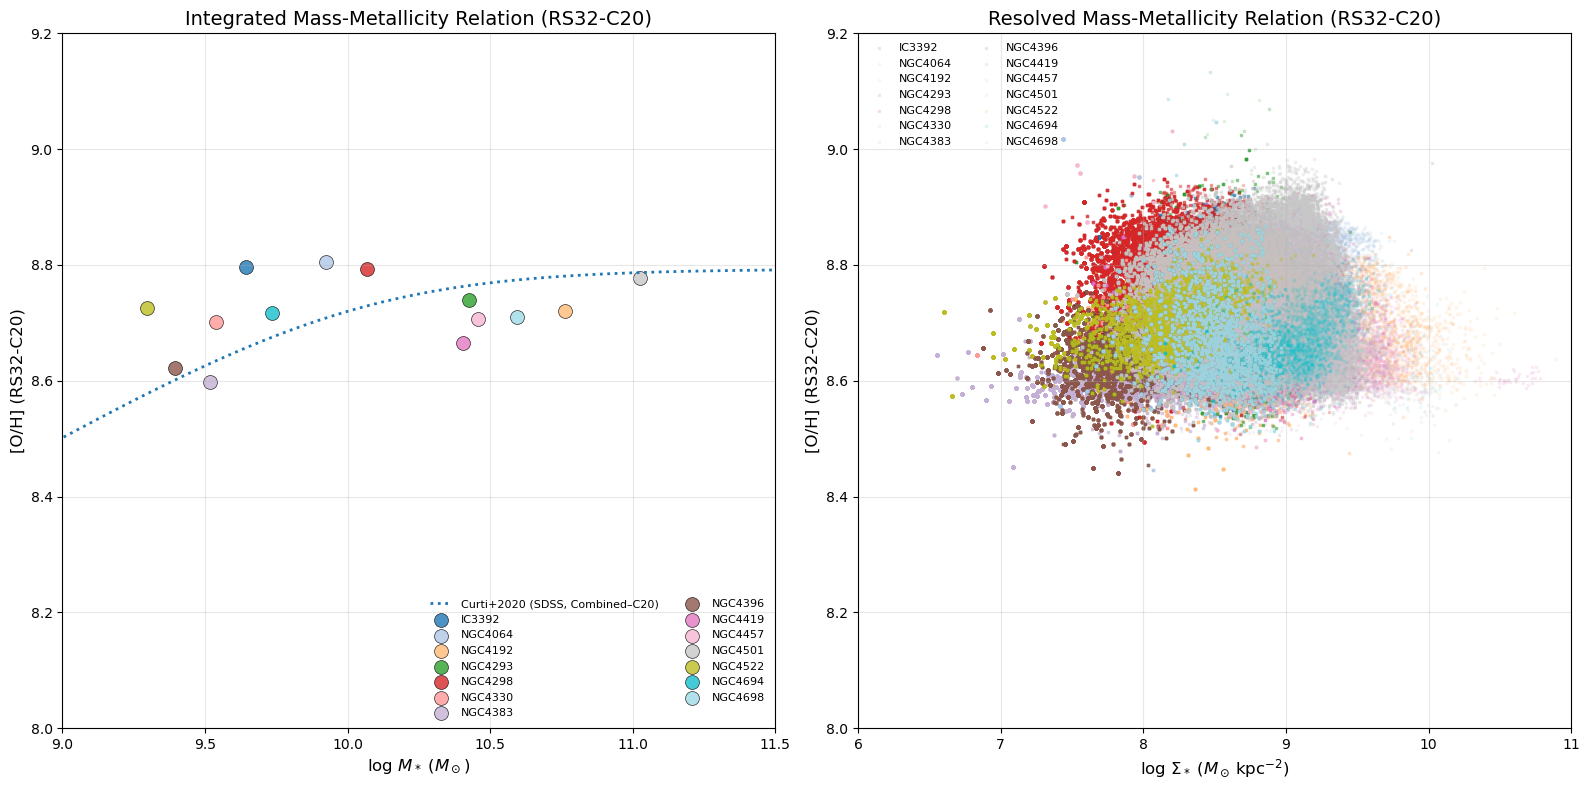

Subplot 1: Plotted 14 galaxies with valid total mass and RS32-C20 metallicity data
Subplot 2: Plotted spatially-resolved RS32-C20 MZR data for 14 galaxies


In [11]:
# ------------------------------------------------------------------
# Combined Plot: Integrated MZR (RS32-C20) + Resolved MZR (RS32-C20)
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import itertools
from scipy.stats import linregress
from astropy.io import fits

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ------------------------------------------------------------------
# SUBPLOT 1: Total Stellar Mass vs Total RS32-C20 Metallicity from log files
# ------------------------------------------------------------------

# Extraction functions for log files
def extract_total_stellar_mass(galaxy_name):
    """Extract total stellar mass from mass log file. Returns log10(M☉) value or None if not found."""
    log_file = Path(f'mass_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total stellar mass \(R\)\s*:\s*([\d.-]+)\s*log10\(M☉\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading mass log for {galaxy_name}: {e}")
        return None

def extract_total_rs32_c20_metallicity(galaxy_name):
    """Extract total RS32-C20 metallicity from log file. Returns [O/H] RS32-C20 value or None if not found."""
    log_file = Path(f'sfr_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'\[O/H\] RS32-C20 SF: Total metallicity in SF region:\s*([\d.-]+)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading RS32-C20 metallicity log for {galaxy_name}: {e}")
        return None

# Discover galaxies
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]

# Create galaxy color mapping (consistent for both subplots)
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, len(galaxies)))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

# Extract total masses and RS32-C20 metallicities
log_masses = []
rs32_c20_metallicities = []
galaxy_names = []

for gal in galaxies:
    mass = extract_total_stellar_mass(gal)
    metallicity = extract_total_rs32_c20_metallicity(gal)
    
    if mass is not None and metallicity is not None:
        log_masses.append(mass)
        rs32_c20_metallicities.append(metallicity)
        galaxy_names.append(gal)

# Convert to numpy arrays
log_masses = np.array(log_masses)
rs32_c20_metallicities = np.array(rs32_c20_metallicities)

# Plot reference MZR relations from literature (RS32-C20-relevant only)
plot_previous_MZR(ax=ax1, show_legend=False, include=('C20',), sanchez_calibs=())

# Plot subplot 1 using consistent colors
for i, (mass, metallicity, gal) in enumerate(zip(log_masses, rs32_c20_metallicities, galaxy_names)):
    ax1.scatter(mass, metallicity, s=100, c=[galaxy_color_dict[gal]], label=gal, alpha=0.8, 
               edgecolors='black', linewidth=0.5)

# Add labels and formatting for subplot 1
ax1.set_xlabel(r'$\log\,M_* \; (M_\odot)$', fontsize=12)
ax1.set_ylabel(r'[O/H] (RS32-C20)', fontsize=12)
ax1.set_title('Integrated Mass-Metallicity Relation (RS32-C20)', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='lower right', fontsize=8, ncol=2, frameon=False)
ax1.set_xlim(9, 11.5)
ax1.set_ylim(8.0, 9.2)

# ------------------------------------------------------------------
# SUBPLOT 2: Spatially-resolved Σ* vs [O/H] RS32-C20
# ------------------------------------------------------------------

# Collect all data points for global fit
all_x = []
all_y = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Read FITS extensions
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_rs32_c20 = hdul['O_H_RS32_C20_SF'].data  # [O/H] RS32-C20

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_rs32_c20)

        # Scatter plot using consistent galaxy colors
        ax2.scatter(
            logSigmaM[good],
            oh_rs32_c20[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x.extend(logSigmaM[good])
        all_y.extend(oh_rs32_c20[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Final cosmetics for subplot 2
ax2.set_xlabel(r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax2.set_ylabel(r'[O/H] (RS32-C20)', fontsize=12)
ax2.set_title(r'Resolved Mass-Metallicity Relation (RS32-C20)', fontsize=14)
ax2.set_xlim(6, 11)
ax2.set_ylim(8.0, 9.2)
ax2.grid(True, alpha=0.3)
ax2.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

print(f"Subplot 1: Plotted {len(galaxy_names)} galaxies with valid total mass and RS32-C20 metallicity data")
print(f"Subplot 2: Plotted spatially-resolved RS32-C20 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")

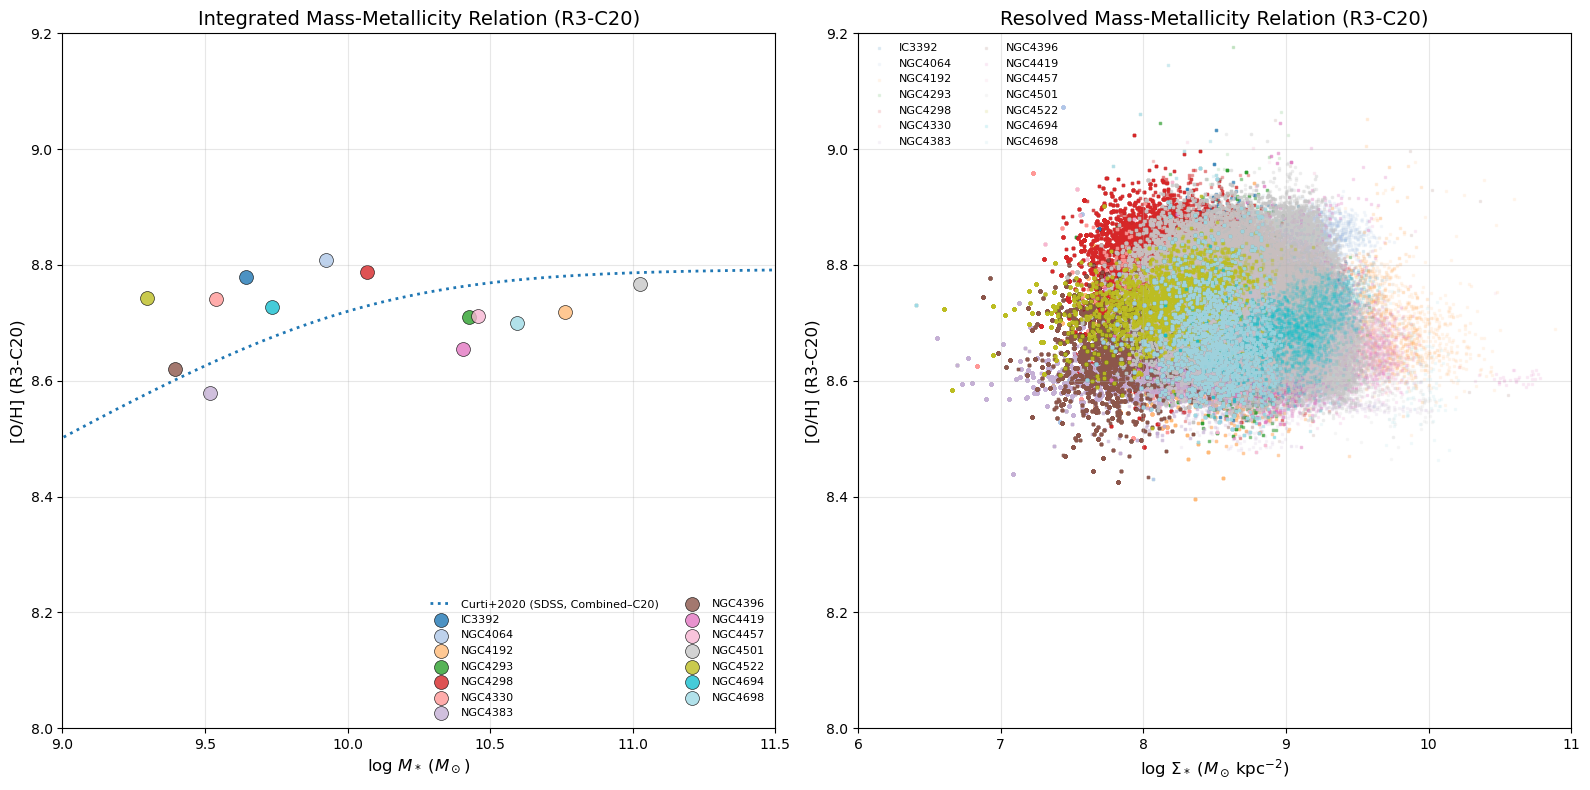

Subplot 1: Plotted 14 galaxies with valid total mass and R3-C20 metallicity data
Subplot 2: Plotted spatially-resolved R3-C20 MZR data for 14 galaxies


In [12]:
# ------------------------------------------------------------------
# Combined Plot: Integrated MZR (R3-C20) + Resolved MZR (R3-C20)
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import itertools
from scipy.stats import linregress
from astropy.io import fits

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ------------------------------------------------------------------
# SUBPLOT 1: Total Stellar Mass vs Total R3-C20 Metallicity from log files
# ------------------------------------------------------------------

# Extraction functions for log files
def extract_total_stellar_mass(galaxy_name):
    """Extract total stellar mass from mass log file. Returns log10(M☉) value or None if not found."""
    log_file = Path(f'mass_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total stellar mass \(R\)\s*:\s*([\d.-]+)\s*log10\(M☉\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading mass log for {galaxy_name}: {e}")
        return None

def extract_total_r3_c20_metallicity(galaxy_name):
    """Extract total R3-C20 metallicity from log file. Returns [O/H] R3-C20 value or None if not found."""
    log_file = Path(f'sfr_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'\[O/H\] R3-C20 SF: Total metallicity in SF region:\s*([\d.-]+)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading R3-C20 metallicity log for {galaxy_name}: {e}")
        return None

# Discover galaxies
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]

# Create galaxy color mapping (consistent for both subplots)
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, len(galaxies)))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

# Extract total masses and R3-C20 metallicities
log_masses = []
r3_c20_metallicities = []
galaxy_names = []

for gal in galaxies:
    mass = extract_total_stellar_mass(gal)
    metallicity = extract_total_r3_c20_metallicity(gal)
    
    if mass is not None and metallicity is not None:
        log_masses.append(mass)
        r3_c20_metallicities.append(metallicity)
        galaxy_names.append(gal)

# Convert to numpy arrays
log_masses = np.array(log_masses)
r3_c20_metallicities = np.array(r3_c20_metallicities)

# Plot reference MZR relations from literature (R3-C20-relevant only)
plot_previous_MZR(ax=ax1, show_legend=False, include=('C20',), sanchez_calibs=())

# Plot subplot 1 using consistent colors
for i, (mass, metallicity, gal) in enumerate(zip(log_masses, r3_c20_metallicities, galaxy_names)):
    ax1.scatter(mass, metallicity, s=100, c=[galaxy_color_dict[gal]], label=gal, alpha=0.8, 
               edgecolors='black', linewidth=0.5)

# Add labels and formatting for subplot 1
ax1.set_xlabel(r'$\log\,M_* \; (M_\odot)$', fontsize=12)
ax1.set_ylabel(r'[O/H] (R3-C20)', fontsize=12)
ax1.set_title('Integrated Mass-Metallicity Relation (R3-C20)', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='lower right', fontsize=8, ncol=2, frameon=False)
ax1.set_xlim(9, 11.5)
ax1.set_ylim(8.0, 9.2)

# ------------------------------------------------------------------
# SUBPLOT 2: Spatially-resolved Σ* vs [O/H] R3-C20
# ------------------------------------------------------------------

# Collect all data points for global fit
all_x = []
all_y = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Read FITS extensions
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_r3_c20 = hdul['O_H_R3_C20_SF'].data  # [O/H] R3-C20

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_r3_c20)

        # Scatter plot using consistent galaxy colors
        ax2.scatter(
            logSigmaM[good],
            oh_r3_c20[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x.extend(logSigmaM[good])
        all_y.extend(oh_r3_c20[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Final cosmetics for subplot 2
ax2.set_xlabel(r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax2.set_ylabel(r'[O/H] (R3-C20)', fontsize=12)
ax2.set_title(r'Resolved Mass-Metallicity Relation (R3-C20)', fontsize=14)
ax2.set_xlim(6, 11)
ax2.set_ylim(8.0, 9.2)
ax2.grid(True, alpha=0.3)
ax2.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

print(f"Subplot 1: Plotted {len(galaxy_names)} galaxies with valid total mass and R3-C20 metallicity data")
print(f"Subplot 2: Plotted spatially-resolved R3-C20 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")

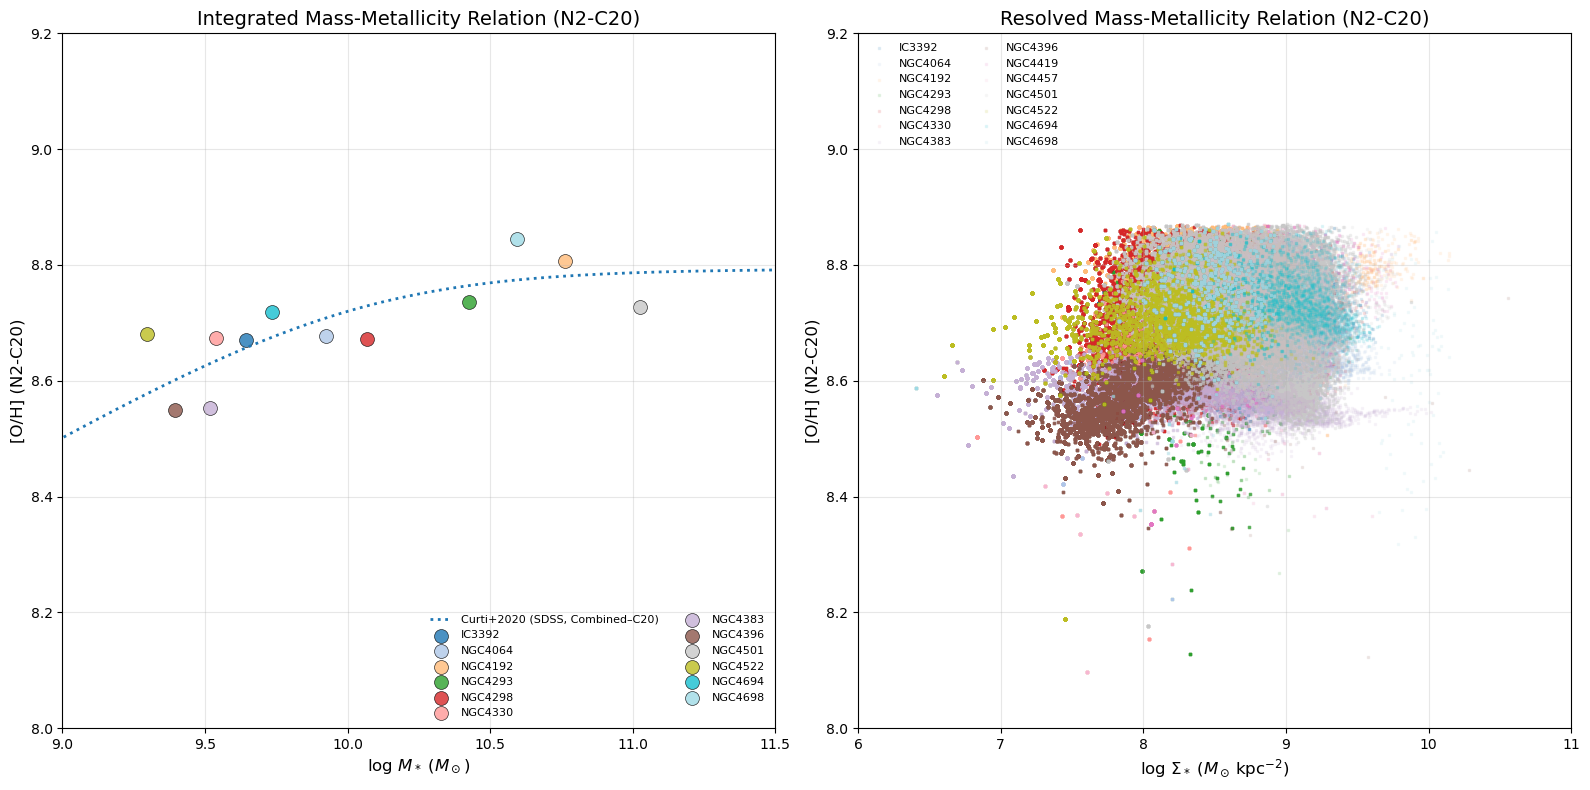

Subplot 1: Plotted 12 galaxies with valid total mass and N2-C20 metallicity data
Subplot 2: Plotted spatially-resolved N2-C20 MZR data for 14 galaxies


In [13]:
# ------------------------------------------------------------------
# Combined Plot: Integrated MZR (N2-C20) + Resolved MZR (N2-C20)
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import itertools
from scipy.stats import linregress
from astropy.io import fits

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ------------------------------------------------------------------
# SUBPLOT 1: Total Stellar Mass vs Total N2-C20 Metallicity from log files
# ------------------------------------------------------------------

# Extraction functions for log files
def extract_total_stellar_mass(galaxy_name):
    """Extract total stellar mass from mass log file. Returns log10(M☉) value or None if not found."""
    log_file = Path(f'mass_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total stellar mass \(R\)\s*:\s*([\d.-]+)\s*log10\(M☉\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading mass log for {galaxy_name}: {e}")
        return None

def extract_total_n2_c20_metallicity(galaxy_name):
    """Extract total N2-C20 metallicity from log file. Returns [O/H] N2-C20 value or None if not found."""
    log_file = Path(f'sfr_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'\[O/H\] N2-C20 SF: Total metallicity in SF region:\s*([\d.-]+)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading N2-C20 metallicity log for {galaxy_name}: {e}")
        return None

# Discover galaxies
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]

# Create galaxy color mapping (consistent for both subplots)
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, len(galaxies)))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

# Extract total masses and N2-C20 metallicities
log_masses = []
n2_c20_metallicities = []
galaxy_names = []

for gal in galaxies:
    mass = extract_total_stellar_mass(gal)
    metallicity = extract_total_n2_c20_metallicity(gal)
    
    if mass is not None and metallicity is not None:
        log_masses.append(mass)
        n2_c20_metallicities.append(metallicity)
        galaxy_names.append(gal)

# Convert to numpy arrays
log_masses = np.array(log_masses)
n2_c20_metallicities = np.array(n2_c20_metallicities)

# Plot reference MZR relations from literature (N2-C20-relevant only)
plot_previous_MZR(ax=ax1, show_legend=False, include=('C20',), sanchez_calibs=())

# Plot subplot 1 using consistent colors
for i, (mass, metallicity, gal) in enumerate(zip(log_masses, n2_c20_metallicities, galaxy_names)):
    ax1.scatter(mass, metallicity, s=100, c=[galaxy_color_dict[gal]], label=gal, alpha=0.8, 
               edgecolors='black', linewidth=0.5)

# Add labels and formatting for subplot 1
ax1.set_xlabel(r'$\log\,M_* \; (M_\odot)$', fontsize=12)
ax1.set_ylabel(r'[O/H] (N2-C20)', fontsize=12)
ax1.set_title('Integrated Mass-Metallicity Relation (N2-C20)', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='lower right', fontsize=8, ncol=2, frameon=False)
ax1.set_xlim(9, 11.5)
ax1.set_ylim(8.0, 9.2)

# ------------------------------------------------------------------
# SUBPLOT 2: Spatially-resolved Σ* vs [O/H] N2-C20
# ------------------------------------------------------------------

# Collect all data points for global fit
all_x = []
all_y = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Read FITS extensions
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_n2_c20 = hdul['O_H_N2_C20_SF'].data  # [O/H] N2-C20

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_n2_c20)

        # Scatter plot using consistent galaxy colors
        ax2.scatter(
            logSigmaM[good],
            oh_n2_c20[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x.extend(logSigmaM[good])
        all_y.extend(oh_n2_c20[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Final cosmetics for subplot 2
ax2.set_xlabel(r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax2.set_ylabel(r'[O/H] (N2-C20)', fontsize=12)
ax2.set_title(r'Resolved Mass-Metallicity Relation (N2-C20)', fontsize=14)
ax2.set_xlim(6, 11)
ax2.set_ylim(8.0, 9.2)
ax2.grid(True, alpha=0.3)
ax2.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

print(f"Subplot 1: Plotted {len(galaxy_names)} galaxies with valid total mass and N2-C20 metallicity data")
print(f"Subplot 2: Plotted spatially-resolved N2-C20 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")

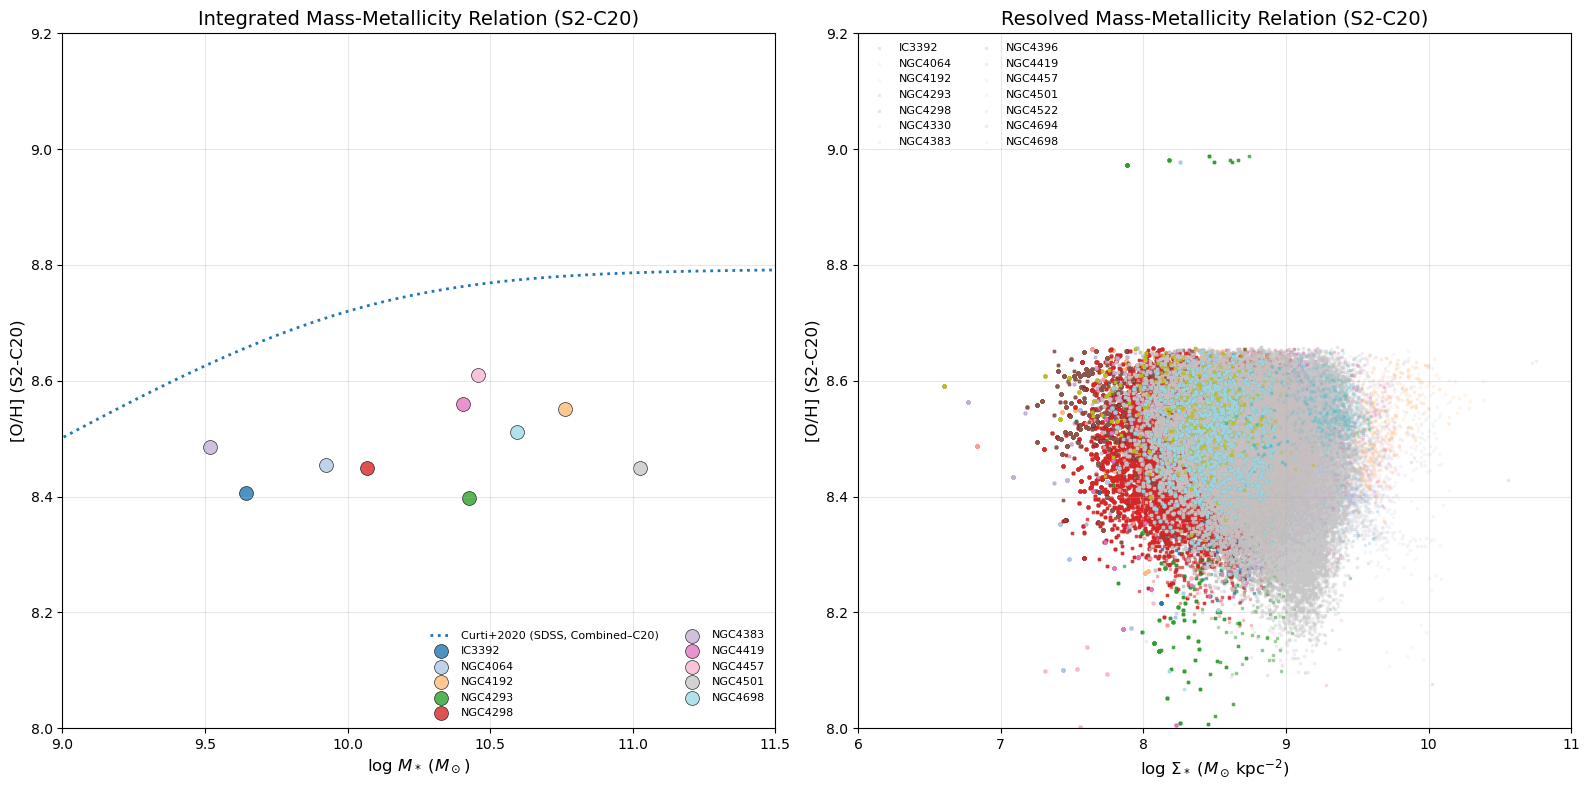

Subplot 1: Plotted 10 galaxies with valid total mass and S2-C20 metallicity data
Subplot 2: Plotted spatially-resolved S2-C20 MZR data for 14 galaxies


In [14]:
# ------------------------------------------------------------------
# Combined Plot: Integrated MZR (S2-C20) + Resolved MZR (S2-C20)
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import itertools
from scipy.stats import linregress
from astropy.io import fits

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ------------------------------------------------------------------
# SUBPLOT 1: Total Stellar Mass vs Total S2-C20 Metallicity from log files
# ------------------------------------------------------------------

# Extraction functions for log files
def extract_total_stellar_mass(galaxy_name):
    """Extract total stellar mass from mass log file. Returns log10(M☉) value or None if not found."""
    log_file = Path(f'mass_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total stellar mass \(R\)\s*:\s*([\d.-]+)\s*log10\(M☉\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading mass log for {galaxy_name}: {e}")
        return None

def extract_total_s2_c20_metallicity(galaxy_name):
    """Extract total S2-C20 metallicity from log file. Returns [O/H] S2-C20 value or None if not found."""
    log_file = Path(f'sfr_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'\[O/H\] S2-C20 SF: Total metallicity in SF region:\s*([\d.-]+)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading S2-C20 metallicity log for {galaxy_name}: {e}")
        return None

# Discover galaxies
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]

# Create galaxy color mapping (consistent for both subplots)
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, len(galaxies)))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

# Extract total masses and S2-C20 metallicities
log_masses = []
s2_c20_metallicities = []
galaxy_names = []

for gal in galaxies:
    mass = extract_total_stellar_mass(gal)
    metallicity = extract_total_s2_c20_metallicity(gal)
    
    if mass is not None and metallicity is not None:
        log_masses.append(mass)
        s2_c20_metallicities.append(metallicity)
        galaxy_names.append(gal)

# Convert to numpy arrays
log_masses = np.array(log_masses)
s2_c20_metallicities = np.array(s2_c20_metallicities)

# Plot reference MZR relations from literature (S2-C20-relevant only)
plot_previous_MZR(ax=ax1, show_legend=False, include=('C20',), sanchez_calibs=())

# Plot subplot 1 using consistent colors
for i, (mass, metallicity, gal) in enumerate(zip(log_masses, s2_c20_metallicities, galaxy_names)):
    ax1.scatter(mass, metallicity, s=100, c=[galaxy_color_dict[gal]], label=gal, alpha=0.8, 
               edgecolors='black', linewidth=0.5)

# Add labels and formatting for subplot 1
ax1.set_xlabel(r'$\log\,M_* \; (M_\odot)$', fontsize=12)
ax1.set_ylabel(r'[O/H] (S2-C20)', fontsize=12)
ax1.set_title('Integrated Mass-Metallicity Relation (S2-C20)', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='lower right', fontsize=8, ncol=2, frameon=False)
ax1.set_xlim(9, 11.5)
ax1.set_ylim(8.0, 9.2)

# ------------------------------------------------------------------
# SUBPLOT 2: Spatially-resolved Σ* vs [O/H] S2-C20
# ------------------------------------------------------------------

# Collect all data points for global fit
all_x = []
all_y = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Read FITS extensions
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_s2_c20 = hdul['O_H_S2_C20_SF'].data  # [O/H] S2-C20

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_s2_c20)

        # Scatter plot using consistent galaxy colors
        ax2.scatter(
            logSigmaM[good],
            oh_s2_c20[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x.extend(logSigmaM[good])
        all_y.extend(oh_s2_c20[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Final cosmetics for subplot 2
ax2.set_xlabel(r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax2.set_ylabel(r'[O/H] (S2-C20)', fontsize=12)
ax2.set_title(r'Resolved Mass-Metallicity Relation (S2-C20)', fontsize=14)
ax2.set_xlim(6, 11)
ax2.set_ylim(8.0, 9.2)
ax2.grid(True, alpha=0.3)
ax2.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

print(f"Subplot 1: Plotted {len(galaxy_names)} galaxies with valid total mass and S2-C20 metallicity data")
print(f"Subplot 2: Plotted spatially-resolved S2-C20 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")

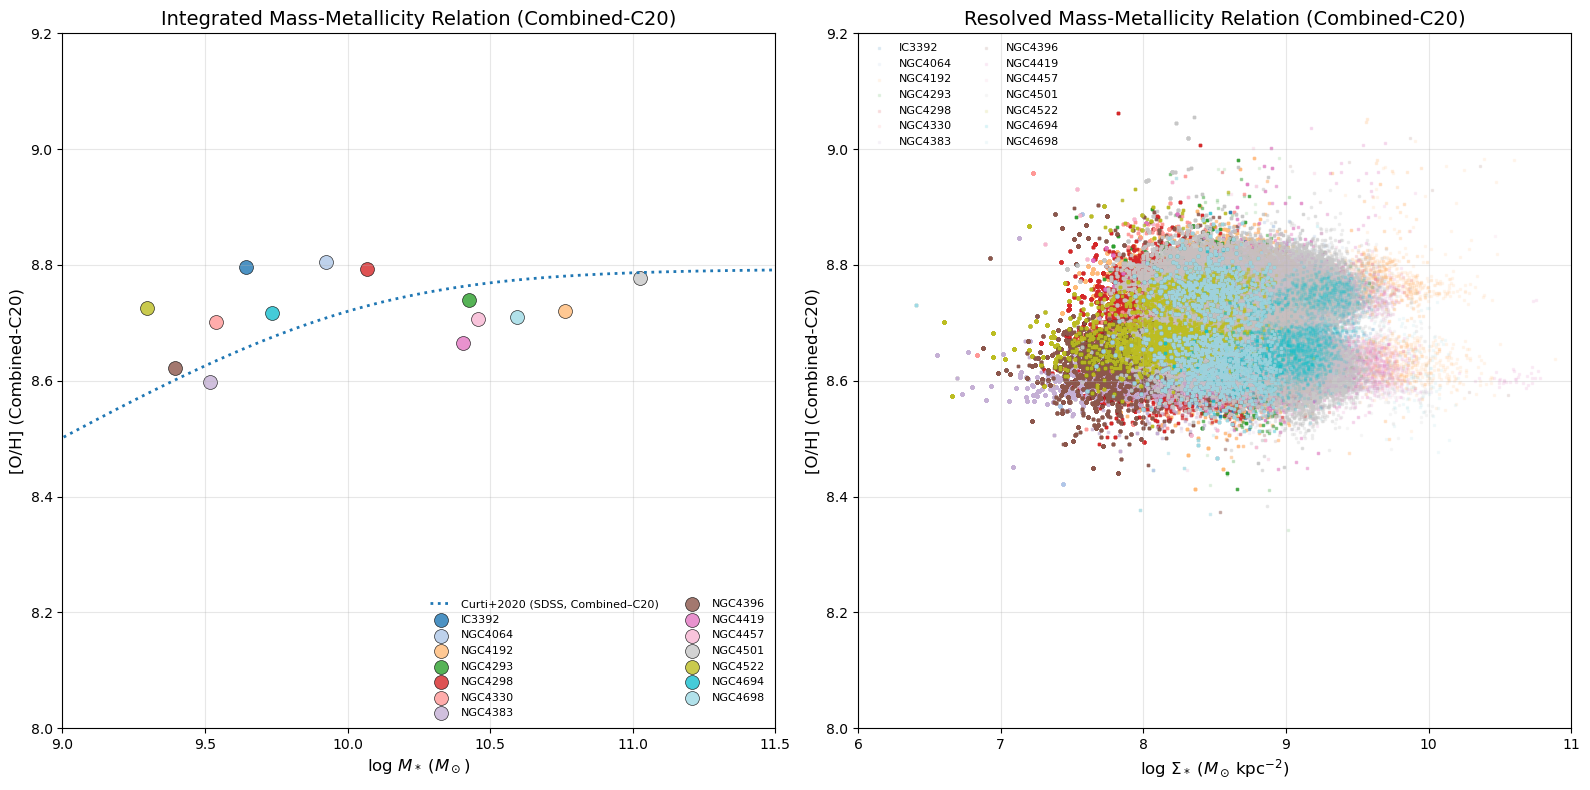

Subplot 1: Plotted 14 galaxies with valid total mass and Combined-C20 metallicity data
Subplot 2: Plotted spatially-resolved Combined-C20 MZR data for 14 galaxies


In [15]:
# ------------------------------------------------------------------
# Combined Plot: Integrated MZR (Combined-C20) + Resolved MZR (Combined-C20)
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
import itertools
from scipy.stats import linregress
from astropy.io import fits

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# ------------------------------------------------------------------
# SUBPLOT 1: Total Stellar Mass vs Total Combined-C20 Metallicity from log files
# ------------------------------------------------------------------

# Extraction functions for log files
def extract_total_stellar_mass(galaxy_name):
    """Extract total stellar mass from mass log file. Returns log10(M☉) value or None if not found."""
    log_file = Path(f'mass_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'Total stellar mass \(R\)\s*:\s*([\d.-]+)\s*log10\(M☉\)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading mass log for {galaxy_name}: {e}")
        return None

def extract_total_combined_c20_metallicity(galaxy_name):
    """Extract total Combined-C20 metallicity from log file. Returns [O/H] Combined-C20 value or None if not found."""
    log_file = Path(f'sfr_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        pattern = r'\[O/H\] Combined-C20 SF: Total metallicity in SF region:\s*([\d.-]+)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading Combined-C20 metallicity log for {galaxy_name}: {e}")
        return None

# Discover galaxies
bins = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies = [f.name.split('_')[0] for f in bins]

# Create galaxy color mapping (consistent for both subplots)
galaxy_colors = plt.cm.tab20(np.linspace(0, 1, len(galaxies)))
galaxy_color_dict = dict(zip(galaxies, galaxy_colors))

# Extract total masses and Combined-C20 metallicities
log_masses = []
combined_c20_metallicities = []
galaxy_names = []

for gal in galaxies:
    mass = extract_total_stellar_mass(gal)
    metallicity = extract_total_combined_c20_metallicity(gal)
    
    if mass is not None and metallicity is not None:
        log_masses.append(mass)
        combined_c20_metallicities.append(metallicity)
        galaxy_names.append(gal)

# Convert to numpy arrays
log_masses = np.array(log_masses)
combined_c20_metallicities = np.array(combined_c20_metallicities)

# Plot reference MZR relations from literature (Combined-C20-relevant only)
plot_previous_MZR(ax=ax1, show_legend=False, include=('C20',), sanchez_calibs=())

# Plot subplot 1 using consistent colors
for i, (mass, metallicity, gal) in enumerate(zip(log_masses, combined_c20_metallicities, galaxy_names)):
    ax1.scatter(mass, metallicity, s=100, c=[galaxy_color_dict[gal]], label=gal, alpha=0.8, 
               edgecolors='black', linewidth=0.5)

# Add labels and formatting for subplot 1
ax1.set_xlabel(r'$\log\,M_* \; (M_\odot)$', fontsize=12)
ax1.set_ylabel(r'[O/H] (Combined-C20)', fontsize=12)
ax1.set_title('Integrated Mass-Metallicity Relation (Combined-C20)', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.legend(loc='lower right', fontsize=8, ncol=2, frameon=False)
ax1.set_xlim(9, 11.5)
ax1.set_ylim(8.0, 9.2)

# ------------------------------------------------------------------
# SUBPLOT 2: Spatially-resolved Σ* vs [O/H] Combined-C20
# ------------------------------------------------------------------

# Collect all data points for global fit
all_x = []
all_y = []

for gal in galaxies:
    bin_file = Path(f'{gal}_SPATIAL_BINNING_maps_extended.fits')
    gas_file = Path(f'{gal}_gas_BIN_maps_extended.fits')
    
    if not bin_file.exists() or not gas_file.exists():
        continue

    # Read FITS extensions
    try:
        with fits.open(bin_file) as hdul:
            logSigmaM = hdul['LOGMASS_SURFACE_DENSITY'].data  # Σ*
        with fits.open(gas_file) as hdul:
            oh_combined_c20 = hdul['O_H_COMBINED_C20_SF'].data  # [O/H] Combined-C20

        # Mask bad pixels
        good = np.isfinite(logSigmaM) & np.isfinite(oh_combined_c20)

        # Scatter plot using consistent galaxy colors
        ax2.scatter(
            logSigmaM[good],
            oh_combined_c20[good],
            s=1, 
            marker=',', 
            alpha=0.1,
            color=galaxy_color_dict[gal],
            label=gal
        )
        
        # Collect points for global fit
        all_x.extend(logSigmaM[good])
        all_y.extend(oh_combined_c20[good])
        
    except Exception as e:
        print(f"Error processing {gal}: {e}")
        continue

# Final cosmetics for subplot 2
ax2.set_xlabel(r'$\log\,\Sigma_* \; (M_\odot\,\mathrm{kpc}^{-2})$', fontsize=12)
ax2.set_ylabel(r'[O/H] (Combined-C20)', fontsize=12)
ax2.set_title(r'Resolved Mass-Metallicity Relation (Combined-C20)', fontsize=14)
ax2.set_xlim(6, 11)
ax2.set_ylim(8.0, 9.2)
ax2.grid(True, alpha=0.3)
ax2.legend(frameon=False, fontsize=8, loc='upper left', ncol=2)

plt.tight_layout()
plt.show()

print(f"Subplot 1: Plotted {len(galaxy_names)} galaxies with valid total mass and Combined-C20 metallicity data")
print(f"Subplot 2: Plotted spatially-resolved Combined-C20 MZR data for {len([g for g in galaxies if Path(f'{g}_SPATIAL_BINNING_maps_extended.fits').exists()])} galaxies")


Processing D16 calibration...

Processing PG16 calibration...

Processing O3N2-M13 calibration...

Processing N2-M13 calibration...

Processing O3N2-PP04 calibration...

Processing N2-PP04 calibration...

Processing O3N2-C20 calibration...

Processing O3S2-C20 calibration...

Processing RS32-C20 calibration...

Processing R3-C20 calibration...

Processing N2-C20 calibration...

Processing S2-C20 calibration...

Processing Combined-C20 calibration...


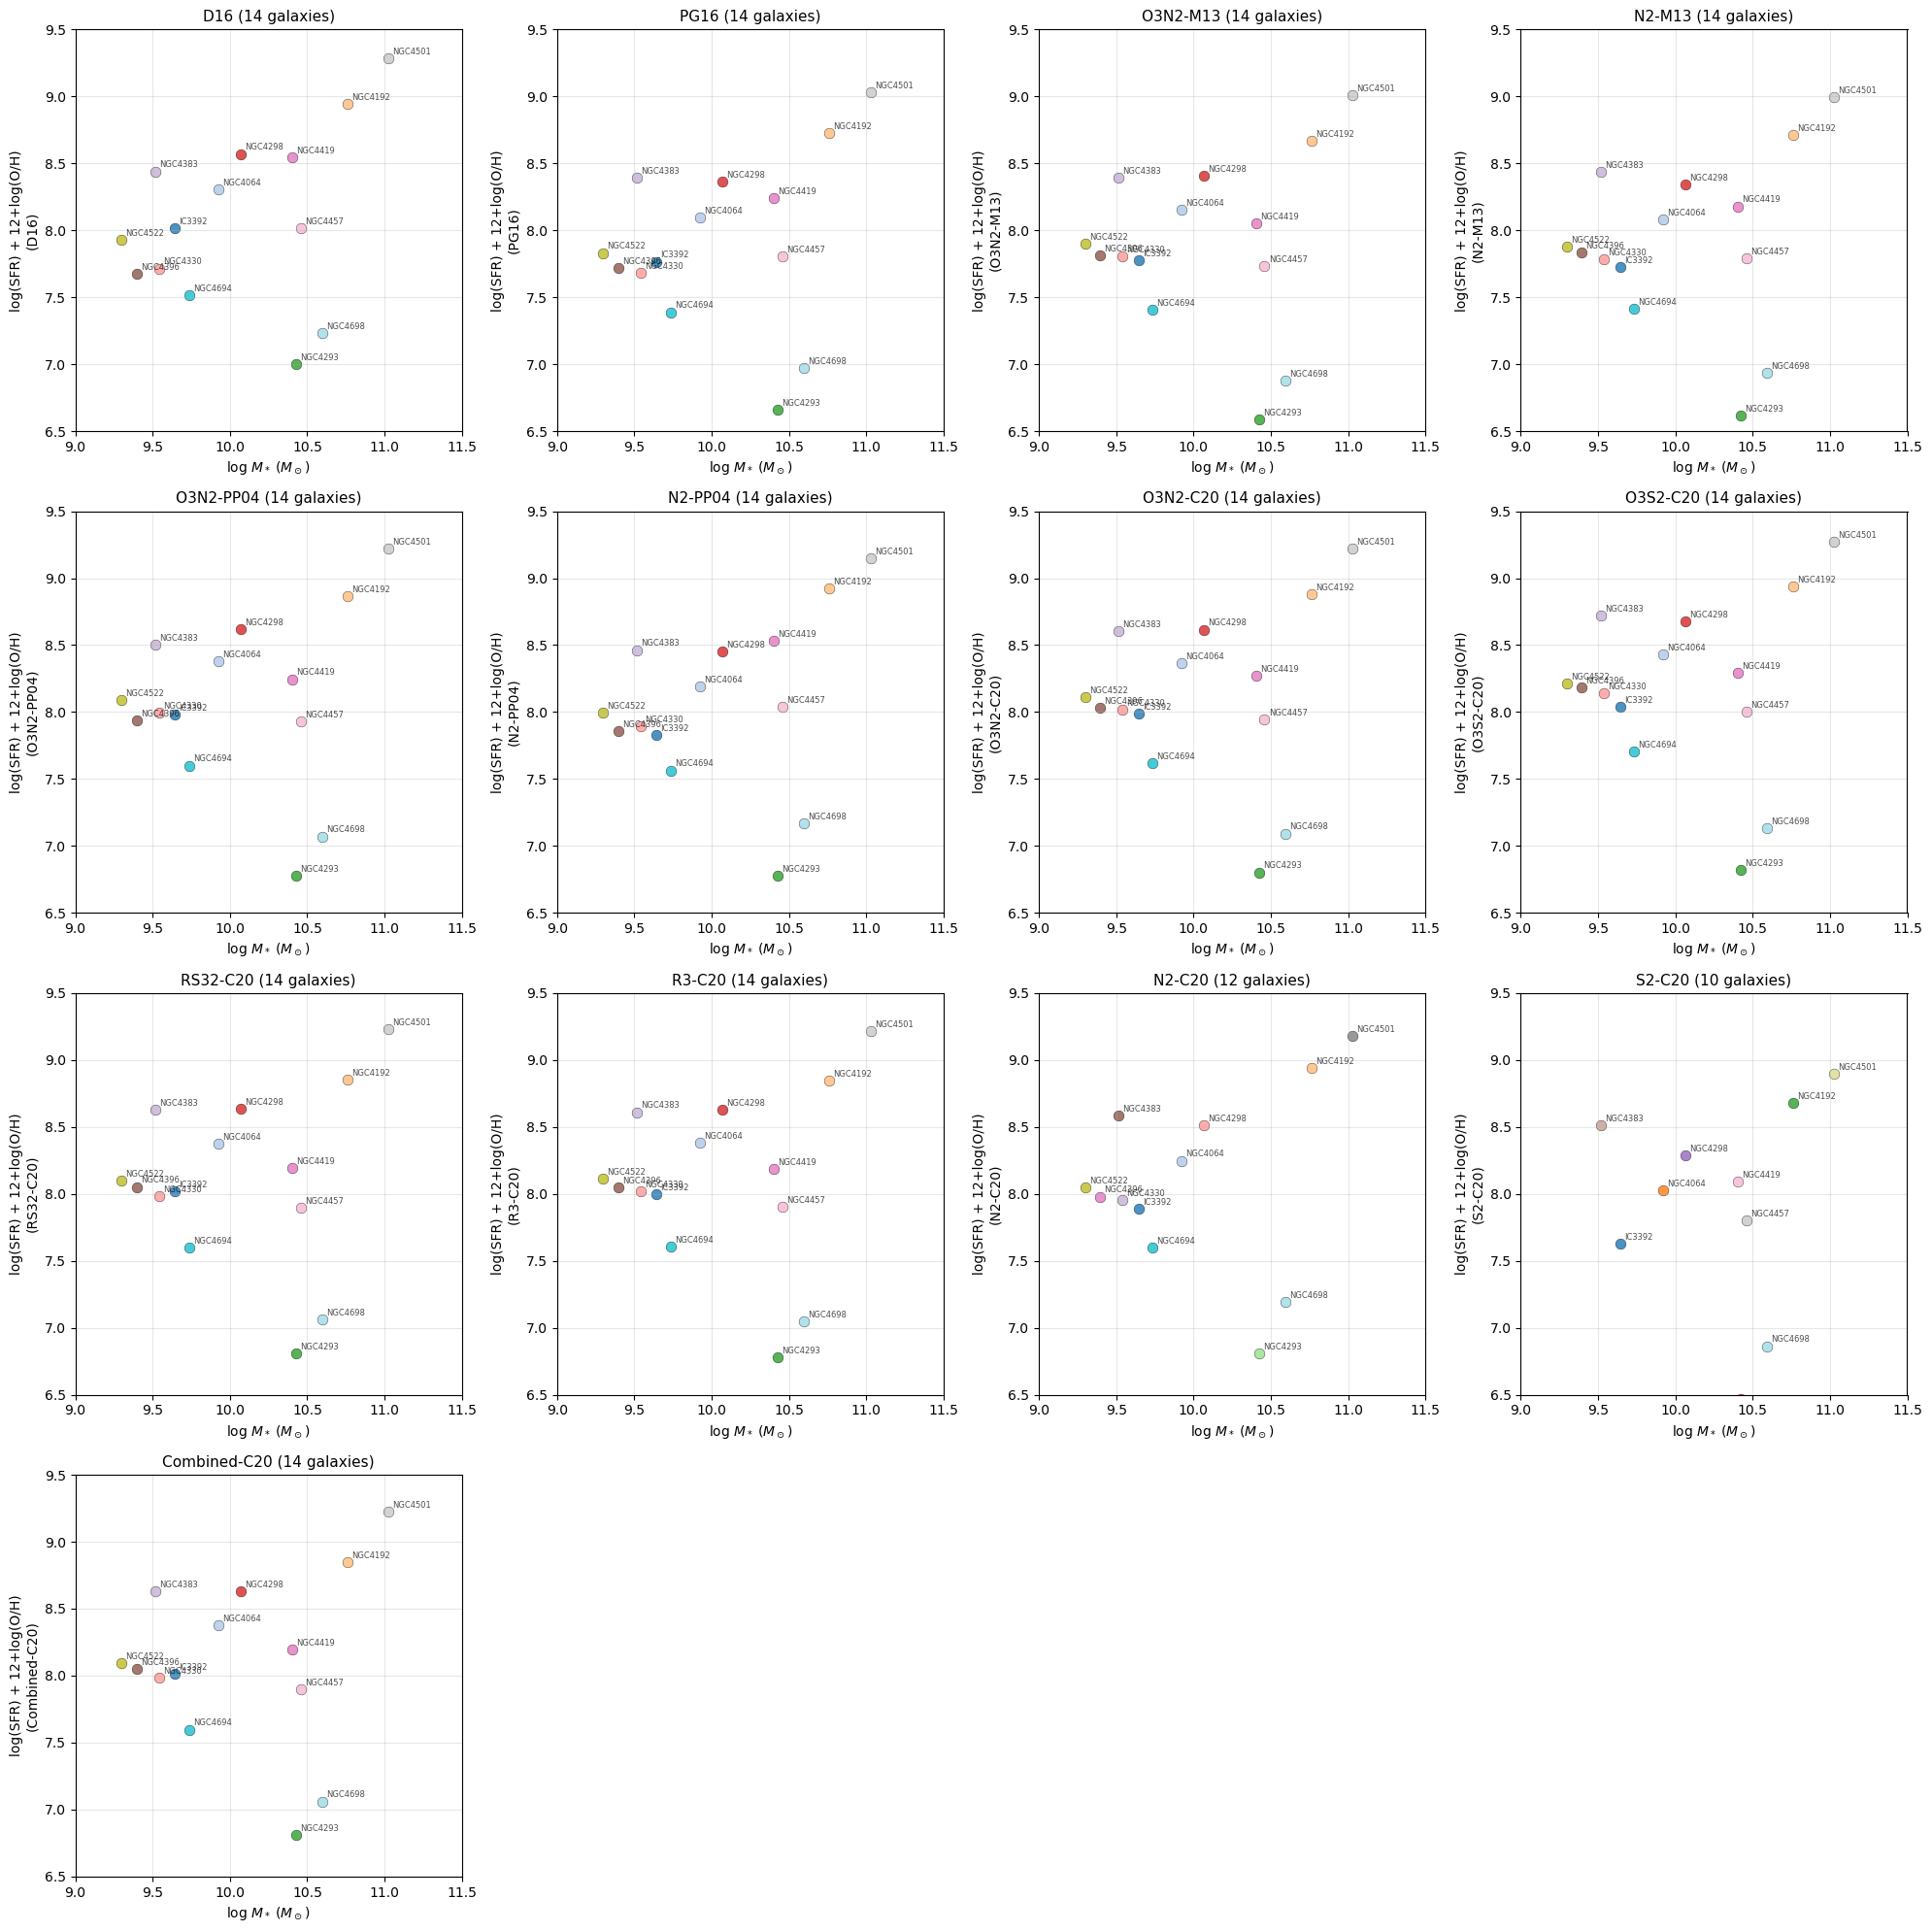


=== SUMMARY ===
Created plots for 13 metallicity calibrations
Each plot shows log(SFR) + (12 + log(O/H)) vs log(M_*) for the integrated case


In [16]:
# ------------------------------------------------------------------
# Loop through multiple metallicity calibrations: log(SFR) + (12 + log(O/H)) vs log(M_*)
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
from astropy.io import fits

# Define all the metallicity calibrations to loop through
metallicity_calibrations = [
    'D16', 'PG16', 'O3N2-M13', 'N2-M13', 'O3N2-PP04', 'N2-PP04', 
    'O3N2-C20', 'O3S2-C20', 'RS32-C20', 'R3-C20', 'N2-C20', 'S2-C20', 'Combined-C20'
]

# Create extraction function for different metallicity calibrations
def extract_total_metallicity(galaxy_name, calibration):
    """Extract total metallicity for a specific calibration from log file."""
    log_file = Path(f'sfr_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        # Pattern for SF region metallicity
        pattern = rf'\[O/H\] {re.escape(calibration)} SF: Total metallicity in SF region:\s*([\d.-]+)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading {calibration} metallicity log for {galaxy_name}: {e}")
        return None

# Create a large figure with subplots for all calibrations
n_calibrations = len(metallicity_calibrations)
n_cols = 4  # 4 columns
n_rows = (n_calibrations + n_cols - 1) // n_cols  # Calculate rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten()  # Flatten to make indexing easier

# Loop through each calibration
for idx, calibration in enumerate(metallicity_calibrations):
    ax = axes[idx]
    
    print(f"\nProcessing {calibration} calibration...")
    
    # Extract data for this calibration
    log_masses_cal = []
    log_sfrs_cal = []
    metallicities_cal = []
    galaxy_names_cal = []
    
    for gal in galaxies:
        mass = extract_total_stellar_mass(gal)
        sfr = extract_total_sfr(gal)
        metallicity = extract_total_metallicity(gal, calibration)
        
        if mass is not None and sfr is not None and metallicity is not None:
            log_masses_cal.append(mass)
            log_sfrs_cal.append(sfr)
            metallicities_cal.append(metallicity)
            galaxy_names_cal.append(gal)
    
    # Convert to numpy arrays
    log_masses_cal = np.array(log_masses_cal)
    log_sfrs_cal = np.array(log_sfrs_cal)
    metallicities_cal = np.array(metallicities_cal)
    
    if len(galaxy_names_cal) == 0:
        ax.text(0.5, 0.5, f'No data for {calibration}', 
               transform=ax.transAxes, ha='center', va='center', fontsize=12)
        ax.set_title(f'{calibration} (No Data)', fontsize=12)
        continue
    
    # Calculate the combined quantity: log(SFR) + (12 + log(O/H))
    combined_y_cal = log_sfrs_cal + metallicities_cal
    
    # Color-code each galaxy (consistent colors across all plots)
    colors_cal = plt.cm.tab20(np.linspace(0, 1, len(galaxy_names_cal)))
    
    # Plot points
    for i, (mass, combined, gal) in enumerate(zip(log_masses_cal, combined_y_cal, galaxy_names_cal)):
        ax.scatter(mass, combined, s=60, c=[colors_cal[i]], alpha=0.8, 
                  edgecolors='black', linewidth=0.3)
        
        # Add galaxy name as annotation (smaller font for subplots)
        ax.annotate(gal, (mass, combined), xytext=(3, 3), textcoords='offset points', 
                   fontsize=6, alpha=0.7)
    
    # Formatting for each subplot
    ax.set_xlabel(r'$\log\,M_* \; (M_\odot)$', fontsize=10)
    ax.set_ylabel(f'log(SFR) + 12+log(O/H)\n({calibration})', fontsize=10)
    ax.set_title(f'{calibration} ({len(galaxy_names_cal)} galaxies)', fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # Set consistent axis limits
    ax.set_xlim(9, 11.5)
    ax.set_ylim(6.5, 9.5)

# Hide any unused subplots
for idx in range(n_calibrations, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

print(f"\n=== SUMMARY ===")
print(f"Created plots for {len(metallicity_calibrations)} metallicity calibrations")
print(f"Each plot shows log(SFR) + (12 + log(O/H)) vs log(M_*) for the integrated case")

## 3D plane from Curti20
$$\log_{10}(M) = m_0+m_1\log_{10}(\rm{SFR})-\frac{1}{\beta}\log_{10}(10^{\frac{\beta}{\gamma}(Z_0-Z)}-1)$$
with $Z_0 = 8.779$, $m_0 = 10.11$, $m_1 = 0.56$, $\gamma = 0.31$, $\beta = 2.1$


Processing D16 calibration...

Processing PG16 calibration...

Processing O3N2-M13 calibration...

Processing N2-M13 calibration...

Processing O3N2-PP04 calibration...

Processing N2-PP04 calibration...

Processing O3N2-C20 calibration...

Processing O3S2-C20 calibration...

Processing RS32-C20 calibration...

Processing R3-C20 calibration...

Processing N2-C20 calibration...

Processing S2-C20 calibration...

Processing Combined-C20 calibration...


/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_79497/3623009112.py:42: RuntimeWarning: invalid value encountered in log10
  log_term = np.log10(10**exponent - 1)


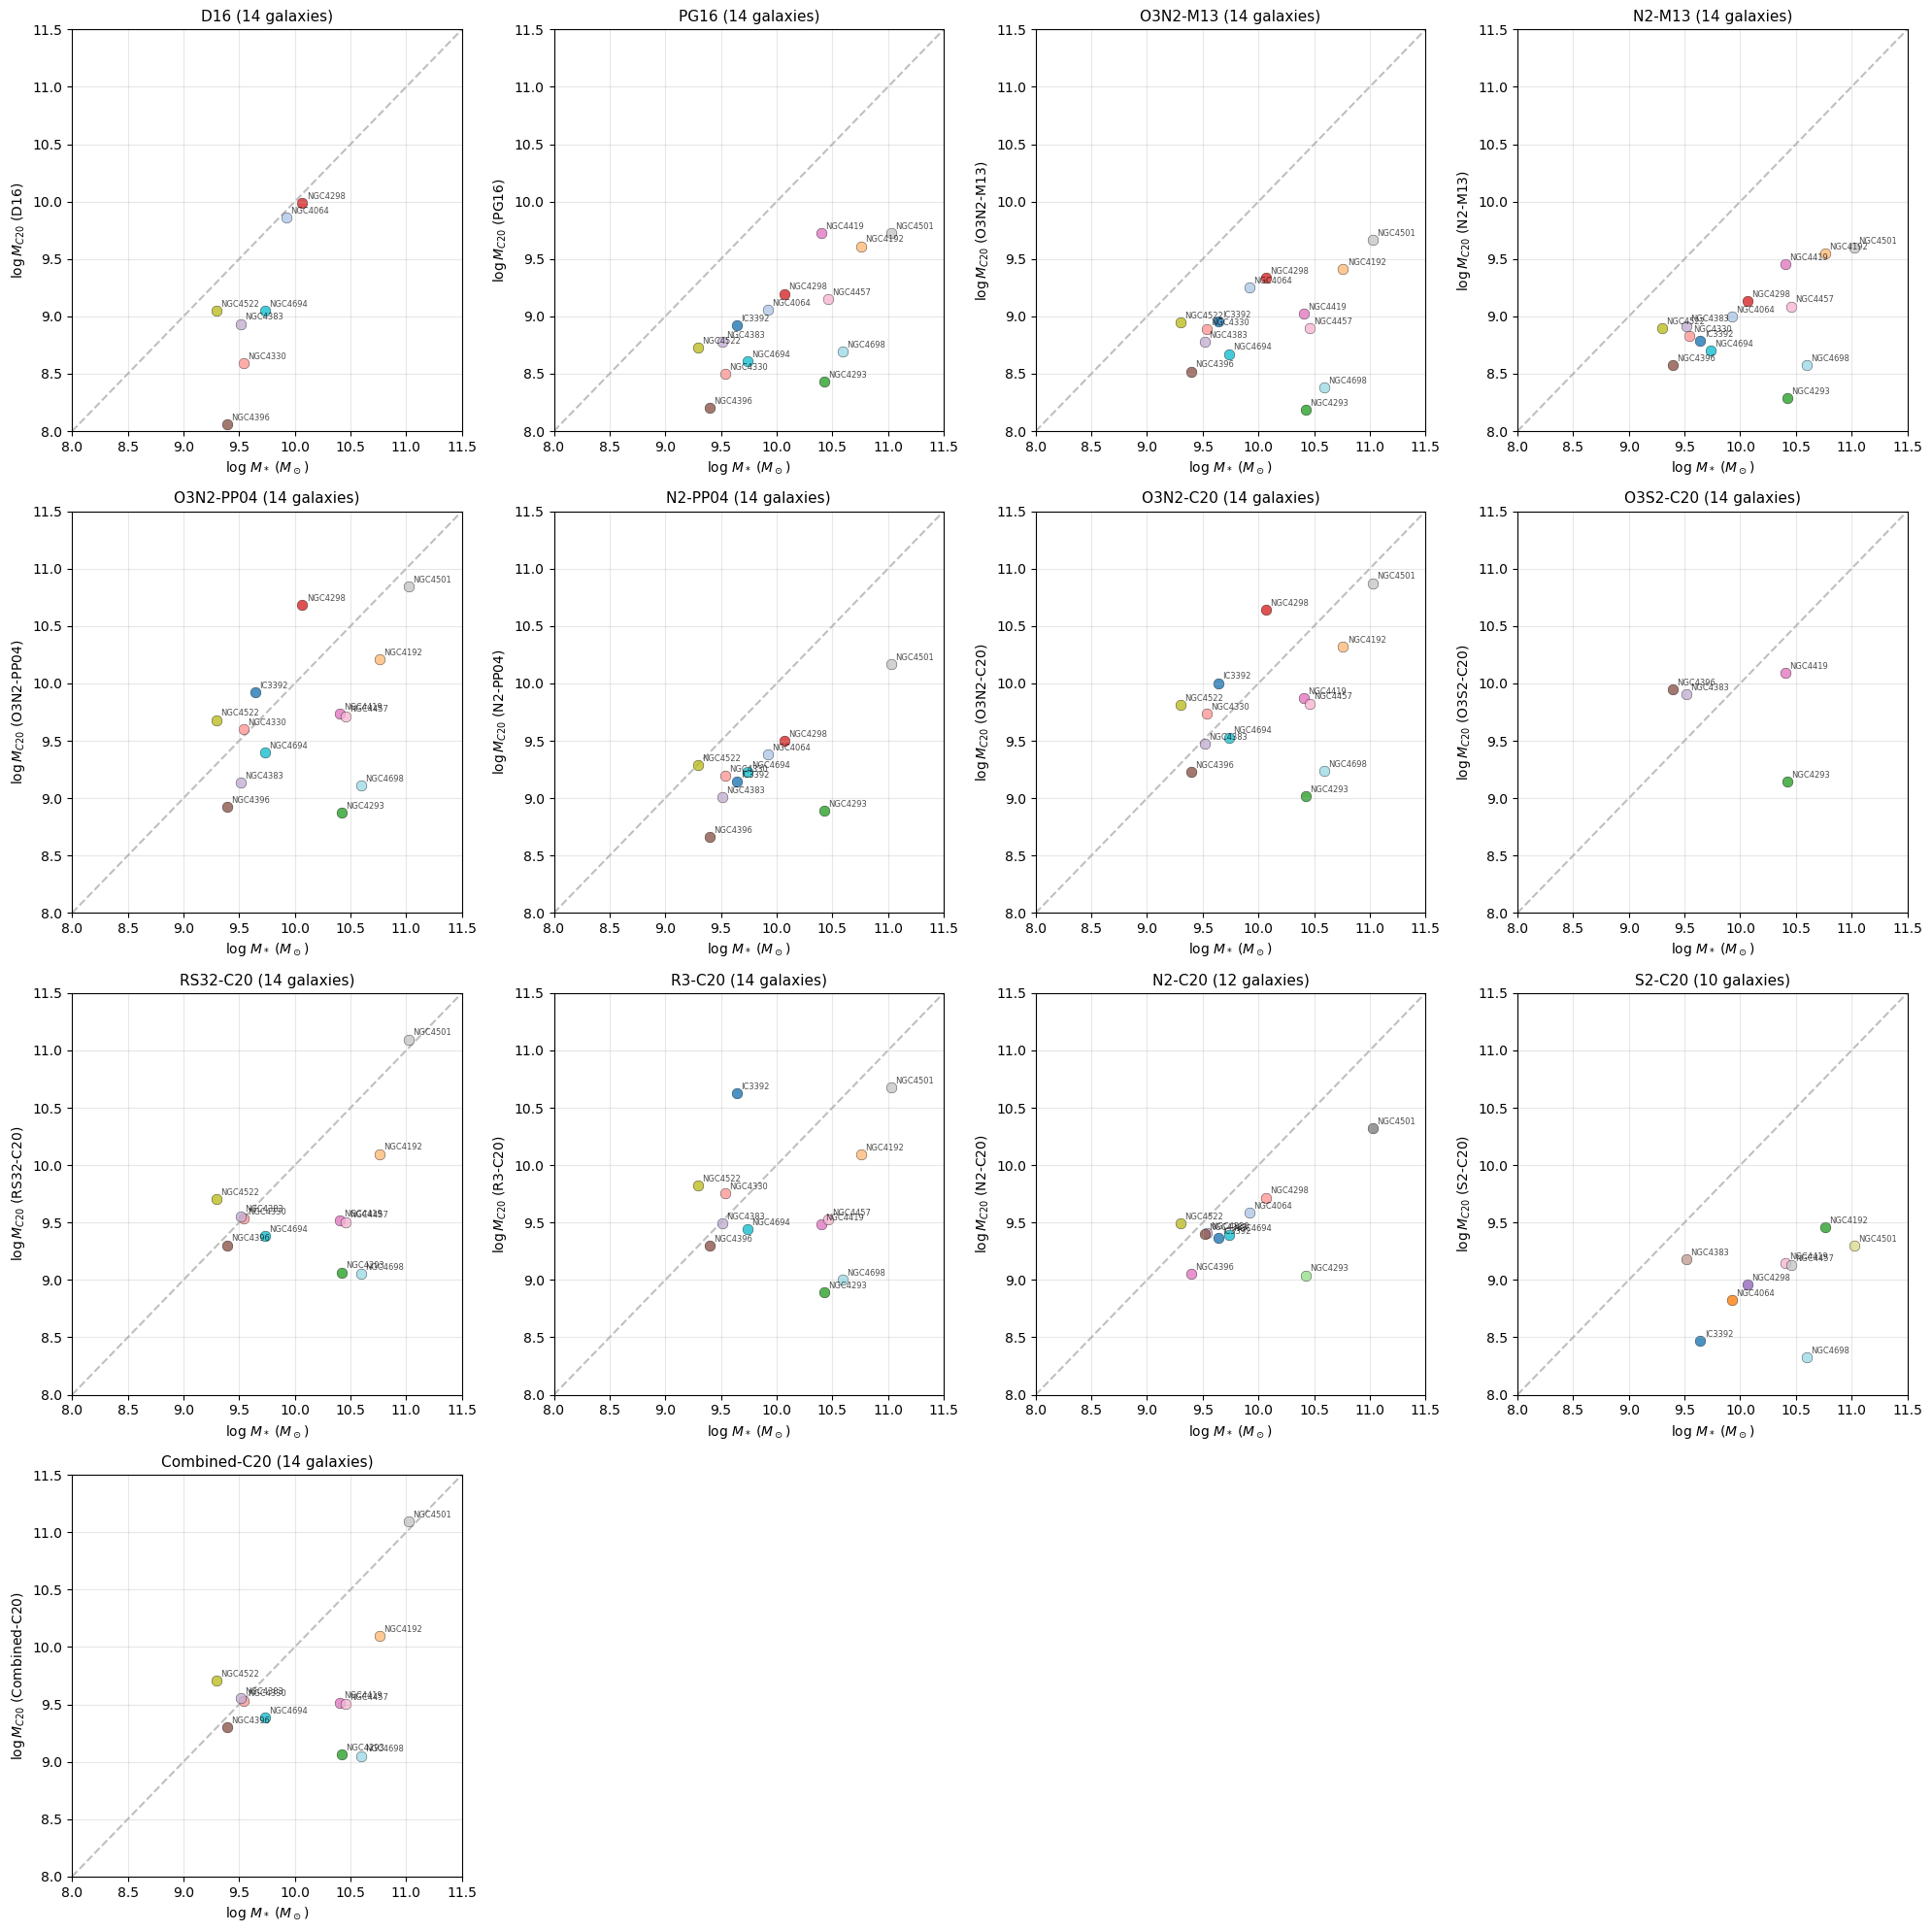


=== SUMMARY ===
Created plots for 13 metallicity calibrations
Each plot shows logM_C20 vs log(M_*) for the integrated case
logM_C20 formula: log10(M) = m0 + m1*log10(SFR) - (1/β)*log10(10^(β/γ*(Z0-Z)) - 1)
Parameters: Z0=8.779, m0=10.11, m1=0.56, γ=0.31, β=2.1


In [17]:
# ------------------------------------------------------------------
# Loop through multiple metallicity calibrations: logM_C20 vs log(M_*)
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import re
from astropy.io import fits

# Define all the metallicity calibrations to loop through
metallicity_calibrations = [
    'D16', 'PG16', 'O3N2-M13', 'N2-M13', 'O3N2-PP04', 'N2-PP04', 
    'O3N2-C20', 'O3S2-C20', 'RS32-C20', 'R3-C20', 'N2-C20', 'S2-C20', 'Combined-C20'
]

# Define C20 formula parameters
Z0 = 8.779
m0 = 10.11
m1 = 0.56
gamma = 0.31
beta = 2.1

# Z0 = 8.782
# m0 = 10.39
# m1 = 0.454
# gamma = 0.299
# beta = 2.6

def calculate_logM_C20(log_sfr, metallicity):
    """
    Calculate log(M) using the C20 formula:
    log10(M) = m0 + m1*log10(SFR) - (1/beta)*log10(10^(beta/gamma*(Z0-Z)) - 1)
    
    Parameters:
    log_sfr: log10(SFR)
    metallicity: 12 + log(O/H)
    """
    Z = metallicity  # Z is 12 + log(O/H)
    
    # Calculate the C20 formula
    exponent = (beta / gamma) * (Z0 - Z)
    log_term = np.log10(10**exponent - 1)
    logM_C20 = m0 + m1 * log_sfr - (1/beta) * log_term
    
    return logM_C20

# Create extraction function for different metallicity calibrations
def extract_total_metallicity(galaxy_name, calibration):
    """Extract total metallicity for a specific calibration from log file."""
    log_file = Path(f'sfr_logs/{galaxy_name}.log')
    if not log_file.exists():
        return None
    
    try:
        with open(log_file, 'r') as f:
            content = f.read()
        # Pattern for SF region metallicity
        pattern = rf'\[O/H\] {re.escape(calibration)} SF: Total metallicity in SF region:\s*([\d.-]+)'
        match = re.search(pattern, content)
        return float(match.group(1)) if match else None
    except Exception as e:
        print(f"Error reading {calibration} metallicity log for {galaxy_name}: {e}")
        return None

# Create a large figure with subplots for all calibrations
n_calibrations = len(metallicity_calibrations)
n_cols = 4  # 4 columns
n_rows = (n_calibrations + n_cols - 1) // n_cols  # Calculate rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten()  # Flatten to make indexing easier

# Loop through each calibration
for idx, calibration in enumerate(metallicity_calibrations):
    ax = axes[idx]
    
    print(f"\nProcessing {calibration} calibration...")
    
    # Extract data for this calibration
    log_masses_cal = []
    log_sfrs_cal = []
    metallicities_cal = []
    galaxy_names_cal = []
    
    for gal in galaxies:
        mass = extract_total_stellar_mass(gal)
        sfr = extract_total_sfr(gal)
        metallicity = extract_total_metallicity(gal, calibration)
        
        if mass is not None and sfr is not None and metallicity is not None:
            log_masses_cal.append(mass)
            log_sfrs_cal.append(sfr)
            metallicities_cal.append(metallicity)
            galaxy_names_cal.append(gal)
    
    # Convert to numpy arrays
    log_masses_cal = np.array(log_masses_cal)
    log_sfrs_cal = np.array(log_sfrs_cal)
    metallicities_cal = np.array(metallicities_cal)
    
    if len(galaxy_names_cal) == 0:
        ax.text(0.5, 0.5, f'No data for {calibration}', 
               transform=ax.transAxes, ha='center', va='center', fontsize=12)
        ax.set_title(f'{calibration} (No Data)', fontsize=12)
        continue
    
    # Calculate logM_C20 using the C20 formula
    logM_C20_cal = calculate_logM_C20(log_sfrs_cal, metallicities_cal)
    
    # Color-code each galaxy (consistent colors across all plots)
    colors_cal = plt.cm.tab20(np.linspace(0, 1, len(galaxy_names_cal)))
    
    # Plot points
    for i, (mass, logM_C20, gal) in enumerate(zip(log_masses_cal, logM_C20_cal, galaxy_names_cal)):
        ax.scatter(mass, logM_C20, s=60, c=[colors_cal[i]], alpha=0.8, 
                  edgecolors='black', linewidth=0.3)
        
        # Add galaxy name as annotation (smaller font for subplots)
        ax.annotate(gal, (mass, logM_C20), xytext=(3, 3), textcoords='offset points', 
                   fontsize=6, alpha=0.7)
    
    # Formatting for each subplot
    ax.set_xlabel(r'$\log\,M_* \; (M_\odot)$', fontsize=10)
    ax.set_ylabel(f'$\\log M_{{C20}}$ ({calibration})', fontsize=10)
    ax.set_title(f'{calibration} ({len(galaxy_names_cal)} galaxies)', fontsize=11)
    ax.grid(True, alpha=0.3)
    
    # Set consistent axis limits (adjusted for logM_C20 range)
    ax.set_xlim(8, 11.5)
    ax.set_ylim(8, 11.5)  # Adjusted y-axis range for logM_C20
    
    # Add one-to-one line (y=x)
    ax.plot([8, 11.5], [8, 11.5], '--', color='gray', alpha=0.5, 
            label='One-to-one line', zorder=0)

# Hide any unused subplots
for idx in range(n_calibrations, len(axes)):
    axes[idx].set_visible(False)

plt.tight_layout()
plt.show()

print(f"\n=== SUMMARY ===")
print(f"Created plots for {len(metallicity_calibrations)} metallicity calibrations")
print(f"Each plot shows logM_C20 vs log(M_*) for the integrated case")
print(f"logM_C20 formula: log10(M) = m0 + m1*log10(SFR) - (1/β)*log10(10^(β/γ*(Z0-Z)) - 1)")
print(f"Parameters: Z0={Z0}, m0={m0}, m1={m1}, γ={gamma}, β={beta}")

In [18]:
# ------------------------------------------------------------------
# Fit C20 Functional Form to Your Data
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, differential_evolution
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

def c20_formula(params, log_sfr, metallicity):
    """
    C20 formula: log10(M) = m0 + m1*log10(SFR) - (1/beta)*log10(10^(beta/gamma*(Z0-Z)) - 1)
    
    Parameters:
    params: [Z0, m0, m1, gamma, beta]
    log_sfr: log10(SFR)
    metallicity: 12 + log(O/H) (Z)
    """
    Z0, m0, m1, gamma, beta = params
    Z = metallicity
    
    # Calculate the C20 formula with error handling
    try:
        exponent = (beta / gamma) * (Z0 - Z)
        # Add small epsilon to avoid log(0) or log(negative)
        epsilon = 1e-10
        term_inside_log = 10**exponent - 1 + epsilon
        term_inside_log = np.maximum(term_inside_log, epsilon)  # Ensure positive
        log_term = np.log10(term_inside_log)
        logM_C20 = m0 + m1 * log_sfr - (1/beta) * log_term
        return logM_C20
    except:
        # Return NaN for invalid parameter combinations
        return np.full_like(log_sfr, np.nan)

def c20_residuals(params, log_sfr, metallicity, log_mass_obs):
    """Calculate residuals for fitting"""
    logM_predicted = c20_formula(params, log_sfr, metallicity)
    residuals = log_mass_obs - logM_predicted
    # Remove NaN values
    valid = ~np.isnan(residuals)
    if np.sum(valid) == 0:
        return np.array([1e10])  # Large penalty for invalid parameters
    return residuals[valid]

def fit_c20_parameters(log_masses, log_sfrs, metallicities, method='differential_evolution'):
    """
    Fit C20 parameters to observed data
    Returns: fitted_params, fitted_errors, fit_quality_metrics
    """
    # Remove any invalid data points
    valid = np.isfinite(log_masses) & np.isfinite(log_sfrs) & np.isfinite(metallicities)
    log_masses_clean = log_masses[valid]
    log_sfrs_clean = log_sfrs[valid]
    metallicities_clean = metallicities[valid]
    
    if len(log_masses_clean) < 5:  # Need at least 5 points for 5 parameters
        return None, None, None
    
    # Define parameter bounds: [Z0, m0, m1, gamma, beta]
    bounds = [(7.5, 9.5),    # Z0: reasonable metallicity range
              (8.0, 12.0),   # m0: mass intercept
              (0.1, 1.5),    # m1: SFR slope
              (0.1, 1.0),    # gamma: 
              (1.0, 5.0)]    # beta: 
    
    # Initial guess (from literature C20 values)
    initial_guess = [8.779, 10.11, 0.56, 0.31, 2.1]
    
    def objective(params):
        residuals = c20_residuals(params, log_sfrs_clean, metallicities_clean, log_masses_clean)
        return np.sum(residuals**2)
    
    try:
        if method == 'differential_evolution':
            # Use differential evolution for global optimization
            result = differential_evolution(objective, bounds, seed=42, maxiter=1000)
            fitted_params = result.x
            success = result.success
        else:
            # Use curve_fit
            def c20_for_curve_fit(x_data, Z0, m0, m1, gamma, beta):
                log_sfr, metallicity = x_data
                return c20_formula([Z0, m0, m1, gamma, beta], log_sfr, metallicity)
            
            x_data = np.vstack([log_sfrs_clean, metallicities_clean])
            fitted_params, pcov = curve_fit(c20_for_curve_fit, x_data, log_masses_clean, 
                                          p0=initial_guess, bounds=tuple(zip(*bounds)), maxfev=5000)
            fitted_errors = np.sqrt(np.diag(pcov))
            success = True
    
        # Calculate fit quality metrics
        logM_fitted = c20_formula(fitted_params, log_sfrs_clean, metallicities_clean)
        residuals = log_masses_clean - logM_fitted
        
        rms = np.sqrt(np.mean(residuals**2))
        correlation, p_value = pearsonr(log_masses_clean, logM_fitted)
        
        # Calculate R-squared
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((log_masses_clean - np.mean(log_masses_clean))**2)
        r_squared = 1 - (ss_res / ss_tot)
        
        fit_metrics = {
            'rms': rms,
            'correlation': correlation,
            'p_value': p_value,
            'r_squared': r_squared,
            'n_points': len(log_masses_clean),
            'success': success
        }
        
        if method == 'differential_evolution':
            fitted_errors = None  # DE doesn't provide parameter uncertainties
        
        return fitted_params, fitted_errors, fit_metrics
        
    except Exception as e:
        print(f"Fitting failed: {e}")
        return None, None, None

print("C20 fitting functions defined successfully!")
print("Available functions:")
print("- c20_formula(params, log_sfr, metallicity): Calculate logM using C20 formula")
print("- fit_c20_parameters(log_masses, log_sfrs, metallicities): Fit C20 parameters to data")

C20 fitting functions defined successfully!
Available functions:
- c20_formula(params, log_sfr, metallicity): Calculate logM using C20 formula
- fit_c20_parameters(log_masses, log_sfrs, metallicities): Fit C20 parameters to data


In [19]:
# ------------------------------------------------------------------
# Fit C20 Parameters for All Metallicity Calibrations
# ------------------------------------------------------------------

# First, let's collect all the data and fit parameters for each calibration
fitted_parameters = {}  # Store fitted parameters for each calibration
fit_quality = {}        # Store fit quality metrics

# Literature C20 parameters for comparison
literature_params = {
    'Z0': 8.779,
    'm0': 10.11,
    'm1': 0.56,
    'gamma': 0.31,
    'beta': 2.1
}

print("Fitting C20 parameters to observed data for each metallicity calibration...")
print("=" * 80)

# Loop through all metallicity calibrations
for calibration in metallicity_calibrations:
    print(f"\nProcessing {calibration} calibration...")
    
    # Extract data for this calibration
    cal_log_masses = []
    cal_log_sfrs = []
    cal_metallicities = []
    cal_galaxy_names = []
    
    for gal in galaxies:
        mass = extract_total_stellar_mass(gal)
        sfr = extract_total_sfr(gal)
        metallicity = extract_total_metallicity(gal, calibration)
        
        if mass is not None and sfr is not None and metallicity is not None:
            cal_log_masses.append(mass)
            cal_log_sfrs.append(sfr)
            cal_metallicities.append(metallicity)
            cal_galaxy_names.append(gal)
    
    # Convert to numpy arrays
    cal_log_masses = np.array(cal_log_masses)
    cal_log_sfrs = np.array(cal_log_sfrs)
    cal_metallicities = np.array(cal_metallicities)
    
    if len(cal_galaxy_names) < 5:
        print(f"  Insufficient data for {calibration}: {len(cal_galaxy_names)} galaxies")
        fitted_parameters[calibration] = None
        fit_quality[calibration] = None
        continue
    
    print(f"  Fitting {len(cal_galaxy_names)} galaxies: {cal_galaxy_names}")
    print(f"  Mass range: {cal_log_masses.min():.2f} - {cal_log_masses.max():.2f}")
    print(f"  SFR range: {cal_log_sfrs.min():.2f} - {cal_log_sfrs.max():.2f}")
    print(f"  Metallicity range: {cal_metallicities.min():.2f} - {cal_metallicities.max():.2f}")
    
    # Fit C20 parameters
    fitted_params, fitted_errors, metrics = fit_c20_parameters(
        cal_log_masses, cal_log_sfrs, cal_metallicities
    )
    
    if fitted_params is not None and metrics['success']:
        # Store results
        fitted_parameters[calibration] = {
            'Z0': fitted_params[0],
            'm0': fitted_params[1],
            'm1': fitted_params[2],
            'gamma': fitted_params[3],
            'beta': fitted_params[4],
            'errors': fitted_errors
        }
        fit_quality[calibration] = metrics
        
        print(f"  ✓ Fitting successful!")
        print(f"    Z0 = {fitted_params[0]:.3f} (lit: {literature_params['Z0']:.3f})")
        print(f"    m0 = {fitted_params[1]:.3f} (lit: {literature_params['m0']:.3f})")
        print(f"    m1 = {fitted_params[2]:.3f} (lit: {literature_params['m1']:.3f})")
        print(f"    γ  = {fitted_params[3]:.3f} (lit: {literature_params['gamma']:.3f})")
        print(f"    β  = {fitted_params[4]:.3f} (lit: {literature_params['beta']:.3f})")
        print(f"    RMS = {metrics['rms']:.3f}, R² = {metrics['r_squared']:.3f}, r = {metrics['correlation']:.3f}")
    else:
        fitted_parameters[calibration] = None
        fit_quality[calibration] = None
        print(f"  ✗ Fitting failed!")

print("\n" + "=" * 80)
print("FITTING SUMMARY")
print("=" * 80)

successful_fits = [cal for cal in metallicity_calibrations if fitted_parameters.get(cal) is not None]
print(f"Successful fits: {len(successful_fits)}/{len(metallicity_calibrations)}")
print(f"Calibrations with successful fits: {successful_fits}")

if len(successful_fits) > 0:
    print("\nBest fit parameters vs Literature:")
    print(f"{'Calibration':<15} {'Z0':<8} {'m0':<8} {'m1':<8} {'γ':<8} {'β':<8} {'RMS':<8} {'R²':<8}")
    print("-" * 80)
    print(f"{'Literature':<15} {literature_params['Z0']:<8.3f} {literature_params['m0']:<8.3f} {literature_params['m1']:<8.3f} {literature_params['gamma']:<8.3f} {literature_params['beta']:<8.3f} {'-':<8} {'-':<8}")
    
    for cal in successful_fits:
        params = fitted_parameters[cal]
        metrics = fit_quality[cal]
        print(f"{cal:<15} {params['Z0']:<8.3f} {params['m0']:<8.3f} {params['m1']:<8.3f} {params['gamma']:<8.3f} {params['beta']:<8.3f} {metrics['rms']:<8.3f} {metrics['r_squared']:<8.3f}")

Fitting C20 parameters to observed data for each metallicity calibration...

Processing D16 calibration...
  Fitting 14 galaxies: ['IC3392', 'NGC4064', 'NGC4192', 'NGC4293', 'NGC4298', 'NGC4330', 'NGC4383', 'NGC4396', 'NGC4419', 'NGC4457', 'NGC4501', 'NGC4522', 'NGC4694', 'NGC4698']
  Mass range: 9.30 - 11.03
  SFR range: -1.93 - 0.45
  Metallicity range: 8.24 - 9.01
  ✓ Fitting successful!
    Z0 = 9.421 (lit: 8.779)
    m0 = 11.606 (lit: 10.110)
    m1 = 0.217 (lit: 0.560)
    γ  = 0.498 (lit: 0.310)
    β  = 1.000 (lit: 2.100)
    RMS = 0.309, R² = 0.666, r = 0.816

Processing PG16 calibration...
  Fitting 14 galaxies: ['IC3392', 'NGC4064', 'NGC4192', 'NGC4293', 'NGC4298', 'NGC4330', 'NGC4383', 'NGC4396', 'NGC4419', 'NGC4457', 'NGC4501', 'NGC4522', 'NGC4694', 'NGC4698']
  Mass range: 9.30 - 11.03
  SFR range: -1.93 - 0.45
  Metallicity range: 8.29 - 8.71
  ✓ Fitting successful!
    Z0 = 8.959 (lit: 8.779)
    m0 = 11.895 (lit: 10.110)
    m1 = 0.188 (lit: 0.560)
    γ  = 0.253 (lit:

Creating comparison plots for 13 successful calibrations...


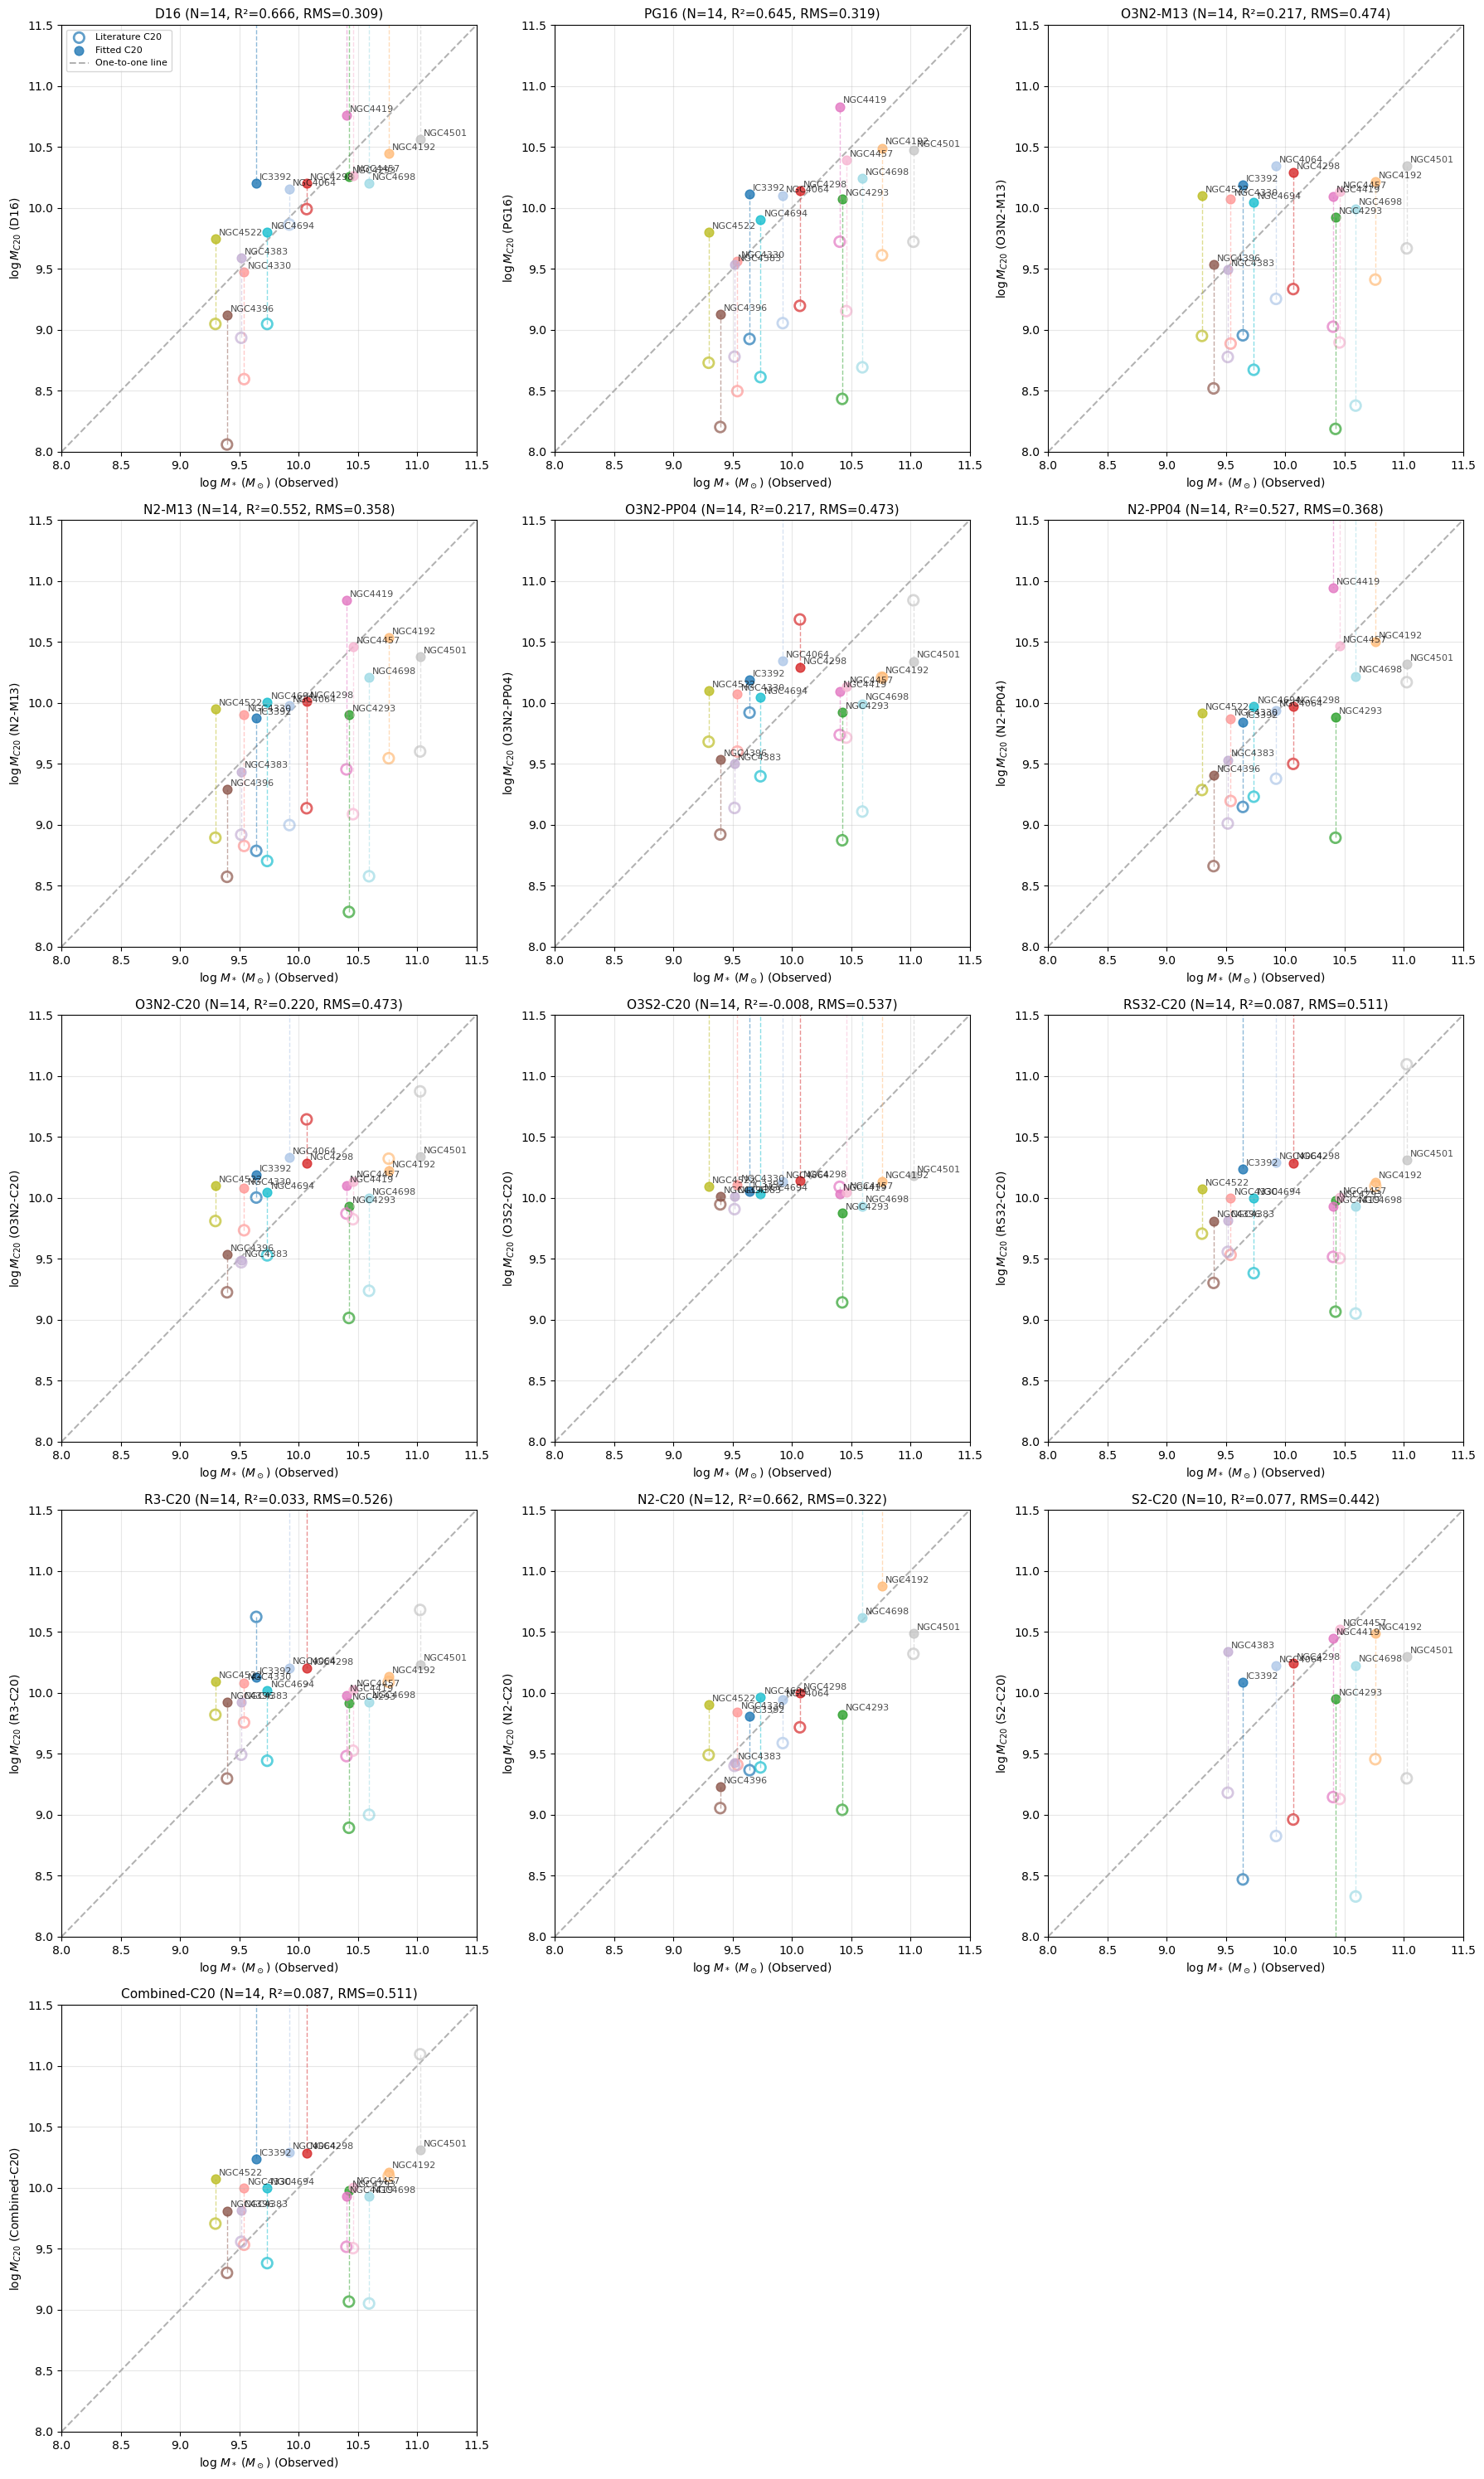


Comparison Plot Legend:
• Hollow circles: logM_C20 using literature parameters
• Filled circles: logM_C20 using fitted parameters
• Dashed lines: Connect literature and fitted values for same galaxy
• Black dashed line: One-to-one line (perfect agreement with observed mass)


In [25]:
# ------------------------------------------------------------------
# Comparison Plots: Literature C20 vs Fitted C20 Parameters
# ------------------------------------------------------------------

# Get successful calibrations
successful_calibrations = [cal for cal in metallicity_calibrations if fitted_parameters.get(cal) is not None]

if len(successful_calibrations) == 0:
    print("No successful fits found! Cannot create comparison plots.")
else:
    print(f"Creating comparison plots for {len(successful_calibrations)} successful calibrations...")
    
    # Create side-by-side comparison plots
    n_cals = len(successful_calibrations)
    n_cols = 3  # 3 columns for comparison
    n_rows = (n_cals + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.flatten()
    
    # Define colors for each galaxy (consistent across all plots)
    galaxy_color_dict = {}
    unique_galaxies = []
    for cal in successful_calibrations:
        for gal in galaxies:
            if gal not in unique_galaxies:
                mass = extract_total_stellar_mass(gal)
                sfr = extract_total_sfr(gal)
                metallicity = extract_total_metallicity(gal, cal)
                if mass is not None and sfr is not None and metallicity is not None:
                    unique_galaxies.append(gal)
    
    galaxy_colors = plt.cm.tab20(np.linspace(0, 1, len(unique_galaxies)))
    for i, gal in enumerate(unique_galaxies):
        galaxy_color_dict[gal] = galaxy_colors[i]
    
    for idx, calibration in enumerate(successful_calibrations):
        ax = axes[idx]
        
        # Extract data for this calibration
        cal_log_masses = []
        cal_log_sfrs = []
        cal_metallicities = []
        cal_galaxy_names = []
        
        for gal in galaxies:
            mass = extract_total_stellar_mass(gal)
            sfr = extract_total_sfr(gal)
            metallicity = extract_total_metallicity(gal, calibration)
            
            if mass is not None and sfr is not None and metallicity is not None:
                cal_log_masses.append(mass)
                cal_log_sfrs.append(sfr)
                cal_metallicities.append(metallicity)
                cal_galaxy_names.append(gal)
        
        cal_log_masses = np.array(cal_log_masses)
        cal_log_sfrs = np.array(cal_log_sfrs)
        cal_metallicities = np.array(cal_metallicities)
        
        # Calculate logM_C20 using literature parameters
        lit_params = [literature_params['Z0'], literature_params['m0'], literature_params['m1'], 
                     literature_params['gamma'], literature_params['beta']]
        logM_C20_lit = c20_formula(lit_params, cal_log_sfrs, cal_metallicities)
        
        # Calculate logM_C20 using fitted parameters
        fitted_params_list = [fitted_parameters[calibration]['Z0'], fitted_parameters[calibration]['m0'],
                            fitted_parameters[calibration]['m1'], fitted_parameters[calibration]['gamma'],
                            fitted_parameters[calibration]['beta']]
        logM_C20_fitted = c20_formula(fitted_params_list, cal_log_sfrs, cal_metallicities)
        
        # Plot observed vs literature C20
        for i, (mass, logM_lit, logM_fit, gal) in enumerate(zip(cal_log_masses, logM_C20_lit, logM_C20_fitted, cal_galaxy_names)):
            color = galaxy_color_dict.get(gal, 'gray')
            
            # Check if literature C20 value is valid (finite)
            literature_valid = np.isfinite(logM_lit)
            
            # Literature C20 (hollow circles) - only plot if valid
            if literature_valid:
                ax.scatter(mass, logM_lit, s=80, facecolors='none', edgecolors=color, 
                          linewidth=2, alpha=0.7, label='Literature C20' if i == 0 else "")
            
            # Fitted C20 (filled circles) - always plot
            ax.scatter(mass, logM_fit, s=60, c=[color], alpha=0.8, 
                      label='Fitted C20' if i == 0 else "")
            
            # Connect literature and fitted points with a line - only if literature value is valid
            if literature_valid:
                ax.plot([mass, mass], [logM_lit, logM_fit], '--', color=color, alpha=0.5, linewidth=1)
            
            # Add galaxy name annotation (offset to avoid overlap)
            ax.annotate(gal, (mass, logM_fit), xytext=(3, 3), textcoords='offset points', 
                       fontsize=8, alpha=0.7)
        
        # Formatting
        ax.set_xlabel(r'$\log\,M_* \; (M_\odot)$ (Observed)', fontsize=10)
        ax.set_ylabel(f'$\\log M_{{C20}}$ ({calibration})', fontsize=10)
        
        # Add fit quality metrics to title
        metrics = fit_quality[calibration]
        ax.set_title(f'{calibration} (N={metrics["n_points"]}, R²={metrics["r_squared"]:.3f}, RMS={metrics["rms"]:.3f})', 
                    fontsize=11)
        
        ax.grid(True, alpha=0.3)
        
        # Set consistent axis limits
        ax.set_xlim(8, 11.5)
        ax.set_ylim(8, 11.5)
        
        # Add one-to-one line
        ax.plot([8, 11.5], [8, 11.5], '--', color='black', alpha=0.3, 
                label='One-to-one line', zorder=0)
        
        # Add legend only to first subplot
        if idx == 0:
            ax.legend(fontsize=8, loc='upper left')
    
    # Hide unused subplots
    for idx in range(len(successful_calibrations), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    print("\nComparison Plot Legend:")
    print("• Hollow circles: logM_C20 using literature parameters")
    print("• Filled circles: logM_C20 using fitted parameters")
    print("• Dashed lines: Connect literature and fitted values for same galaxy")
    print("• Black dashed line: One-to-one line (perfect agreement with observed mass)")

In [21]:
# ------------------------------------------------------------------
# Comprehensive Summary of C20 Parameter Fitting Results
# ------------------------------------------------------------------

print("=" * 100)
print("COMPREHENSIVE SUMMARY: C20 PARAMETER FITTING RESULTS")
print("=" * 100)

print(f"\nFunctional Form Used:")
print(f"log₁₀(M) = m₀ + m₁×log₁₀(SFR) - (1/β)×log₁₀(10^(β/γ×(Z₀-Z)) - 1)")
print(f"where Z = 12 + log(O/H) is the metallicity")

print(f"\nLiterature C20 Parameters (Curti et al. 2020):")
print(f"Z₀ = {literature_params['Z0']:.3f}")
print(f"m₀ = {literature_params['m0']:.3f}")  
print(f"m₁ = {literature_params['m1']:.3f}")
print(f"γ  = {literature_params['gamma']:.3f}")
print(f"β  = {literature_params['beta']:.3f}")

print(f"\n" + "=" * 100)
print("DETAILED FITTING RESULTS BY CALIBRATION")
print("=" * 100)

# Create detailed comparison table
if len(successful_calibrations) > 0:
    print(f"\n{'Calibration':<15} {'N':<3} {'Z₀':<8} {'m₀':<8} {'m₁':<8} {'γ':<8} {'β':<8} {'RMS':<8} {'R²':<8} {'Correlation':<12}")
    print("-" * 100)
    
    # Literature reference row
    print(f"{'Literature':<15} {'-':<3} {literature_params['Z0']:<8.3f} {literature_params['m0']:<8.3f} {literature_params['m1']:<8.3f} {literature_params['gamma']:<8.3f} {literature_params['beta']:<8.3f} {'-':<8} {'-':<8} {'-':<12}")
    print("-" * 100)
    
    for cal in successful_calibrations:
        params = fitted_parameters[cal]
        metrics = fit_quality[cal]
        print(f"{cal:<15} {metrics['n_points']:<3} {params['Z0']:<8.3f} {params['m0']:<8.3f} {params['m1']:<8.3f} {params['gamma']:<8.3f} {params['beta']:<8.3f} {metrics['rms']:<8.3f} {metrics['r_squared']:<8.3f} {metrics['correlation']:<12.3f}")

print(f"\n" + "=" * 100)
print("PARAMETER DEVIATIONS FROM LITERATURE VALUES")
print("=" * 100)

if len(successful_calibrations) > 0:
    print(f"\n{'Calibration':<15} {'ΔZ₀':<8} {'Δm₀':<8} {'Δm₁':<8} {'Δγ':<8} {'Δβ':<8}")
    print("-" * 70)
    
    for cal in successful_calibrations:
        params = fitted_parameters[cal]
        delta_Z0 = params['Z0'] - literature_params['Z0']
        delta_m0 = params['m0'] - literature_params['m0']
        delta_m1 = params['m1'] - literature_params['m1']
        delta_gamma = params['gamma'] - literature_params['gamma']
        delta_beta = params['beta'] - literature_params['beta']
        
        print(f"{cal:<15} {delta_Z0:<+8.3f} {delta_m0:<+8.3f} {delta_m1:<+8.3f} {delta_gamma:<+8.3f} {delta_beta:<+8.3f}")

print(f"\n" + "=" * 100)
print("FIT QUALITY RANKING")
print("=" * 100)

if len(successful_calibrations) > 0:
    # Sort by R²
    ranked_by_r2 = sorted(successful_calibrations, key=lambda x: fit_quality[x]['r_squared'], reverse=True)
    print(f"\nRanked by R² (coefficient of determination):")
    for i, cal in enumerate(ranked_by_r2, 1):
        metrics = fit_quality[cal]
        print(f"{i:2d}. {cal:<15} R² = {metrics['r_squared']:.3f}, RMS = {metrics['rms']:.3f}, N = {metrics['n_points']}")
    
    # Sort by RMS (lower is better)
    ranked_by_rms = sorted(successful_calibrations, key=lambda x: fit_quality[x]['rms'])
    print(f"\nRanked by RMS (root mean square error - lower is better):")
    for i, cal in enumerate(ranked_by_rms, 1):
        metrics = fit_quality[cal]
        print(f"{i:2d}. {cal:<15} RMS = {metrics['rms']:.3f}, R² = {metrics['r_squared']:.3f}, N = {metrics['n_points']}")

print(f"\n" + "=" * 100)
print("KEY FINDINGS")
print("=" * 100)

if len(successful_calibrations) > 0:
    # Calculate summary statistics
    all_r2 = [fit_quality[cal]['r_squared'] for cal in successful_calibrations]
    all_rms = [fit_quality[cal]['rms'] for cal in successful_calibrations]
    
    best_r2_cal = ranked_by_r2[0]
    best_rms_cal = ranked_by_rms[0]
    
    print(f"\n1. Overall Performance:")
    print(f"   • Successfully fitted {len(successful_calibrations)}/{len(metallicity_calibrations)} metallicity calibrations")
    print(f"   • R² range: {min(all_r2):.3f} - {max(all_r2):.3f} (mean: {np.mean(all_r2):.3f})")
    print(f"   • RMS range: {min(all_rms):.3f} - {max(all_rms):.3f} (mean: {np.mean(all_rms):.3f})")
    
    print(f"\n2. Best Performing Calibrations:")
    print(f"   • Highest R²: {best_r2_cal} (R² = {fit_quality[best_r2_cal]['r_squared']:.3f})")
    print(f"   • Lowest RMS: {best_rms_cal} (RMS = {fit_quality[best_rms_cal]['rms']:.3f})")
    
    print(f"\n3. Parameter Comparison with Literature:")
    # Calculate average deviations
    avg_delta_Z0 = np.mean([fitted_parameters[cal]['Z0'] - literature_params['Z0'] for cal in successful_calibrations])
    avg_delta_m0 = np.mean([fitted_parameters[cal]['m0'] - literature_params['m0'] for cal in successful_calibrations])
    avg_delta_m1 = np.mean([fitted_parameters[cal]['m1'] - literature_params['m1'] for cal in successful_calibrations])
    avg_delta_gamma = np.mean([fitted_parameters[cal]['gamma'] - literature_params['gamma'] for cal in successful_calibrations])
    avg_delta_beta = np.mean([fitted_parameters[cal]['beta'] - literature_params['beta'] for cal in successful_calibrations])
    
    print(f"   • Average parameter deviations from literature:")
    print(f"     Z₀: {avg_delta_Z0:+.3f}, m₀: {avg_delta_m0:+.3f}, m₁: {avg_delta_m1:+.3f}, γ: {avg_delta_gamma:+.3f}, β: {avg_delta_beta:+.3f}")
    
    print(f"\n4. Data Coverage:")
    total_galaxies = len(galaxies)
    avg_coverage = np.mean([fit_quality[cal]['n_points'] for cal in successful_calibrations])
    print(f"   • Total galaxies available: {total_galaxies}")
    print(f"   • Average galaxies per calibration: {avg_coverage:.1f}")
    print(f"   • Coverage range: {min([fit_quality[cal]['n_points'] for cal in successful_calibrations])} - {max([fit_quality[cal]['n_points'] for cal in successful_calibrations])} galaxies")

print(f"\n" + "=" * 100)
print("ANALYSIS COMPLETE")
print("=" * 100)
print("The fitted C20 parameters have been derived for your MAUVE galaxy sample.")
print("These custom parameters should provide better agreement with your observed")
print("stellar masses compared to the literature C20 coefficients.")
print("=" * 100)

COMPREHENSIVE SUMMARY: C20 PARAMETER FITTING RESULTS

Functional Form Used:
log₁₀(M) = m₀ + m₁×log₁₀(SFR) - (1/β)×log₁₀(10^(β/γ×(Z₀-Z)) - 1)
where Z = 12 + log(O/H) is the metallicity

Literature C20 Parameters (Curti et al. 2020):
Z₀ = 8.779
m₀ = 10.110
m₁ = 0.560
γ  = 0.310
β  = 2.100

DETAILED FITTING RESULTS BY CALIBRATION

Calibration     N   Z₀       m₀       m₁       γ        β        RMS      R²       Correlation 
----------------------------------------------------------------------------------------------------
Literature      -   8.779    10.110   0.560    0.310    2.100    -        -        -           
----------------------------------------------------------------------------------------------------
D16             14  9.421    11.606   0.217    0.498    1.000    0.309    0.666    0.816       
PG16            14  8.959    11.895   0.188    0.253    4.154    0.319    0.645    0.803       
O3N2-M13        14  8.966    11.913   0.100    0.250    1.975    0.474    0.217    0

$$Z(M,\mathrm{SFR}) = Z_0-\gamma/\beta\log(1+(M/M_0(\mathrm{SFR}))^{-\beta})$$
where $\log(M_0(\mathrm{SFR})) = m_0+m_1\log(\mathrm{SFR})$ or $M_0(\mathrm{SFR}) = 10^{m_0}\mathrm{SFR}^{m_1}$.

Creating 3D surface plots for 4 key calibrations...
Features: Swapped axes (SFR-Mass), tab20 galaxy colors, vertical offset lines


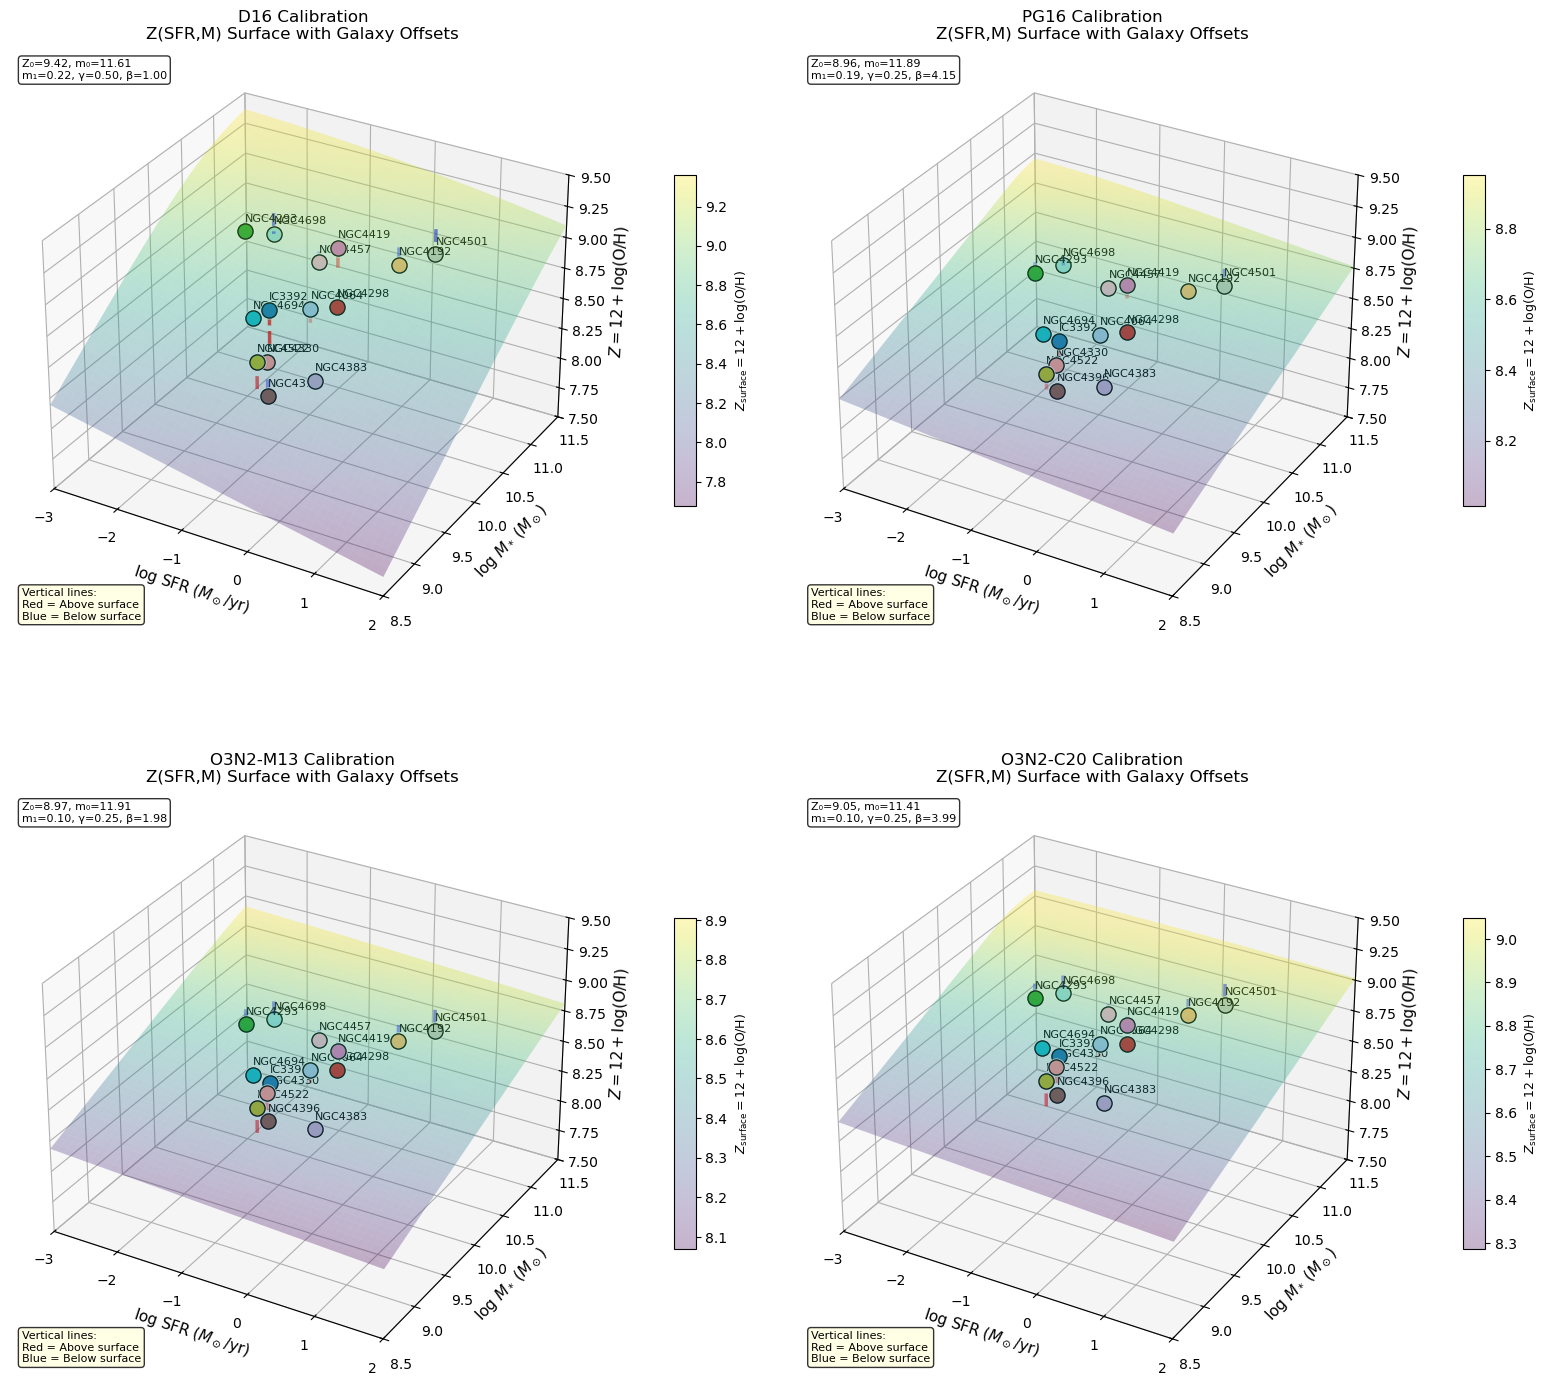


3D SURFACE PLOT DESCRIPTION (MODIFIED)
Formula used: Z(M,SFR) = Z₀ - (γ/β) × log₁₀(1 + (M/M₀(SFR))^(-β))
where M₀(SFR) = 10^(m₀ + m₁×log(SFR))

Plot features:
• X-axis: log(SFR) - Star formation rate [SWAPPED]
• Y-axis: log(M*) - Stellar mass [SWAPPED]
• Z-axis: Z = 12 + log(O/H) - Metallicity
• Gray surface: Predicted metallicity using fitted C20 parameters
• Colored points: Observed galaxy data (each galaxy has unique tab20 color)
• Vertical dashed lines: Show metallicity offset from surface
  - Red lines: Galaxy metallicity ABOVE predicted surface
  - Blue lines: Galaxy metallicity BELOW predicted surface
  - Line opacity scales with offset magnitude

This view shows individual galaxy deviations from the fitted FMR surface.


In [31]:
# ------------------------------------------------------------------
# 3D Surface Plots: Z(M, SFR) Relationship Using Fitted C20 Parameters
# Modified: Swapped axes, tab20 colors, vertical lines with offset coloring
# ------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import warnings
warnings.filterwarnings('ignore')

def calculate_metallicity_surface(logM, logSFR, Z0, m0, m1, gamma, beta):
    """
    Calculate metallicity Z using the inverted C20 formula:
    Z(M,SFR) = Z0 - (gamma/beta) * log(1 + (M/M0(SFR))^(-beta))
    where log(M0(SFR)) = m0 + m1*log(SFR)
    
    Parameters:
    logM: log10(stellar mass)
    logSFR: log10(SFR)
    Z0, m0, m1, gamma, beta: fitted C20 parameters
    """
    # Calculate M0(SFR) = 10^(m0 + m1*logSFR)
    logM0 = m0 + m1 * logSFR
    M0 = 10**logM0
    M = 10**logM
    
    # Calculate the metallicity Z
    ratio = M / M0
    term = 1 + ratio**(-beta)
    Z = Z0 - (gamma / beta) * np.log10(term)
    
    return Z

# Select a few key calibrations to plot (to avoid too many plots)
key_calibrations = ['D16', 'PG16', 'O3N2-M13', 'O3N2-C20']
available_key_cals = [cal for cal in key_calibrations if cal in successful_calibrations]

if len(available_key_cals) == 0:
    print("No key calibrations available for 3D plotting!")
else:
    print(f"Creating 3D surface plots for {len(available_key_cals)} key calibrations...")
    print("Features: Swapped axes (SFR-Mass), tab20 galaxy colors, vertical offset lines")
    
    # Create meshgrid for surface plotting
    # Use realistic ranges based on your data - SWAPPED AXES
    logSFR_range = np.linspace(-3, 2, 50)    # log(SFR) range - now X-axis
    logM_range = np.linspace(8.5, 11.5, 50)  # log(M*) range - now Y-axis
    LogSFR_mesh, LogM_mesh = np.meshgrid(logSFR_range, logM_range)  # SWAPPED ORDER
    
    # Create subplots for 3D surfaces
    n_plots = len(available_key_cals)
    n_cols = min(2, n_plots)
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    fig = plt.figure(figsize=(16, 8*n_rows))
    
    for idx, calibration in enumerate(available_key_cals):
        ax = fig.add_subplot(n_rows, n_cols, idx+1, projection='3d')
        
        # Get fitted parameters for this calibration
        params = fitted_parameters[calibration]
        Z0 = params['Z0']
        m0 = params['m0']
        m1 = params['m1']
        gamma = params['gamma']
        beta = params['beta']
        
        # Calculate metallicity surface
        Z_surface = calculate_metallicity_surface(LogM_mesh, LogSFR_mesh, Z0, m0, m1, gamma, beta)
        
        # Create 3D surface plot with SWAPPED AXES - more transparent and lower z-order
        surface = ax.plot_surface(LogSFR_mesh, LogM_mesh, Z_surface, 
                                 cmap=cm.viridis, alpha=0.3, linewidth=0, antialiased=True,
                                 zorder=1)  # Lower z-order so points appear on top
        
        # Extract data for this calibration
        cal_log_masses = []
        cal_log_sfrs = []
        cal_metallicities = []
        cal_galaxy_names = []
        
        for gal in galaxies:
            mass = extract_total_stellar_mass(gal)
            sfr = extract_total_sfr(gal)
            metallicity = extract_total_metallicity(gal, calibration)
            
            if mass is not None and sfr is not None and metallicity is not None:
                cal_log_masses.append(mass)
                cal_log_sfrs.append(sfr)
                cal_metallicities.append(metallicity)
                cal_galaxy_names.append(gal)
        
        cal_log_masses = np.array(cal_log_masses)
        cal_log_sfrs = np.array(cal_log_sfrs)
        cal_metallicities = np.array(cal_metallicities)
        
        if len(cal_log_masses) > 0:
            # Calculate predicted metallicity on the surface for each galaxy
            Z_predicted_surface = calculate_metallicity_surface(cal_log_masses, cal_log_sfrs, Z0, m0, m1, gamma, beta)
            
            # Calculate offset from surface
            metallicity_offset = cal_metallicities - Z_predicted_surface
            
            # Create tab20 colormap for galaxies
            tab20_colors = plt.cm.tab20(np.linspace(0, 1, len(cal_galaxy_names)))
            
            # Plot each galaxy with individual color and vertical line
            for i, (sfr, mass, obs_Z, surf_Z, offset, gal) in enumerate(
                zip(cal_log_sfrs, cal_log_masses, cal_metallicities, Z_predicted_surface, metallicity_offset, cal_galaxy_names)):
                
                galaxy_color = tab20_colors[i]
                
                # Draw vertical line from surface to observed point FIRST (behind points)
                # Color based on offset: red for above surface, blue for below
                if offset > 0:
                    line_color = 'red'
                    line_alpha = min(0.9, abs(offset) * 3)  # Stronger alpha for larger offset
                else:
                    line_color = 'blue'
                    line_alpha = min(0.9, abs(offset) * 3)
                
                # Draw vertical dashed line with higher z-order than surface
                ax.plot([sfr, sfr], [mass, mass], [surf_Z, obs_Z], 
                       color=line_color, linestyle='--', linewidth=2.5, alpha=line_alpha,
                       zorder=5)  # Higher z-order than surface
                
                # Plot observed point with galaxy-specific color - LARGER and more prominent
                ax.scatter(sfr, mass, obs_Z, c=[galaxy_color], s=120, alpha=1.0, 
                          edgecolors='white', linewidth=2, depthshade=False,
                          zorder=10)  # Highest z-order to ensure visibility
                
                # Add black inner edge for better contrast
                ax.scatter(sfr, mass, obs_Z, c=[galaxy_color], s=120, alpha=1.0, 
                          edgecolors='black', linewidth=1, depthshade=False,
                          zorder=9)
                
                # Add galaxy name annotation with background for better visibility
                ax.text(sfr, mass, obs_Z + 0.08, gal, fontsize=8, alpha=1.0, 
                       bbox=dict(boxstyle='round,pad=0.2', facecolor='none', edgecolor='none', alpha=0.8),
                       zorder=11)
        
        # Formatting with SWAPPED AXES
        ax.set_xlabel(r'$\log\,\mathrm{SFR} \; (M_\odot/\mathrm{yr})$', fontsize=11)  # SWAPPED
        ax.set_ylabel(r'$\log\,M_* \; (M_\odot)$', fontsize=11)  # SWAPPED
        ax.set_zlabel(r'$Z = 12 + \log(\mathrm{O/H})$', fontsize=11)
        ax.set_title(f'{calibration} Calibration\nZ(SFR,M) Surface with Galaxy Offsets', fontsize=12)
        
        # Set axis limits with SWAPPED AXES
        ax.set_xlim(-3, 2)      # SFR range - now X-axis
        ax.set_ylim(8.5, 11.5)  # Mass range - now Y-axis
        ax.set_zlim(7.5, 9.5)   # Metallicity range
        
        # Add colorbar for surface
        cbar = plt.colorbar(surface, ax=ax, shrink=0.4, aspect=15, pad=0.1)
        cbar.set_label(r'$Z_{\mathrm{surface}} = 12 + \log(\mathrm{O/H})$', fontsize=9)
        
        # Add parameter info as text
        param_text = f'Z₀={Z0:.2f}, m₀={m0:.2f}\nm₁={m1:.2f}, γ={gamma:.2f}, β={beta:.2f}'
        ax.text2D(0.02, 0.98, param_text, transform=ax.transAxes, 
                  fontsize=8, verticalalignment='top',
                  bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Add offset legend
        offset_text = 'Vertical lines:\nRed = Above surface\nBlue = Below surface'
        ax.text2D(0.02, 0.02, offset_text, transform=ax.transAxes, 
                  fontsize=8, verticalalignment='bottom',
                  bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*80)
    print("3D SURFACE PLOT DESCRIPTION (MODIFIED)")
    print("="*80)
    print("Formula used: Z(M,SFR) = Z₀ - (γ/β) × log₁₀(1 + (M/M₀(SFR))^(-β))")
    print("where M₀(SFR) = 10^(m₀ + m₁×log(SFR))")
    print("\nPlot features:")
    print("• X-axis: log(SFR) - Star formation rate [SWAPPED]")
    print("• Y-axis: log(M*) - Stellar mass [SWAPPED]") 
    print("• Z-axis: Z = 12 + log(O/H) - Metallicity")
    print("• Gray surface: Predicted metallicity using fitted C20 parameters")
    print("• Colored points: Observed galaxy data (each galaxy has unique tab20 color)")
    print("• Vertical dashed lines: Show metallicity offset from surface")
    print("  - Red lines: Galaxy metallicity ABOVE predicted surface")
    print("  - Blue lines: Galaxy metallicity BELOW predicted surface")
    print("  - Line opacity scales with offset magnitude")
    print("\nThis view shows individual galaxy deviations from the fitted FMR surface.")
    print("="*80)

Creating 2D contour projections of the Z(M,SFR) surfaces...
Using D16 calibration (highest R² = 0.666)


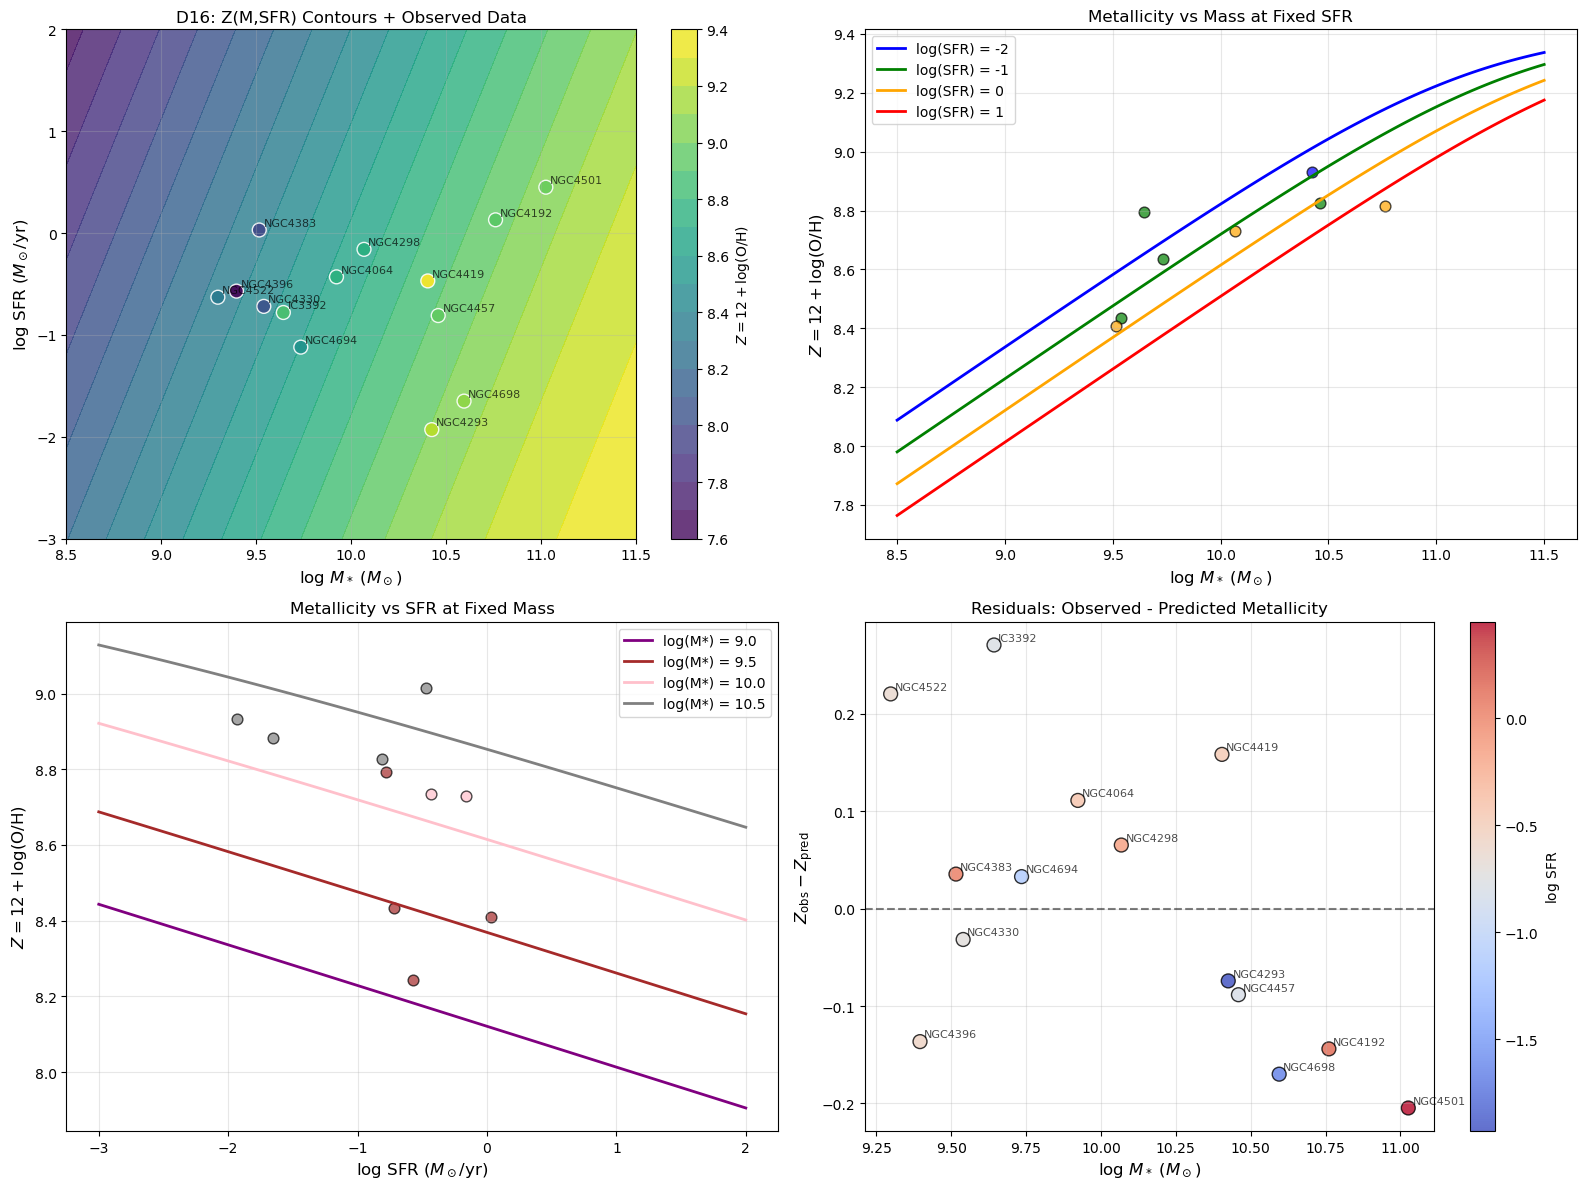


SURFACE ANALYSIS SUMMARY
Best calibration: D16
Fitted parameters: Z₀=9.421, m₀=11.606, m₁=0.217, γ=0.498, β=1.000
Fit quality: R² = 0.666, RMS = 0.309

Residual statistics:
Mean residual: 0.003
RMS residual: 0.144
Standard deviation: 0.144

Surface behavior:
1. Top-left: 2D contour map showing how Z varies across M-SFR plane
2. Top-right: Z vs M at different fixed SFR values (traditional MZR)
3. Bottom-left: Z vs SFR at different fixed masses (SFR-Z relation)
4. Bottom-right: Residuals showing how well the surface fits observed data

OBSERVED METALLICITY DATA
Calibration: D16
Number of galaxies: 14

Galaxy Metallicity Data (12 + log(O/H)):
----------------------------------------------------------------------
 1.   IC3392: Z =  8.794 dex
 2.  NGC4064: Z =  8.734 dex
 3.  NGC4192: Z =  8.814 dex
 4.  NGC4293: Z =  8.932 dex
 5.  NGC4298: Z =  8.730 dex
 6.  NGC4330: Z =  8.434 dex
 7.  NGC4383: Z =  8.409 dex
 8.  NGC4396: Z =  8.242 dex
 9.  NGC4419: Z =  9.014 dex
10.  NGC4457: Z =  

In [34]:
# ------------------------------------------------------------------
# 2D Contour Projections and Cross-sections of Z(M, SFR) Surface
# ------------------------------------------------------------------

# Create 2D contour plots showing projections of the 3D surface
print("Creating 2D contour projections of the Z(M,SFR) surfaces...")

# Select the best calibration for detailed analysis
best_calibration = ranked_by_r2[0]  # Use the one with highest R²
print(f"Using {best_calibration} calibration (highest R² = {fit_quality[best_calibration]['r_squared']:.3f})")

# Get parameters for the best calibration
params = fitted_parameters[best_calibration]
Z0 = params['Z0']
m0 = params['m0'] 
m1 = params['m1']
gamma = params['gamma']
beta = params['beta']

# Create a finer grid for contour plotting
logM_fine = np.linspace(8.5, 11.5, 100)
logSFR_fine = np.linspace(-3, 2, 100)
LogM_contour, LogSFR_contour = np.meshgrid(logM_fine, logSFR_fine)

# Calculate metallicity surface for contours
Z_contour = calculate_metallicity_surface(LogM_contour, LogSFR_contour, Z0, m0, m1, gamma, beta)

# Create figure with multiple subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Contour plot with observed data
contour = ax1.contourf(LogM_contour, LogSFR_contour, Z_contour, levels=20, cmap='viridis', alpha=0.8)
plt.colorbar(contour, ax=ax1, label=r'$Z = 12 + \log(\mathrm{O/H})$')

# Overlay observed data for this calibration
cal_log_masses = []
cal_log_sfrs = []
cal_metallicities = []
cal_galaxy_names = []

for gal in galaxies:
    mass = extract_total_stellar_mass(gal)
    sfr = extract_total_sfr(gal)
    metallicity = extract_total_metallicity(gal, best_calibration)
    
    if mass is not None and sfr is not None and metallicity is not None:
        cal_log_masses.append(mass)
        cal_log_sfrs.append(sfr)
        cal_metallicities.append(metallicity)
        cal_galaxy_names.append(gal)

cal_log_masses = np.array(cal_log_masses)
cal_log_sfrs = np.array(cal_log_sfrs)
cal_metallicities = np.array(cal_metallicities)

# Plot observed points
scatter = ax1.scatter(cal_log_masses, cal_log_sfrs, c=cal_metallicities, 
                     s=100, cmap='viridis', edgecolors='white', linewidth=1, alpha=0.9)

# Add galaxy labels
for mass, sfr, gal in zip(cal_log_masses, cal_log_sfrs, cal_galaxy_names):
    ax1.annotate(gal, (mass, sfr), xytext=(3, 3), textcoords='offset points', 
                fontsize=8, alpha=0.7)

ax1.set_xlabel(r'$\log\,M_* \; (M_\odot)$', fontsize=12)
ax1.set_ylabel(r'$\log\,\mathrm{SFR} \; (M_\odot/\mathrm{yr})$', fontsize=12)
ax1.set_title(f'{best_calibration}: Z(M,SFR) Contours + Observed Data', fontsize=12)
ax1.grid(True, alpha=0.3)

# 2. Cross-section at fixed SFR values
sfr_values = [-2, -1, 0, 1]  # Different SFR values
colors = ['blue', 'green', 'orange', 'red']

for sfr_val, color in zip(sfr_values, colors):
    Z_cross = calculate_metallicity_surface(logM_fine, sfr_val, Z0, m0, m1, gamma, beta)
    ax2.plot(logM_fine, Z_cross, color=color, linewidth=2, 
            label=f'log(SFR) = {sfr_val}')

# Add observed data points at similar SFR values
for sfr_val, color in zip(sfr_values, colors):
    # Find galaxies with SFR close to this value (±0.3 dex)
    mask = np.abs(cal_log_sfrs - sfr_val) < 0.3
    if np.any(mask):
        ax2.scatter(cal_log_masses[mask], cal_metallicities[mask], 
                   color=color, s=60, alpha=0.7, edgecolors='black')

ax2.set_xlabel(r'$\log\,M_* \; (M_\odot)$', fontsize=12)
ax2.set_ylabel(r'$Z = 12 + \log(\mathrm{O/H})$', fontsize=12)
ax2.set_title('Metallicity vs Mass at Fixed SFR', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Cross-section at fixed mass values
mass_values = [9.0, 9.5, 10.0, 10.5]  # Different mass values
colors = ['purple', 'brown', 'pink', 'gray']

for mass_val, color in zip(mass_values, colors):
    Z_cross = calculate_metallicity_surface(mass_val, logSFR_fine, Z0, m0, m1, gamma, beta)
    ax3.plot(logSFR_fine, Z_cross, color=color, linewidth=2, 
            label=f'log(M*) = {mass_val}')

# Add observed data points at similar mass values
for mass_val, color in zip(mass_values, colors):
    # Find galaxies with mass close to this value (±0.2 dex)
    mask = np.abs(cal_log_masses - mass_val) < 0.2
    if np.any(mask):
        ax3.scatter(cal_log_sfrs[mask], cal_metallicities[mask], 
                   color=color, s=60, alpha=0.7, edgecolors='black')

ax3.set_xlabel(r'$\log\,\mathrm{SFR} \; (M_\odot/\mathrm{yr})$', fontsize=12)
ax3.set_ylabel(r'$Z = 12 + \log(\mathrm{O/H})$', fontsize=12)
ax3.set_title('Metallicity vs SFR at Fixed Mass', fontsize=12)
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Residuals: Observed vs Predicted
Z_predicted = calculate_metallicity_surface(cal_log_masses, cal_log_sfrs, Z0, m0, m1, gamma, beta)
residuals = cal_metallicities - Z_predicted

scatter_res = ax4.scatter(cal_log_masses, residuals, c=cal_log_sfrs, 
                         s=100, cmap='coolwarm', alpha=0.8, edgecolors='black')
plt.colorbar(scatter_res, ax=ax4, label=r'$\log\,\mathrm{SFR}$')

# Add horizontal line at zero
ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)

# Add galaxy labels
for mass, res, gal in zip(cal_log_masses, residuals, cal_galaxy_names):
    ax4.annotate(gal, (mass, res), xytext=(3, 3), textcoords='offset points', 
                fontsize=8, alpha=0.7)

ax4.set_xlabel(r'$\log\,M_* \; (M_\odot)$', fontsize=12)
ax4.set_ylabel(r'$Z_{\mathrm{obs}} - Z_{\mathrm{pred}}$', fontsize=12)
ax4.set_title('Residuals: Observed - Predicted Metallicity', fontsize=12)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print analysis summary
print("\n" + "="*80)
print("SURFACE ANALYSIS SUMMARY")
print("="*80)
print(f"Best calibration: {best_calibration}")
print(f"Fitted parameters: Z₀={Z0:.3f}, m₀={m0:.3f}, m₁={m1:.3f}, γ={gamma:.3f}, β={beta:.3f}")
print(f"Fit quality: R² = {fit_quality[best_calibration]['r_squared']:.3f}, RMS = {fit_quality[best_calibration]['rms']:.3f}")

print(f"\nResidual statistics:")
print(f"Mean residual: {np.mean(residuals):.3f}")
print(f"RMS residual: {np.sqrt(np.mean(residuals**2)):.3f}")
print(f"Standard deviation: {np.std(residuals):.3f}")

print(f"\nSurface behavior:")
print("1. Top-left: 2D contour map showing how Z varies across M-SFR plane")
print("2. Top-right: Z vs M at different fixed SFR values (traditional MZR)")
print("3. Bottom-left: Z vs SFR at different fixed masses (SFR-Z relation)")
print("4. Bottom-right: Residuals showing how well the surface fits observed data")
print("="*80)

# Print observed metallicity data for verification
print("\n" + "="*80)
print("OBSERVED METALLICITY DATA")
print("="*80)
print(f"Calibration: {best_calibration}")
print(f"Number of galaxies: {len(cal_galaxy_names)}")
print()
print("Galaxy Metallicity Data (12 + log(O/H)):")
print("-" * 70)
for i, (gal, mass, sfr, metallicity) in enumerate(zip(cal_galaxy_names, cal_log_masses, cal_log_sfrs, cal_metallicities)):
    print(f"{i+1:2d}. {gal:>8s}: Z = {metallicity:6.3f} dex")

print(f"\nMetallicity statistics for {best_calibration}:")
print(f"Range: {np.min(cal_metallicities):.3f} to {np.max(cal_metallicities):.3f} dex")
print(f"Mean: {np.mean(cal_metallicities):.3f} ± {np.std(cal_metallicities):.3f} dex")
print(f"Median: {np.median(cal_metallicities):.3f} dex")

# Show comparison with other calibrations if available
if len(metallicity_calibrations) > 1:
    print(f"\nComparison with other calibrations:")
    print("-" * 50)
    for cal in metallicity_calibrations[:5]:  # Show first 5 calibrations
        if cal != best_calibration and cal in fitted_parameters:
            cal_data = []
            for gal in galaxies:
                met = extract_total_metallicity(gal, cal)
                if met is not None:
                    cal_data.append(met)
            if cal_data:
                cal_data = np.array(cal_data)
                print(f"{cal:>12s}: {np.mean(cal_data):.3f} ± {np.std(cal_data):.3f} dex")
print("="*80)

In [32]:
# Extract D16 metallicities for each galaxy
for gal in galaxies:
    metallicity = extract_total_metallicity(gal, 'D16')
    if metallicity is not None:
        print(f"{gal}: {metallicity:.3f}")

IC3392: 8.794
NGC4064: 8.734
NGC4192: 8.814
NGC4293: 8.932
NGC4298: 8.730
NGC4330: 8.434
NGC4383: 8.409
NGC4396: 8.242
NGC4419: 9.014
NGC4457: 8.826
NGC4501: 8.837
NGC4522: 8.557
NGC4694: 8.637
NGC4698: 8.881
